#  Import Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Bidirectional
from time import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
from functools import reduce
!pip install wandb -qqq
import wandb
from wandb.keras import WandbCallback

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 1.8 MB 10.3 MB/s 
     |████████████████████████████████| 145 kB 47.3 MB/s 
     |████████████████████████████████| 181 kB 59.1 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#standarisasi data
adro = pd.read_csv('/content/drive/My Drive/TA/adro.csv',thousands = ",")
kurs = pd.read_csv('/content/drive/My Drive/TA/kurs.csv',thousands = ",")
bbri = pd.read_csv('/content/drive/My Drive/TA/bbri.csv',thousands = ",")
excl = pd.read_csv('/content/drive/My Drive/TA/excl.csv',thousands = ",")

Mounted at /content/drive


# Pre-processing

## Merge

In [ ]:
dataset = [kurs, adro, bbri, excl]
dataset = reduce(lambda left,right: pd.merge(left,right,on='Date',how='left'), dataset)
dataset = dataset.iloc[::-1] #reverse 
dataset = dataset.reset_index()
dataset.columns = ['index','Date', 
                          'Price_Kurs', 'Open_Kurs', 'High_Kurs', 'Low_Kurs', 'Change_Kurs',
                          'Price_ADRO', 'Open_ADRO', 'High_ADRO', 'Low_ADRO', 'Vol_ADRO', 'Change_ADRO',
                          'Price_BBRI', 'Open_BBRI', 'High_BBRI', 'Low_BBRI', 'Vol_BBRI', 'Change_BBRI',
                          'Price_EXCL', 'Open_EXCL', 'High_EXCL', 'Low_EXCL', 'Vol_EXCL', 'Change_EXCL']
dataset = dataset.drop(['index','Open_Kurs', 'High_Kurs', 'Low_Kurs', 'Change_Kurs', 'Change_ADRO', 'Change_BBRI', 'Change_EXCL'], axis = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Open_x', 'High_x', 'Price_x', 'Low_x', 'Change %_x'} in the result is deprecated and will raise a MergeError in a future version.
  


In [ ]:
dataset["Vol_ADRO"] = dataset["Vol_ADRO"].str.replace("M","") 
dataset['Vol_ADRO'] = dataset['Vol_ADRO'].astype(float) 

dataset["Vol_BBRI"] = dataset["Vol_BBRI"].str.replace("M","") 
dataset['Vol_BBRI'] = dataset['Vol_BBRI'].astype(float) 

dataset["Vol_EXCL"] = dataset["Vol_EXCL"].str.replace("M","") 
dataset["Vol_EXCL"] = dataset["Vol_EXCL"].str.replace("K","")
dataset['Vol_EXCL'] = dataset['Vol_EXCL'].astype(float) 

## Menghandle missing value dengan LOCF

In [ ]:
dataset.isnull().sum()

Date           0
Price_Kurs     0
Price_ADRO    63
Open_ADRO     63
High_ADRO     63
Low_ADRO      63
Vol_ADRO      63
Price_BBRI    63
Open_BBRI     63
High_BBRI     63
Low_BBRI      63
Vol_BBRI      63
Price_EXCL    63
Open_EXCL     63
High_EXCL     63
Low_EXCL      63
Vol_EXCL      63
dtype: int64

In [ ]:
dataset = dataset.fillna(method='ffill')
dataset.isnull().sum()

Date          0
Price_Kurs    0
Price_ADRO    0
Open_ADRO     0
High_ADRO     0
Low_ADRO      0
Vol_ADRO      0
Price_BBRI    0
Open_BBRI     0
High_BBRI     0
Low_BBRI      0
Vol_BBRI      0
Price_EXCL    0
Open_EXCL     0
High_EXCL     0
Low_EXCL      0
Vol_EXCL      0
dtype: int64

## Pengamatan Pola Data

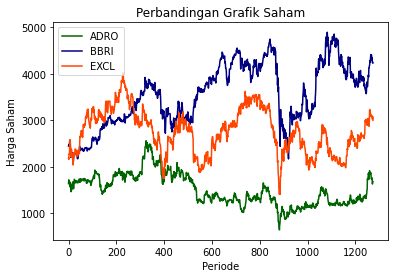

In [ ]:
#visualisasi plot Data
plt.plot(dataset['Price_ADRO'], color = 'darkgreen', label = 'ADRO')
plt.plot(dataset['Price_BBRI'], color = 'navy', label = 'BBRI')
plt.plot(dataset['Price_EXCL'], color = 'orangered', label = 'EXCL')
plt.title('Perbandingan Grafik Saham')
plt.xlabel('Periode')
plt.ylabel('Harga Saham')
plt.legend()
plt.show()

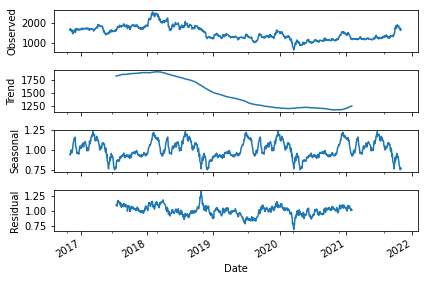

In [ ]:
dataset2 = dataset.copy()
dataset2['Date'] = pd.to_datetime(dataset2['Date'], infer_datetime_format=True)
dataset2.set_index('Date',inplace=True)
seasonal_decompose(dataset2['Price_ADRO'], model='multiplicative', freq=365).plot()
pyplot.show()

## Split Test Train & Normalisasi

In [ ]:
#split data train dan test
train_data = int(len(dataset)*0.8)
df_train = dataset[:train_data]
df_test = dataset[train_data:]

### Dataset ADRO

In [ ]:
#split data train menggunakan cross validation 

from sklearn.model_selection import TimeSeriesSplit
#definisikan berapa jumlah fold
tscv = TimeSeriesSplit(n_splits=5)
tscv.split(df_train)

#mencari tau berapa banyak data dalam setiap fold
i=0
for train, valid in tscv.split(df_train):
    i=i+1
    print ("Jumlah observasi dalam data train%s=%s" % (i, len(train)))
    print ("Jumlah observasi dalam data valid%s=%s" % (i, len(valid)))

Jumlah observasi dalam data train1=174
Jumlah observasi dalam data valid1=169
Jumlah observasi dalam data train2=343
Jumlah observasi dalam data valid2=169
Jumlah observasi dalam data train3=512
Jumlah observasi dalam data valid3=169
Jumlah observasi dalam data train4=681
Jumlah observasi dalam data valid4=169
Jumlah observasi dalam data train5=850
Jumlah observasi dalam data valid5=169


In [ ]:
#split data menjadi 5 fold sesuai dengan pembagian jumlah sebelumnya (Date Price_Kurs Price_ADRO	Open_ADRO	High_ADRO	Low_ADRO	Vol_ADRO)
fold1 = df_train.iloc[:343, 0:7]
fold2 = df_train.iloc[:512, 0:7]
fold3 = df_train.iloc[:681, 0:7]
fold4 = df_train.iloc[:850, 0:7]
fold5 = df_train.iloc[:1019, 0:7]

In [ ]:
#split menjadi data train dan data validasi (Price_Kurs	Price_ADRO	Open_ADRO	High_ADRO	Low_ADRO	Vol_ADRO)
train1, valid1 = fold1.iloc[:174, 1:7], fold1.iloc[174:343, 1:7]
train2, valid2 = fold2.iloc[:343, 1:7], fold2.iloc[343:512, 1:7]
train3, valid3 = fold3.iloc[:512, 1:7], fold3.iloc[512:681, 1:7]
train4, valid4 = fold4.iloc[:681, 1:7], fold4.iloc[681:850, 1:7]
train5, valid5 = fold5.iloc[:850, 1:7], fold5.iloc[850:1019, 1:7]

In [ ]:
#DATA TRAIN & VALIDATION
#train1_saham berisi seluruh variabel (OHLCV) = Price_ADRO	Open_ADRO	High_ADRO	Low_ADRO	Vol_ADRO, train1_SahamKurs berisi seluruh variabel (OHLCV + Kurs), train1_Close berisi kolom Price_ADRO)
train1_Saham, train1_SahamKurs, train1_Close =  train1.iloc[:,1:6], train1.iloc[:,0:6], train1.iloc[:,1:2] 
train2_Saham, train2_SahamKurs, train2_Close =  train2.iloc[:,1:6], train2.iloc[:,0:6], train2.iloc[:,1:2]
train3_Saham, train3_SahamKurs, train3_Close =  train3.iloc[:,1:6], train3.iloc[:,0:6], train3.iloc[:,1:2]
train4_Saham, train4_SahamKurs, train4_Close =  train4.iloc[:,1:6], train4.iloc[:,0:6], train4.iloc[:,1:2]
train5_Saham, train5_SahamKurs, train5_Close =  train5.iloc[:,1:6], train5.iloc[:,0:6], train5.iloc[:,1:2]

valid1_Saham, valid1_SahamKurs, valid1_Close = valid1.iloc[:,1:6], valid1.iloc[:,0:6], valid1.iloc[:,1:2]
valid2_Saham, valid2_SahamKurs, valid2_Close = valid2.iloc[:,1:6], valid2.iloc[:,0:6], valid2.iloc[:,1:2]
valid3_Saham, valid3_SahamKurs, valid3_Close = valid3.iloc[:,1:6], valid3.iloc[:,0:6], valid3.iloc[:,1:2]
valid4_Saham, valid4_SahamKurs, valid4_Close = valid4.iloc[:,1:6], valid4.iloc[:,0:6], valid4.iloc[:,1:2]
valid5_Saham, valid5_SahamKurs, valid5_Close = valid5.iloc[:,1:6], valid5.iloc[:,0:6], valid5.iloc[:,1:2]

In [ ]:
#DATA TEST
train_Saham, train_SahamKurs, train_Close = df_train.iloc[:, 2:7], df_train.iloc[:, 1:7], df_train.iloc[:, 2:3]
test_Saham, test_SahamKurs, test_Close = df_test.iloc[:,2:7], df_test.iloc[:,1:7], df_test.iloc[:,2:3]

In [ ]:
#SCALING DATA
#-----------DATA TRAIN & DATA VALIDASI--------------------
#scaler untuk variabel predictor(x)
scP = MinMaxScaler(feature_range = (0, 1)) 
#data train saham
train1_Saham = scP.fit_transform(train1_Saham)
train2_Saham = scP.fit_transform(train2_Saham)
train3_Saham = scP.fit_transform(train3_Saham)
train4_Saham = scP.fit_transform(train4_Saham)
train5_Saham = scP.fit_transform(train5_Saham)
#data validasi saham
valid1_Saham = scP.fit_transform(valid1_Saham)
valid2_Saham = scP.fit_transform(valid2_Saham)
valid3_Saham = scP.fit_transform(valid3_Saham)
valid4_Saham = scP.fit_transform(valid4_Saham)
valid5_Saham = scP.fit_transform(valid5_Saham)
#data train saham & kurs
train1_SahamKurs = scP.fit_transform(train1_SahamKurs)
train2_SahamKurs = scP.fit_transform(train2_SahamKurs)
train3_SahamKurs = scP.fit_transform(train3_SahamKurs)
train4_SahamKurs = scP.fit_transform(train4_SahamKurs)
train5_SahamKurs = scP.fit_transform(train5_SahamKurs)
#data validasi saham & kurs
valid1_SahamKurs = scP.fit_transform(valid1_SahamKurs)
valid2_SahamKurs = scP.fit_transform(valid2_SahamKurs)
valid3_SahamKurs = scP.fit_transform(valid3_SahamKurs)
valid4_SahamKurs = scP.fit_transform(valid4_SahamKurs)
valid5_SahamKurs = scP.fit_transform(valid5_SahamKurs)
#----------------------DATA TEST--------------------
#variabel predictor(x)
#data train
train_Saham = scP.fit_transform(train_Saham)
train_SahamKurs = scP.fit_transform(train_SahamKurs)
#data test
test_Saham = scP.fit_transform(test_Saham)
test_SahamKurs = scP.fit_transform(test_SahamKurs)

#-----------DATA TRAIN & DATA VALIDASI--------------------
#variabel target data train
scC1 = MinMaxScaler(feature_range = (0, 1)) 
scC2 = MinMaxScaler(feature_range = (0, 1)) 
scC3 = MinMaxScaler(feature_range = (0, 1)) 
scC4 = MinMaxScaler(feature_range = (0, 1)) 
scC5 = MinMaxScaler(feature_range = (0, 1)) 
train1_Close = scC1.fit_transform(train1_Close)
train2_Close = scC2.fit_transform(train2_Close)
train3_Close = scC3.fit_transform(train3_Close)
train4_Close = scC4.fit_transform(train4_Close)
train5_Close = scC5.fit_transform(train5_Close)
#variabel target data validasi
scVC1 = MinMaxScaler(feature_range = (0, 1)) 
scVC2 = MinMaxScaler(feature_range = (0, 1)) 
scVC3 = MinMaxScaler(feature_range = (0, 1)) 
scVC4 = MinMaxScaler(feature_range = (0, 1)) 
scVC5 = MinMaxScaler(feature_range = (0, 1)) 
valid1_Close = scVC1.fit_transform(valid1_Close)
valid2_Close = scVC2.fit_transform(valid2_Close)
valid3_Close = scVC3.fit_transform(valid3_Close)
valid4_Close = scVC4.fit_transform(valid4_Close)
valid5_Close = scVC5.fit_transform(valid5_Close)
#----------------------DATA TEST--------------------
scC = MinMaxScaler(feature_range = (0, 1)) #untuk variabel target (y)
scCT = MinMaxScaler(feature_range = (0, 1)) #untuk variabel target (y)
train_Close = scC.fit_transform(train_Close)
test_Close = scCT.fit_transform(test_Close)

### Dataset lain BBRI

In [ ]:
bmulti_train, bmultiKurs_train, bclose_train = df_train.iloc[:, 7:12], df_train.loc[:,['Price_Kurs', 'Price_BBRI', 'Open_BBRI', 'High_BBRI', 'Low_BBRI', 'Vol_BBRI']], df_train.iloc[:, 7:8]
bmulti_test, bmultiKurs_test, bclose_test = df_test.iloc[:,7:12], df_test.loc[:,['Price_Kurs', 'Price_BBRI', 'Open_BBRI', 'High_BBRI', 'Low_BBRI', 'Vol_BBRI']], df_test.iloc[:,7:8]

In [ ]:
#SCALING DATA

#data train
bmulti_train = scP.fit_transform(bmulti_train)
bmultiKurs_train = scP.fit_transform(bmultiKurs_train)
#data test
bmulti_test = scP.fit_transform(bmulti_test)
bmultiKurs_test = scP.fit_transform(bmultiKurs_test)

#variable target close price (untuk variabel target (y) scaler harus berbeda)
scCB = MinMaxScaler(feature_range = (0, 1))
scCBT = MinMaxScaler(feature_range = (0, 1)) 
bclose_train = scCB.fit_transform(bclose_train)
bclose_test = scCBT.fit_transform(bclose_test)

### Dataset lain EXCL

In [ ]:
emulti_train, emultiKurs_train, eclose_train = df_train.iloc[:,12:], df_train.loc[:,['Price_Kurs', 'Price_EXCL', 'Open_EXCL', 'High_EXCL', 'Low_EXCL', 'Vol_EXCL']], df_train.iloc[:,12:13]
emulti_test, emultiKurs_test, eclose_test = df_test.iloc[:,12:], df_test.loc[:,['Price_Kurs', 'Price_EXCL', 'Open_EXCL', 'High_EXCL', 'Low_EXCL', 'Vol_EXCL']], df_test.iloc[:,12:13]

In [ ]:
#SCALING DATA

#data train
emulti_train = scP.fit_transform(emulti_train)
emultiKurs_train = scP.fit_transform(emultiKurs_train)
#data test
emulti_test = scP.fit_transform(emulti_test)
emultiKurs_test = scP.fit_transform(emultiKurs_test)

#variable target close price (untuk variabel target (y) scaler harus berbeda)
scCE = MinMaxScaler(feature_range = (0, 1)) #untuk variabel target (y)
scCET = MinMaxScaler(feature_range = (0, 1))  #untuk variabel target (y)
eclose_train = scCE.fit_transform(eclose_train)
eclose_test = scCET.fit_transform(eclose_test)

# Struktur Data

In [ ]:
#mendefinisikan timestep (5 & 10)
jumlah_timestep = 10

## Struktur Data ADRO

### Saham

In [ ]:
# Struktur Data Training Fold 1

x_train1 = []
y_train1 = []
for i in range(jumlah_timestep, len(train1_Saham)): 
    x_train1.append(train1_Saham[(i-jumlah_timestep):i]) #input
    y_train1.append(train1_Close[i,0]) #output
x_train1, y_train1 = np.array(x_train1), np.array(y_train1) 
# for i in range(len(x_train1)): 
#         print(x_train1[i], y_train1[i]) #Cek Struktur Data

# Struktur Data Test Fold 1

x_valid1 = []
y_valid1 = []
for i in range(jumlah_timestep, len(valid1_Saham)):
    x_valid1.append(valid1_Saham[(i-jumlah_timestep):i]) #input
    y_valid1.append(valid1_Close[i,0]) #output
x_valid1, y_valid1 = np.array(x_valid1), np.array(y_valid1)
# for i in range(len(x_valid1)):
# 	print(x_valid1[i], y_valid1[i]) #Cek Struktur Data
y_valid1 = np.reshape(y_valid1, (y_valid1.shape[0], 1)) #supaya bisa di invers harus pny 2 dimensi
y_valid1 = scVC1.inverse_transform(y_valid1)

In [ ]:
# Struktur Data Training Fold 2

x_train2 = []
y_train2 = []
for i in range(jumlah_timestep, len(train2_Saham)): 
    x_train2.append(train2_Saham[(i-jumlah_timestep):i]) #input
    y_train2.append(train2_Close[i,0]) #output
x_train2, y_train2 = np.array(x_train2), np.array(y_train2) 
# for i in range(len(x_train2)):
# 	print(x_train2[i], y_train2[i]) #Cek Struktur Data

# Struktur Data Test Fold 2

x_valid2 = []
y_valid2 = []
for i in range(jumlah_timestep, len(valid2_Saham)): 
    x_valid2.append(valid2_Saham[(i-jumlah_timestep):i]) #input
    y_valid2.append(valid2_Close[i,0]) #output
x_valid2, y_valid2 = np.array(x_valid2), np.array(y_valid2) 
# for i in range(len(x_valid2)):
# 	print(x_valid2[i], y_valid2[i]) #Cek Struktur Data
y_valid2 = np.reshape(y_valid2, (y_valid2.shape[0], 1)) #supaya bisa di invers harus pny 2 dimensi
y_valid2 = scVC2.inverse_transform(y_valid2)

In [ ]:
# Struktur Data Training Fold 3

x_train3 = []
y_train3 = []
for i in range(jumlah_timestep, len(train3_Saham)): 
    x_train3.append(train3_Saham[(i-jumlah_timestep):i]) #input 
    y_train3.append(train3_Close[i,0]) #output
x_train3, y_train3 = np.array(x_train3), np.array(y_train3) 
# for i in range(len(x_train3)): 
# 	print(x_train3[i], y_train3[i]) #Cek Struktur Data

# Struktur Data Test Fold 3

x_valid3 = []
y_valid3 = []
for i in range(jumlah_timestep, len(valid3_Saham)): 
    x_valid3.append(valid3_Saham[(i-jumlah_timestep):i]) #input
    y_valid3.append(valid3_Close[i,0]) #output
x_valid3, y_valid3 = np.array(x_valid3), np.array(y_valid3) 
# for i in range(len(x_valid3)):
# 	print(x_valid3[i], y_valid3[i]) #Cek Struktur Data
y_valid3 = np.reshape(y_valid3, (y_valid3.shape[0], 1)) #supaya bisa di invers harus pny 2 dimensi
y_valid3 = scVC3.inverse_transform(y_valid3)

In [ ]:
# Struktur Data Training Fold 4

x_train4 = []
y_train4 = []
for i in range(jumlah_timestep, len(train4_Saham)): 
    x_train4.append(train4_Saham[(i-jumlah_timestep):i]) #input
    y_train4.append(train4_Close[i,0]) #output
x_train4, y_train4 = np.array(x_train4), np.array(y_train4) 
# for i in range(len(x_train4)): 
# 	print(x_train4[i], y_train4[i]) #Cek Struktur Data

# Struktur Data Test Fold 4

x_valid4 = []
y_valid4 = []
for i in range(jumlah_timestep, len(valid4_Saham)): 
    x_valid4.append(valid4_Saham[(i-jumlah_timestep):i]) #input
    y_valid4.append(valid4_Close[i,0]) #output
x_valid4, y_valid4 = np.array(x_valid4), np.array(y_valid4) 
# for i in range(len(x_valid4)): 
# 	print(x_valid4[i], y_valid4[i]) #Cek Struktur Data
y_valid4 = np.reshape(y_valid4, (y_valid4.shape[0], 1)) #supaya bisa di invers harus pny 2 dimensi
y_valid4 = scVC4.inverse_transform(y_valid4)

In [ ]:
# Struktur Data Training Fold 5

x_train5 = []
y_train5 = []
for i in range(jumlah_timestep, len(train5_Saham)): 
    x_train5.append(train5_Saham[(i-jumlah_timestep):i]) #input
    y_train5.append(train5_Close[i,0]) #output 
x_train5, y_train5 = np.array(x_train5), np.array(y_train5) 
# for i in range(len(x_train5)): 
# 	print(x_train5[i], y_train4[i]) #Cek Struktur Data

# Struktur Data Test Fold 5

x_valid5 = []
y_valid5 = []
for i in range(jumlah_timestep, len(valid5_Saham)): 
    x_valid5.append(valid5_Saham[(i-jumlah_timestep):i]) #input
    y_valid5.append(valid5_Close[i,0]) #output
x_valid5, y_valid5 = np.array(x_valid5), np.array(y_valid5) 
# for i in range(len(x_valid5)): 
# 	print(x_valid5[i], y_valid5[i]) #Cek Struktur Data
y_valid5 = np.reshape(y_valid5, (y_valid5.shape[0], 1)) #supaya bisa di invers harus pny 2 dimensi
y_valid5 = scVC5.inverse_transform(y_valid5)

In [ ]:
# Struktur Data Test
#Untuk fit
x_train = []
y_train = []
for i in range(jumlah_timestep, len(train_Saham)): 
    x_train.append(train_Saham[(i-jumlah_timestep):i]) #input
    y_train.append(train_Close[i,0]) #output 
x_train, y_train = np.array(x_train), np.array(y_train) 
# for i in range(len(x_train)): 
#  	print(x_train[i], y_train[i]) #Cek Struktur Data

# Untuk Test 
x_test = []
y_test = []
for i in range(jumlah_timestep, len(test_Saham)): 
    x_test.append(test_Saham[(i-jumlah_timestep):i]) #input
    y_test.append(test_Close[i,0]) #output
x_test, y_test = np.array(x_test), np.array(y_test) 
y_test = np.reshape(y_test, (y_test.shape[0], 1)) #supaya bisa di invers harus pny 2 dimensi
y_test = scCT.inverse_transform(y_test)

### Saham & Kurs

In [ ]:
# Struktur Data Training Fold 1

x_ktrain1 = []
y_ktrain1 = []
for i in range(jumlah_timestep, len(train1_SahamKurs)): 
    x_ktrain1.append(train1_SahamKurs[(i-jumlah_timestep):i]) #input
    y_ktrain1.append(train1_Close[i,0]) #output
x_ktrain1, y_ktrain1 = np.array(x_ktrain1), np.array(y_ktrain1) 
# for i in range(len(x_ktrain1)): 
#      print(x_ktrain1[i], y_ktrain1[i]) #Cek Struktur Data

# Struktur Data Test Fold 1

x_kvalid1 = []
y_kvalid1 = []
for i in range(jumlah_timestep, len(valid1_SahamKurs)):
    x_kvalid1.append(valid1_SahamKurs[(i-jumlah_timestep):i]) #input
    y_kvalid1.append(valid1_Close[i,0]) #output
x_kvalid1, y_kvalid1 = np.array(x_kvalid1), np.array(y_kvalid1)
# for i in range(len(x_kvalid1)):
# 	print(x_kvalid1[i], y_kvalid1[i]) #Cek Struktur Data
y_kvalid1 = np.reshape(y_kvalid1, (y_kvalid1.shape[0], 1)) 
y_kvalid1 = scVC1.inverse_transform(y_kvalid1)

In [ ]:
# Struktur Data Training Fold 2

x_ktrain2 = []
y_ktrain2 = []
for i in range(jumlah_timestep, len(train2_SahamKurs)): 
    x_ktrain2.append(train2_SahamKurs[(i-jumlah_timestep):i]) #input
    y_ktrain2.append(train2_Close[i,0]) #output
x_ktrain2, y_ktrain2 = np.array(x_ktrain2), np.array(y_ktrain2) 
# for i in range(len(x_ktrain2)):
# 	print(x_ktrain2[i], y_ktrain2[i]) #Cek Struktur Data

# Struktur Data Test Fold 2

x_kvalid2 = []
y_kvalid2 = []
for i in range(jumlah_timestep, len(valid2_SahamKurs)): 
    x_kvalid2.append(valid2_SahamKurs[(i-jumlah_timestep):i]) #input
    y_kvalid2.append(valid2_Close[i,0]) #output
x_kvalid2, y_kvalid2 = np.array(x_kvalid2), np.array(y_kvalid2) 
# for i in range(len(x_kvalid2)):
# 	print(x_kvalid2[i], y_kvalid2[i]) #Cek Struktur Data
y_kvalid2 = np.reshape(y_kvalid2, (y_kvalid2.shape[0], 1)) #supaya bisa di invers harus pny 2 dimensi
y_kvalid2 = scVC2.inverse_transform(y_kvalid2)

In [ ]:
# Struktur Data Training Fold 3

x_ktrain3 = []
y_ktrain3 = []
for i in range(jumlah_timestep, len(train3_SahamKurs)): 
    x_ktrain3.append(train3_SahamKurs[(i-jumlah_timestep):i]) #input 
    y_ktrain3.append(train3_Close[i,0]) #output
x_ktrain3, y_ktrain3 = np.array(x_ktrain3), np.array(y_ktrain3) 
# for i in range(len(x_ktrain3)): 
# 	print(x_ktrain3[i], y_ktrain3[i]) #Cek Struktur Data

# Struktur Data Test Fold 3

x_kvalid3 = []
y_kvalid3 = []
for i in range(jumlah_timestep, len(valid3_SahamKurs)): 
    x_kvalid3.append(valid3_SahamKurs[(i-jumlah_timestep):i]) #input
    y_kvalid3.append(valid3_Close[i,0]) #output
x_kvalid3, y_kvalid3 = np.array(x_kvalid3), np.array(y_kvalid3) 
# for i in range(len(x_kvalid3)):
# 	print(x_kvalid3[i], y_kvalid3[i]) #Cek Struktur Data
y_kvalid3 = np.reshape(y_kvalid3, (y_kvalid3.shape[0], 1)) #supaya bisa di invers harus pny 2 dimensi
y_kvalid3 = scVC3.inverse_transform(y_kvalid3)

In [ ]:
# Struktur Data Training Fold 4

x_ktrain4 = []
y_ktrain4 = []
for i in range(jumlah_timestep, len(train4_SahamKurs)): 
    x_ktrain4.append(train4_SahamKurs[(i-jumlah_timestep):i]) #input
    y_ktrain4.append(train4_Close[i,0]) #output
x_ktrain4, y_ktrain4 = np.array(x_ktrain4), np.array(y_ktrain4) 
# for i in range(len(x_ktrain4)): 
# 	print(x_ktrain4[i], y_ktrain4[i]) #Cek Struktur Data

# Struktur Data Test Fold 4

x_kvalid4 = []
y_kvalid4 = []
for i in range(jumlah_timestep, len(valid4_SahamKurs)): 
    x_kvalid4.append(valid4_SahamKurs[(i-jumlah_timestep):i]) #input
    y_kvalid4.append(valid4_Close[i,0]) #output
x_kvalid4, y_kvalid4 = np.array(x_kvalid4), np.array(y_kvalid4) 
# for i in range(len(x_kvalid4)): 
# 	print(x_kvalid4[i], y_kvalid4[i]) #Cek Struktur Data
y_kvalid4 = np.reshape(y_kvalid4, (y_kvalid4.shape[0], 1)) #supaya bisa di invers harus pny 2 dimensi
y_kvalid4 = scVC4.inverse_transform(y_kvalid4)

In [ ]:
# Struktur Data Training Fold 5

x_ktrain5 = []
y_ktrain5 = []
for i in range(jumlah_timestep, len(train5_SahamKurs)): 
    x_ktrain5.append(train5_SahamKurs[(i-jumlah_timestep):i]) #input
    y_ktrain5.append(train5_Close[i,0]) #output 
x_ktrain5, y_ktrain5 = np.array(x_ktrain5), np.array(y_ktrain5) 
# for i in range(len(x_ktrain5)): 
# 	print(x_ktrain5[i], y_ktrain5[i]) #Cek Struktur Data

# Struktur Data Test Fold 5

x_kvalid5 = []
y_kvalid5 = []
for i in range(jumlah_timestep, len(valid5_SahamKurs)): 
    x_kvalid5.append(valid5_SahamKurs[(i-jumlah_timestep):i]) #input
    y_kvalid5.append(valid5_Close[i,0]) #output
x_kvalid5, y_kvalid5 = np.array(x_kvalid5), np.array(y_kvalid5) 
# for i in range(len(x_kvalid5)): 
# 	print(x_kvalid5[i], y_kvalid5[i]) #Cek Struktur Data
y_kvalid5 = np.reshape(y_kvalid5, (y_kvalid5.shape[0], 1)) #supaya bisa di invers harus pny 2 dimensi
y_kvalid5 = scVC5.inverse_transform(y_kvalid5)

In [ ]:
# Struktur Data Test 

#Untuk fit
x_ktrain = []
y_ktrain = []
for i in range(jumlah_timestep, len(train_SahamKurs)): 
    x_ktrain.append(train_SahamKurs[(i-jumlah_timestep):i]) #input
    y_ktrain.append(train_Close[i,0]) #output 
x_ktrain, y_ktrain = np.array(x_ktrain), np.array(y_ktrain) 
# for i in range(len(x_ktrain)): 
#  	print(x_ktrain[i], y_ktrain[i]) #Cek Struktur Data

x_ktest = []
y_ktest = []
for i in range(jumlah_timestep, len(test_SahamKurs)): 
    x_ktest.append(test_SahamKurs[(i-jumlah_timestep):i]) #input
    y_ktest.append(test_Close[i,0]) #output
x_ktest, y_ktest = np.array(x_ktest), np.array(y_ktest) 
y_ktest = np.reshape(y_ktest, (y_ktest.shape[0], 1)) #supaya bisa di invers harus pny 2 dimensi
y_ktest = scCT.inverse_transform(y_ktest)

## Struktur Dataset lain (BBRI)

### Saham

In [ ]:
# Struktur Data Test

#untuk fit
x_btrain = []
y_btrain = []
for i in range(jumlah_timestep, len(bmulti_train)): 
    x_btrain.append(bmulti_train[(i-jumlah_timestep):i]) #input
    y_btrain.append(bclose_train[i,0]) #output
x_btrain, y_btrain = np.array(x_btrain), np.array(y_btrain) 
# for i in range(len(x_btrain)): 
#     print(x_btrain[i], y_btrain[i]) #Cek Struktur Data

#untuk Test
x_btest = []
y_btest = []
for i in range(jumlah_timestep, len(bmulti_test)): 
    x_btest.append(bmulti_test[(i-jumlah_timestep):i]) #input 
    y_btest.append(bclose_test[i,0]) #output
x_btest, y_btest = np.array(x_btest), np.array(y_btest) 
y_btest = np.reshape(y_btest, (y_btest.shape[0], 1)) #supaya bisa di invers harus pny 2 dimensi
y_btest = scCBT.inverse_transform(y_btest)

### Saham & Kurs

In [ ]:
# Struktur Data Test

#untuk fit
x_bktrain = []
y_bktrain = []
for i in range(jumlah_timestep, len(bmultiKurs_train)): 
    x_bktrain.append(bmultiKurs_train[(i-jumlah_timestep):i]) #input
    y_bktrain.append(bclose_train[i,0]) #output
x_bktrain, y_bktrain = np.array(x_bktrain), np.array(y_bktrain) 
# for i in range(len(x_bktrain)): 
#     print(x_bktrain[i], y_bktrain[i]) #Cek Struktur Data

#untuk Test
x_bktest = []
y_bktest = []
for i in range(jumlah_timestep, len(bmultiKurs_test)): 
    x_bktest.append(bmultiKurs_test[(i-jumlah_timestep):i]) #input 
    y_bktest.append(bclose_test[i,0]) #output
x_bktest, y_bktest = np.array(x_bktest), np.array(y_bktest) 
y_bktest = np.reshape(y_bktest, (y_bktest.shape[0], 1)) 
y_bktest = scCBT.inverse_transform(y_bktest)

## Struktur Dataset lain (EXCL)

### Saham

In [ ]:
# Struktur Data Test
#untuk fit
x_etrain = []
y_etrain = []
for i in range(jumlah_timestep, len(emulti_train)): 
    x_etrain.append(emulti_train[(i-jumlah_timestep):i]) #input
    y_etrain.append(eclose_train[i,0]) #output
x_etrain, y_etrain = np.array(x_etrain), np.array(y_etrain) 
# for i in range(len(x_etrain)): 
#     print(x_etrain[i], y_etrain[i]) #Cek Struktur Data

#untuk test
x_etest = []
y_etest = []
for i in range(jumlah_timestep, len(emulti_test)): 
    x_etest.append(emulti_test[(i-jumlah_timestep):i]) #input 
    y_etest.append(eclose_test[i,0]) #output
x_etest, y_etest = np.array(x_etest), np.array(y_etest) 
y_etest = np.reshape(y_etest, (y_etest.shape[0], 1)) #supaya bisa di invers harus pny 2 dimensi
y_etest = scCET.inverse_transform(y_etest)

### Saham & Kurs

In [ ]:
# Struktur Data Test
#untuk fit
x_ektrain = []
y_ektrain = []
for i in range(jumlah_timestep, len(emultiKurs_train)): 
    x_ektrain.append(emultiKurs_train[(i-jumlah_timestep):i]) #input
    y_ektrain.append(eclose_train[i,0]) #output
x_ektrain, y_ektrain = np.array(x_ektrain), np.array(y_ektrain) 
# for i in range(len(x_ektrain)): 
#     print(x_ektrain[i], y_ektrain[i]) #Cek Struktur Data

#untuk test
x_ektest = []
y_ektest = []
for i in range(jumlah_timestep, len(emultiKurs_test)): 
    x_ektest.append(emultiKurs_test[(i-jumlah_timestep):i]) #input 
    y_ektest.append(eclose_test[i,0]) #output
x_ektest, y_ektest = np.array(x_ektest), np.array(y_ektest) 
y_ektest = np.reshape(y_ektest, (y_ektest.shape[0], 1)) #supaya bisa di invers harus pny 2 dimensi
y_ektest = scCET.inverse_transform(y_ektest)

# Training Model (wandb)

In [ ]:
wandb.login()

wandb: Currently logged in as: ghinarosa. Use `wandb login --relogin` to force relogin


True

In [ ]:
# mendefinisikan hyperparameter yang ingin di tuning
sweep_config = {
   'method': 'grid',
   'parameters': {
       'units': {
           'values': [32, 64, 128, 256, 512]
       },
       'optimizer' : {
           'values': ["adam", "sgd", "rmsprop"]
       },
       'epochs': {
           'values' : [25, 50, 100] 
       },
       'batch_size': {
           'values' : [32, 64, 128] 
       },
   }
}

In [ ]:
# membuat 2 project yakni "Training Saham" untuk training model dengan variabel OHLCV dan
# project "Training Saham & Kurs" untuk training model variable OHLCV dan Kurs
# pada tahap ini running diulang sebanyak 5 kali menyesuaikan dengan dataset tiap fold 
# sehingga akan ada 5 sweep (fold) dalam satu project
sweep_id = wandb.sweep(sweep_config, project="Training Saham & Kurs")

Create sweep with ID: vxm3325t
Sweep URL: https://wandb.ai/ghinarosa/Training%20Saham%20%26%20Kurs/sweeps/vxm3325t


In [ ]:
def train():
    # mendefinisikan nilai awal
    config_defaults = {
        'units': 32,
        'optimizer': 'adam',
        'epochs': 25,
        'batch_size': 32,
    }

    # inisiasi run wandb
    wandb.init(config=config_defaults)
    # config adalah variabel yang menyimpan hyperparameter dan input
    config = wandb.config
    # mendefinisikan model arsitektur
    # karena menggunakan cross validation, maka pada bagian model.fit diubah nilai x & y sesuai dengan data train tiap fold
    # kemudian disesuaikan juga pada bagian model.predict untuk data validasinya
    model = Sequential()
    model.add(Bidirectional(LSTM(units=config.units, activation = "relu", 
                                 input_shape=(x_ktrain2.shape[1], x_ktrain2.shape[2]))))
    model.add(Dense(units=1))
    model.compile(loss = "mean_squared_error", optimizer = config.optimizer)
    model.fit(x_ktrain2, y_ktrain2, batch_size=config.batch_size,
              epochs=config.epochs,
              callbacks=[WandbCallback(define_metric=True)])
    #melakukan peramalan dengan model
    pred = model.predict(x_kvalid2)
    y_valid_pred = scVC2.inverse_transform(pred)
    mape = mean_absolute_percentage_error(y_kvalid2, y_valid_pred)
    rmse = mean_squared_error(y_kvalid2, y_valid_pred, squared=False)
    wandb.log({"RMSE": rmse})
    wandb.log({"MAPE": mape})

In [ ]:
wandb.agent(sweep_id, train)

wandb: Agent Starting Run: 3sruusy6 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	optimizer: adam
wandb: 	units: 32


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/25
11/11 [==============================] - 2s 6ms/step - loss: 0.0826 - _timestamp: 1653913177.0000 - _runtime: 10.0000
Epoch 2/25
11/11 [==============================] - 0s 6ms/step - loss: 0.0148 - _timestamp: 1653913177.0000 - _runtime: 10.0000
Epoch 3/25
11/11 [==============================] - 0s 5ms/step - loss: 0.0096 - _timestamp: 1653913177.0000 - _runtime: 10.0000
Epoch 4/25
11/11 [==============================] - 0s 5ms/step - loss: 0.0044 - _timestamp: 1653913177.0000 - _runtime: 10.0000
Epoch 5/25
11/11 [==============================] - 0s 6ms/step - loss: 0.0034 - _timestamp: 1653913177.0000 - _runtime: 10.0000
Epoch 6/25
11/11 [==============================] - 0s 4ms/step - loss: 0.0029 - _timestamp: 1653913177.0000 - _runtime: 10.0000
Epoch 7/25
11/11 [==============================] - 0s 5ms/step - loss: 0.0028 - _timestamp: 1653913177.0000 - _runtime: 10.0000
Epoch 8/25
11/11 [==============================] - 0s 7ms/step - loss: 0.0027 - _timestamp: 1653

MAPE,▁
RMSE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03489
RMSE,84.27972
epoch,24
loss,0.00201


wandb: Agent Starting Run: mkvfitk8 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	optimizer: adam
wandb: 	units: 64


Epoch 1/25
11/11 [==============================] - 3s 6ms/step - loss: 0.0313 - _timestamp: 1653913203.0000 - _runtime: 10.0000
Epoch 2/25
11/11 [==============================] - 0s 6ms/step - loss: 0.0095 - _timestamp: 1653913203.0000 - _runtime: 10.0000
Epoch 3/25
11/11 [==============================] - 0s 6ms/step - loss: 0.0046 - _timestamp: 1653913203.0000 - _runtime: 10.0000
Epoch 4/25
11/11 [==============================] - 0s 6ms/step - loss: 0.0033 - _timestamp: 1653913204.0000 - _runtime: 11.0000
Epoch 5/25
11/11 [==============================] - 0s 6ms/step - loss: 0.0031 - _timestamp: 1653913204.0000 - _runtime: 11.0000
Epoch 6/25
11/11 [==============================] - 0s 6ms/step - loss: 0.0028 - _timestamp: 1653913204.0000 - _runtime: 11.0000
Epoch 7/25
11/11 [==============================] - 0s 6ms/step - loss: 0.0028 - _timestamp: 1653913204.0000 - _runtime: 11.0000
Epoch 8/25
11/11 [==============================] - 0s 6ms/step - loss: 0.0027 - _timestamp: 1653

MAPE,▁
RMSE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03237
RMSE,80.20917
epoch,24
loss,0.00202


wandb: Agent Starting Run: 62s2alm8 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	optimizer: adam
wandb: 	units: 128


Epoch 1/25
11/11 [==============================] - 2s 8ms/step - loss: 0.0579 - _timestamp: 1653913229.0000 - _runtime: 10.0000
Epoch 2/25
11/11 [==============================] - 0s 8ms/step - loss: 0.0135 - _timestamp: 1653913229.0000 - _runtime: 10.0000
Epoch 3/25
11/11 [==============================] - 0s 8ms/step - loss: 0.0053 - _timestamp: 1653913229.0000 - _runtime: 10.0000
Epoch 4/25
11/11 [==============================] - 0s 8ms/step - loss: 0.0034 - _timestamp: 1653913229.0000 - _runtime: 10.0000
Epoch 5/25
11/11 [==============================] - 0s 7ms/step - loss: 0.0029 - _timestamp: 1653913229.0000 - _runtime: 10.0000
Epoch 6/25
11/11 [==============================] - 0s 7ms/step - loss: 0.0028 - _timestamp: 1653913229.0000 - _runtime: 10.0000
Epoch 7/25
11/11 [==============================] - 0s 8ms/step - loss: 0.0027 - _timestamp: 1653913229.0000 - _runtime: 10.0000
Epoch 8/25
11/11 [==============================] - 0s 8ms/step - loss: 0.0026 - _timestamp: 1653

MAPE,▁
RMSE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03207
RMSE,80.00874
epoch,24
loss,0.00216


wandb: Agent Starting Run: beqiceck with config:
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	optimizer: adam
wandb: 	units: 256


Epoch 1/25
11/11 [==============================] - 3s 20ms/step - loss: 0.0325 - _timestamp: 1653913256.0000 - _runtime: 11.0000
Epoch 2/25
11/11 [==============================] - 0s 20ms/step - loss: 0.0075 - _timestamp: 1653913256.0000 - _runtime: 11.0000
Epoch 3/25
11/11 [==============================] - 0s 20ms/step - loss: 0.0038 - _timestamp: 1653913256.0000 - _runtime: 11.0000
Epoch 4/25
11/11 [==============================] - 0s 19ms/step - loss: 0.0031 - _timestamp: 1653913256.0000 - _runtime: 11.0000
Epoch 5/25
11/11 [==============================] - 0s 20ms/step - loss: 0.0030 - _timestamp: 1653913257.0000 - _runtime: 12.0000
Epoch 6/25
11/11 [==============================] - 0s 20ms/step - loss: 0.0027 - _timestamp: 1653913257.0000 - _runtime: 12.0000
Epoch 7/25
11/11 [==============================] - 0s 20ms/step - loss: 0.0028 - _timestamp: 1653913257.0000 - _runtime: 12.0000
Epoch 8/25
11/11 [==============================] - 0s 19ms/step - loss: 0.0026 - _timesta

MAPE,▁
RMSE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03046
RMSE,74.89057
epoch,24
loss,0.00178


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nkp1vfgu with config:
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	optimizer: adam
wandb: 	units: 512


Epoch 1/25
11/11 [==============================] - 4s 57ms/step - loss: 0.0414 - _timestamp: 1653913293.0000 - _runtime: 11.0000
Epoch 2/25
11/11 [==============================] - 1s 55ms/step - loss: 0.0074 - _timestamp: 1653913293.0000 - _runtime: 11.0000
Epoch 3/25
11/11 [==============================] - 1s 54ms/step - loss: 0.0034 - _timestamp: 1653913294.0000 - _runtime: 12.0000
Epoch 4/25
11/11 [==============================] - 1s 53ms/step - loss: 0.0029 - _timestamp: 1653913294.0000 - _runtime: 12.0000
Epoch 5/25
11/11 [==============================] - 1s 53ms/step - loss: 0.0027 - _timestamp: 1653913295.0000 - _runtime: 13.0000
Epoch 6/25
11/11 [==============================] - 1s 54ms/step - loss: 0.0029 - _timestamp: 1653913296.0000 - _runtime: 14.0000
Epoch 7/25
11/11 [==============================] - 1s 54ms/step - loss: 0.0028 - _timestamp: 1653913296.0000 - _runtime: 14.0000
Epoch 8/25
11/11 [==============================] - 1s 53ms/step - loss: 0.0025 - _timesta

MAPE,▁
RMSE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.02931
RMSE,72.22983
epoch,24
loss,0.00173


wandb: Agent Starting Run: 26j7tz1o with config:
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	optimizer: sgd
wandb: 	units: 32


Epoch 1/25
11/11 [==============================] - 2s 5ms/step - loss: 0.0972 - _timestamp: 1653913328.0000 - _runtime: 9.0000
Epoch 2/25
11/11 [==============================] - 0s 4ms/step - loss: 0.0520 - _timestamp: 1653913328.0000 - _runtime: 9.0000
Epoch 3/25
11/11 [==============================] - 0s 4ms/step - loss: 0.0323 - _timestamp: 1653913328.0000 - _runtime: 9.0000
Epoch 4/25
11/11 [==============================] - 0s 4ms/step - loss: 0.0241 - _timestamp: 1653913329.0000 - _runtime: 10.0000
Epoch 5/25
11/11 [==============================] - 0s 5ms/step - loss: 0.0205 - _timestamp: 1653913329.0000 - _runtime: 10.0000
Epoch 6/25
11/11 [==============================] - 0s 4ms/step - loss: 0.0186 - _timestamp: 1653913329.0000 - _runtime: 10.0000
Epoch 7/25
11/11 [==============================] - 0s 4ms/step - loss: 0.0174 - _timestamp: 1653913329.0000 - _runtime: 10.0000
Epoch 8/25
11/11 [==============================] - 0s 4ms/step - loss: 0.0166 - _timestamp: 1653913

MAPE,▁
RMSE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03875
RMSE,93.04707
epoch,24
loss,0.00884


wandb: Agent Starting Run: 0u3r3soe with config:
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	optimizer: sgd
wandb: 	units: 64


Epoch 1/25
11/11 [==============================] - 2s 6ms/step - loss: 0.2086 - _timestamp: 1653913354.0000 - _runtime: 9.0000
Epoch 2/25
11/11 [==============================] - 0s 5ms/step - loss: 0.1055 - _timestamp: 1653913355.0000 - _runtime: 10.0000
Epoch 3/25
11/11 [==============================] - 0s 4ms/step - loss: 0.0626 - _timestamp: 1653913355.0000 - _runtime: 10.0000
Epoch 4/25
11/11 [==============================] - 0s 6ms/step - loss: 0.0449 - _timestamp: 1653913355.0000 - _runtime: 10.0000
Epoch 5/25
11/11 [==============================] - 0s 4ms/step - loss: 0.0361 - _timestamp: 1653913355.0000 - _runtime: 10.0000
Epoch 6/25
11/11 [==============================] - 0s 5ms/step - loss: 0.0319 - _timestamp: 1653913355.0000 - _runtime: 10.0000
Epoch 7/25
11/11 [==============================] - 0s 4ms/step - loss: 0.0294 - _timestamp: 1653913355.0000 - _runtime: 10.0000
Epoch 8/25
11/11 [==============================] - 0s 5ms/step - loss: 0.0278 - _timestamp: 16539

MAPE,▁
RMSE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.04463
RMSE,103.30024
epoch,24
loss,0.01428


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 50nior90 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	optimizer: sgd
wandb: 	units: 128


Epoch 1/25
11/11 [==============================] - 3s 7ms/step - loss: 0.0834 - _timestamp: 1653913387.0000 - _runtime: 11.0000
Epoch 2/25
11/11 [==============================] - 0s 7ms/step - loss: 0.0412 - _timestamp: 1653913387.0000 - _runtime: 11.0000
Epoch 3/25
11/11 [==============================] - 0s 8ms/step - loss: 0.0253 - _timestamp: 1653913387.0000 - _runtime: 11.0000
Epoch 4/25
11/11 [==============================] - 0s 7ms/step - loss: 0.0188 - _timestamp: 1653913387.0000 - _runtime: 11.0000
Epoch 5/25
11/11 [==============================] - 0s 7ms/step - loss: 0.0159 - _timestamp: 1653913387.0000 - _runtime: 11.0000
Epoch 6/25
11/11 [==============================] - 0s 7ms/step - loss: 0.0145 - _timestamp: 1653913387.0000 - _runtime: 11.0000
Epoch 7/25
11/11 [==============================] - 0s 7ms/step - loss: 0.0136 - _timestamp: 1653913387.0000 - _runtime: 11.0000
Epoch 8/25
11/11 [==============================] - 0s 7ms/step - loss: 0.0130 - _timestamp: 1653

MAPE,▁
RMSE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03656
RMSE,89.30162
epoch,24
loss,0.00674


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xha8dqdd with config:
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	optimizer: sgd
wandb: 	units: 256


Epoch 1/25
11/11 [==============================] - 2s 19ms/step - loss: 0.1104 - _timestamp: 1653913420.0000 - _runtime: 11.0000
Epoch 2/25
11/11 [==============================] - 0s 18ms/step - loss: 0.0591 - _timestamp: 1653913420.0000 - _runtime: 11.0000
Epoch 3/25
11/11 [==============================] - 0s 18ms/step - loss: 0.0375 - _timestamp: 1653913420.0000 - _runtime: 11.0000
Epoch 4/25
11/11 [==============================] - 0s 18ms/step - loss: 0.0281 - _timestamp: 1653913420.0000 - _runtime: 11.0000
Epoch 5/25
11/11 [==============================] - 0s 17ms/step - loss: 0.0236 - _timestamp: 1653913421.0000 - _runtime: 12.0000
Epoch 6/25
11/11 [==============================] - 0s 18ms/step - loss: 0.0213 - _timestamp: 1653913421.0000 - _runtime: 12.0000
Epoch 7/25
11/11 [==============================] - 0s 17ms/step - loss: 0.0198 - _timestamp: 1653913421.0000 - _runtime: 12.0000
Epoch 8/25
11/11 [==============================] - 0s 18ms/step - loss: 0.0188 - _timesta

MAPE,▁
RMSE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.04288
RMSE,100.88591
epoch,24
loss,0.00958


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nv83uiqt with config:
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	optimizer: sgd
wandb: 	units: 512


Epoch 1/25
11/11 [==============================] - 3s 56ms/step - loss: 0.1262 - _timestamp: 1653913457.0000 - _runtime: 11.0000
Epoch 2/25
11/11 [==============================] - 1s 54ms/step - loss: 0.0634 - _timestamp: 1653913458.0000 - _runtime: 12.0000
Epoch 3/25
11/11 [==============================] - 1s 55ms/step - loss: 0.0388 - _timestamp: 1653913458.0000 - _runtime: 12.0000
Epoch 4/25
11/11 [==============================] - 1s 54ms/step - loss: 0.0287 - _timestamp: 1653913459.0000 - _runtime: 13.0000
Epoch 5/25
11/11 [==============================] - 1s 54ms/step - loss: 0.0243 - _timestamp: 1653913459.0000 - _runtime: 13.0000
Epoch 6/25
11/11 [==============================] - 1s 56ms/step - loss: 0.0220 - _timestamp: 1653913460.0000 - _runtime: 14.0000
Epoch 7/25
11/11 [==============================] - 1s 53ms/step - loss: 0.0206 - _timestamp: 1653913461.0000 - _runtime: 15.0000
Epoch 8/25
11/11 [==============================] - 1s 54ms/step - loss: 0.0196 - _timesta

MAPE,▁
RMSE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.04145
RMSE,98.29611
epoch,24
loss,0.00988


wandb: Agent Starting Run: 6n17t6zd with config:
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	optimizer: rmsprop
wandb: 	units: 32


Epoch 1/25
11/11 [==============================] - 2s 5ms/step - loss: 0.0866 - _timestamp: 1653913495.0000 - _runtime: 11.0000
Epoch 2/25
11/11 [==============================] - 0s 4ms/step - loss: 0.0176 - _timestamp: 1653913495.0000 - _runtime: 11.0000
Epoch 3/25
11/11 [==============================] - 0s 4ms/step - loss: 0.0072 - _timestamp: 1653913495.0000 - _runtime: 11.0000
Epoch 4/25
11/11 [==============================] - 0s 4ms/step - loss: 0.0039 - _timestamp: 1653913495.0000 - _runtime: 11.0000
Epoch 5/25
11/11 [==============================] - 0s 4ms/step - loss: 0.0030 - _timestamp: 1653913495.0000 - _runtime: 11.0000
Epoch 6/25
11/11 [==============================] - 0s 4ms/step - loss: 0.0032 - _timestamp: 1653913495.0000 - _runtime: 11.0000
Epoch 7/25
11/11 [==============================] - 0s 4ms/step - loss: 0.0031 - _timestamp: 1653913495.0000 - _runtime: 11.0000
Epoch 8/25
11/11 [==============================] - 0s 4ms/step - loss: 0.0031 - _timestamp: 1653

MAPE,▁
RMSE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03274
RMSE,82.95676
epoch,24
loss,0.00221


wandb: Agent Starting Run: o9zbuhhf with config:
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	optimizer: rmsprop
wandb: 	units: 64


Epoch 1/25
11/11 [==============================] - 2s 6ms/step - loss: 0.0369 - _timestamp: 1653913521.0000 - _runtime: 11.0000
Epoch 2/25
11/11 [==============================] - 0s 5ms/step - loss: 0.0039 - _timestamp: 1653913521.0000 - _runtime: 11.0000
Epoch 3/25
11/11 [==============================] - 0s 5ms/step - loss: 0.0033 - _timestamp: 1653913521.0000 - _runtime: 11.0000
Epoch 4/25
11/11 [==============================] - 0s 5ms/step - loss: 0.0030 - _timestamp: 1653913521.0000 - _runtime: 11.0000
Epoch 5/25
11/11 [==============================] - 0s 5ms/step - loss: 0.0034 - _timestamp: 1653913521.0000 - _runtime: 11.0000
Epoch 6/25
11/11 [==============================] - 0s 5ms/step - loss: 0.0029 - _timestamp: 1653913521.0000 - _runtime: 11.0000
Epoch 7/25
11/11 [==============================] - 0s 5ms/step - loss: 0.0030 - _timestamp: 1653913521.0000 - _runtime: 11.0000
Epoch 8/25
11/11 [==============================] - 0s 5ms/step - loss: 0.0025 - _timestamp: 1653

MAPE,▁
RMSE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03185
RMSE,78.52707
epoch,24
loss,0.0026


wandb: Agent Starting Run: kw760hck with config:
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	optimizer: rmsprop
wandb: 	units: 128


Epoch 1/25
11/11 [==============================] - 3s 9ms/step - loss: 0.0327 - _timestamp: 1653913547.0000 - _runtime: 11.0000
Epoch 2/25
11/11 [==============================] - 0s 8ms/step - loss: 0.0037 - _timestamp: 1653913547.0000 - _runtime: 11.0000
Epoch 3/25
11/11 [==============================] - 0s 9ms/step - loss: 0.0041 - _timestamp: 1653913547.0000 - _runtime: 11.0000
Epoch 4/25
11/11 [==============================] - 0s 8ms/step - loss: 0.0039 - _timestamp: 1653913547.0000 - _runtime: 11.0000
Epoch 5/25
11/11 [==============================] - 0s 9ms/step - loss: 0.0044 - _timestamp: 1653913547.0000 - _runtime: 11.0000
Epoch 6/25
11/11 [==============================] - 0s 9ms/step - loss: 0.0042 - _timestamp: 1653913547.0000 - _runtime: 11.0000
Epoch 7/25
11/11 [==============================] - 0s 8ms/step - loss: 0.0031 - _timestamp: 1653913548.0000 - _runtime: 12.0000
Epoch 8/25
11/11 [==============================] - 0s 8ms/step - loss: 0.0037 - _timestamp: 1653

MAPE,▁
RMSE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03288
RMSE,82.97975
epoch,24
loss,0.00227


wandb: Agent Starting Run: h1eyyg14 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	optimizer: rmsprop
wandb: 	units: 256


Epoch 1/25
11/11 [==============================] - 3s 21ms/step - loss: 0.0256 - _timestamp: 1653913573.0000 - _runtime: 10.0000
Epoch 2/25
11/11 [==============================] - 0s 20ms/step - loss: 0.0033 - _timestamp: 1653913573.0000 - _runtime: 10.0000
Epoch 3/25
11/11 [==============================] - 0s 21ms/step - loss: 0.0049 - _timestamp: 1653913574.0000 - _runtime: 11.0000
Epoch 4/25
11/11 [==============================] - 0s 21ms/step - loss: 0.0047 - _timestamp: 1653913574.0000 - _runtime: 11.0000
Epoch 5/25
11/11 [==============================] - 0s 21ms/step - loss: 0.0037 - _timestamp: 1653913574.0000 - _runtime: 11.0000
Epoch 6/25
11/11 [==============================] - 0s 20ms/step - loss: 0.0036 - _timestamp: 1653913574.0000 - _runtime: 11.0000
Epoch 7/25
11/11 [==============================] - 0s 21ms/step - loss: 0.0040 - _timestamp: 1653913575.0000 - _runtime: 12.0000
Epoch 8/25
11/11 [==============================] - 0s 20ms/step - loss: 0.0033 - _timesta

MAPE,▁
RMSE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▁▂▂▁▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03535
RMSE,85.81651
epoch,24
loss,0.00216


wandb: Agent Starting Run: fk5ab9yv with config:
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	optimizer: rmsprop
wandb: 	units: 512


Epoch 1/25
11/11 [==============================] - 3s 59ms/step - loss: 0.0190 - _timestamp: 1653913605.0000 - _runtime: 11.0000
Epoch 2/25
11/11 [==============================] - 1s 60ms/step - loss: 0.0052 - _timestamp: 1653913606.0000 - _runtime: 12.0000
Epoch 3/25
11/11 [==============================] - 1s 60ms/step - loss: 0.0069 - _timestamp: 1653913607.0000 - _runtime: 13.0000
Epoch 4/25
11/11 [==============================] - 1s 60ms/step - loss: 0.0040 - _timestamp: 1653913607.0000 - _runtime: 13.0000
Epoch 5/25
11/11 [==============================] - 1s 60ms/step - loss: 0.0036 - _timestamp: 1653913608.0000 - _runtime: 14.0000
Epoch 6/25
11/11 [==============================] - 1s 61ms/step - loss: 0.0048 - _timestamp: 1653913609.0000 - _runtime: 15.0000
Epoch 7/25
11/11 [==============================] - 1s 60ms/step - loss: 0.0043 - _timestamp: 1653913609.0000 - _runtime: 15.0000
Epoch 8/25
11/11 [==============================] - 1s 61ms/step - loss: 0.0032 - _timesta

MAPE,▁
RMSE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▂▃▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▂▁▂▁
MAPE,0.03113
RMSE,75.58275
epoch,24
loss,0.00205


wandb: Agent Starting Run: xgbrm5jw with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	optimizer: adam
wandb: 	units: 32


Epoch 1/50
11/11 [==============================] - 2s 7ms/step - loss: 0.0987 - _timestamp: 1653913646.0000 - _runtime: 10.0000
Epoch 2/50
11/11 [==============================] - 0s 5ms/step - loss: 0.0222 - _timestamp: 1653913646.0000 - _runtime: 10.0000
Epoch 3/50
11/11 [==============================] - 0s 5ms/step - loss: 0.0089 - _timestamp: 1653913646.0000 - _runtime: 10.0000
Epoch 4/50
11/11 [==============================] - 0s 5ms/step - loss: 0.0059 - _timestamp: 1653913646.0000 - _runtime: 10.0000
Epoch 5/50
11/11 [==============================] - 0s 4ms/step - loss: 0.0045 - _timestamp: 1653913646.0000 - _runtime: 10.0000
Epoch 6/50
11/11 [==============================] - 0s 5ms/step - loss: 0.0036 - _timestamp: 1653913646.0000 - _runtime: 10.0000
Epoch 7/50
11/11 [==============================] - 0s 5ms/step - loss: 0.0035 - _timestamp: 1653913647.0000 - _runtime: 11.0000
Epoch 8/50
11/11 [==============================] - 0s 4ms/step - loss: 0.0033 - _timestamp: 1653

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03317
RMSE,80.88915
epoch,49
loss,0.00194


wandb: Agent Starting Run: b6o1pj03 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	optimizer: adam
wandb: 	units: 64


Epoch 1/50
11/11 [==============================] - 2s 6ms/step - loss: 0.0714 - _timestamp: 1653913672.0000 - _runtime: 10.0000
Epoch 2/50
11/11 [==============================] - 0s 5ms/step - loss: 0.0115 - _timestamp: 1653913672.0000 - _runtime: 10.0000
Epoch 3/50
11/11 [==============================] - 0s 5ms/step - loss: 0.0080 - _timestamp: 1653913672.0000 - _runtime: 10.0000
Epoch 4/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0047 - _timestamp: 1653913673.0000 - _runtime: 11.0000
Epoch 5/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0031 - _timestamp: 1653913673.0000 - _runtime: 11.0000
Epoch 6/50
11/11 [==============================] - 0s 5ms/step - loss: 0.0027 - _timestamp: 1653913673.0000 - _runtime: 11.0000
Epoch 7/50
11/11 [==============================] - 0s 5ms/step - loss: 0.0027 - _timestamp: 1653913673.0000 - _runtime: 11.0000
Epoch 8/50
11/11 [==============================] - 0s 5ms/step - loss: 0.0026 - _timestamp: 1653

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.02771
RMSE,69.16471
epoch,49
loss,0.00164


wandb: Agent Starting Run: fqohjazx with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	optimizer: adam
wandb: 	units: 128


Epoch 1/50
11/11 [==============================] - 2s 8ms/step - loss: 0.0634 - _timestamp: 1653913698.0000 - _runtime: 10.0000
Epoch 2/50
11/11 [==============================] - 0s 8ms/step - loss: 0.0139 - _timestamp: 1653913698.0000 - _runtime: 10.0000
Epoch 3/50
11/11 [==============================] - 0s 8ms/step - loss: 0.0062 - _timestamp: 1653913699.0000 - _runtime: 11.0000
Epoch 4/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0031 - _timestamp: 1653913699.0000 - _runtime: 11.0000
Epoch 5/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0032 - _timestamp: 1653913699.0000 - _runtime: 11.0000
Epoch 6/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0028 - _timestamp: 1653913699.0000 - _runtime: 11.0000
Epoch 7/50
11/11 [==============================] - 0s 8ms/step - loss: 0.0027 - _timestamp: 1653913699.0000 - _runtime: 11.0000
Epoch 8/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0027 - _timestamp: 1653

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.0283
RMSE,70.10865
epoch,49
loss,0.00141


wandb: Agent Starting Run: jw0hikdd with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	optimizer: adam
wandb: 	units: 256


Epoch 1/50
11/11 [==============================] - 3s 21ms/step - loss: 0.0507 - _timestamp: 1653913725.0000 - _runtime: 11.0000
Epoch 2/50
11/11 [==============================] - 0s 21ms/step - loss: 0.0090 - _timestamp: 1653913725.0000 - _runtime: 11.0000
Epoch 3/50
11/11 [==============================] - 0s 21ms/step - loss: 0.0062 - _timestamp: 1653913725.0000 - _runtime: 11.0000
Epoch 4/50
11/11 [==============================] - 0s 21ms/step - loss: 0.0034 - _timestamp: 1653913725.0000 - _runtime: 11.0000
Epoch 5/50
11/11 [==============================] - 0s 21ms/step - loss: 0.0030 - _timestamp: 1653913726.0000 - _runtime: 12.0000
Epoch 6/50
11/11 [==============================] - 0s 21ms/step - loss: 0.0029 - _timestamp: 1653913726.0000 - _runtime: 12.0000
Epoch 7/50
11/11 [==============================] - 0s 21ms/step - loss: 0.0027 - _timestamp: 1653913726.0000 - _runtime: 12.0000
Epoch 8/50
11/11 [==============================] - 0s 21ms/step - loss: 0.0027 - _timesta

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.0283
RMSE,69.47105
epoch,49
loss,0.00144


wandb: Agent Starting Run: 9rs6c72x with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	optimizer: adam
wandb: 	units: 512


Epoch 1/50
11/11 [==============================] - 3s 56ms/step - loss: 0.0506 - _timestamp: 1653913762.0000 - _runtime: 11.0000
Epoch 2/50
11/11 [==============================] - 1s 55ms/step - loss: 0.0078 - _timestamp: 1653913762.0000 - _runtime: 11.0000
Epoch 3/50
11/11 [==============================] - 1s 55ms/step - loss: 0.0035 - _timestamp: 1653913763.0000 - _runtime: 12.0000
Epoch 4/50
11/11 [==============================] - 1s 56ms/step - loss: 0.0032 - _timestamp: 1653913764.0000 - _runtime: 13.0000
Epoch 5/50
11/11 [==============================] - 1s 55ms/step - loss: 0.0027 - _timestamp: 1653913764.0000 - _runtime: 13.0000
Epoch 6/50
11/11 [==============================] - 1s 55ms/step - loss: 0.0026 - _timestamp: 1653913765.0000 - _runtime: 14.0000
Epoch 7/50
11/11 [==============================] - 1s 55ms/step - loss: 0.0025 - _timestamp: 1653913766.0000 - _runtime: 15.0000
Epoch 8/50
11/11 [==============================] - 1s 54ms/step - loss: 0.0025 - _timesta

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.02692
RMSE,66.92611
epoch,49
loss,0.00128


wandb: Agent Starting Run: viwr9b1s with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	optimizer: sgd
wandb: 	units: 32


Epoch 1/50
11/11 [==============================] - 2s 5ms/step - loss: 0.0840 - _timestamp: 1653913813.0000 - _runtime: 10.0000
Epoch 2/50
11/11 [==============================] - 0s 4ms/step - loss: 0.0538 - _timestamp: 1653913813.0000 - _runtime: 10.0000
Epoch 3/50
11/11 [==============================] - 0s 4ms/step - loss: 0.0402 - _timestamp: 1653913813.0000 - _runtime: 10.0000
Epoch 4/50
11/11 [==============================] - 0s 4ms/step - loss: 0.0339 - _timestamp: 1653913813.0000 - _runtime: 10.0000
Epoch 5/50
11/11 [==============================] - 0s 4ms/step - loss: 0.0306 - _timestamp: 1653913813.0000 - _runtime: 10.0000
Epoch 6/50
11/11 [==============================] - 0s 4ms/step - loss: 0.0285 - _timestamp: 1653913813.0000 - _runtime: 10.0000
Epoch 7/50
11/11 [==============================] - 0s 5ms/step - loss: 0.0270 - _timestamp: 1653913814.0000 - _runtime: 11.0000
Epoch 8/50
11/11 [==============================] - 0s 4ms/step - loss: 0.0258 - _timestamp: 1653

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.04531
RMSE,107.73697
epoch,49
loss,0.00594


wandb: Agent Starting Run: 6o9gco2a with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	optimizer: sgd
wandb: 	units: 64


Epoch 1/50
11/11 [==============================] - 2s 6ms/step - loss: 0.0922 - _timestamp: 1653913839.0000 - _runtime: 10.0000
Epoch 2/50
11/11 [==============================] - 0s 5ms/step - loss: 0.0495 - _timestamp: 1653913839.0000 - _runtime: 10.0000
Epoch 3/50
11/11 [==============================] - 0s 5ms/step - loss: 0.0318 - _timestamp: 1653913839.0000 - _runtime: 10.0000
Epoch 4/50
11/11 [==============================] - 0s 5ms/step - loss: 0.0246 - _timestamp: 1653913839.0000 - _runtime: 10.0000
Epoch 5/50
11/11 [==============================] - 0s 5ms/step - loss: 0.0214 - _timestamp: 1653913840.0000 - _runtime: 11.0000
Epoch 6/50
11/11 [==============================] - 0s 5ms/step - loss: 0.0196 - _timestamp: 1653913840.0000 - _runtime: 11.0000
Epoch 7/50
11/11 [==============================] - 0s 5ms/step - loss: 0.0184 - _timestamp: 1653913840.0000 - _runtime: 11.0000
Epoch 8/50
11/11 [==============================] - 0s 5ms/step - loss: 0.0175 - _timestamp: 1653

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03653
RMSE,90.45308
epoch,49
loss,0.00457


wandb: Agent Starting Run: hh5lotf2 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	optimizer: sgd
wandb: 	units: 128


Epoch 1/50
11/11 [==============================] - 3s 8ms/step - loss: 0.1099 - _timestamp: 1653913866.0000 - _runtime: 11.0000
Epoch 2/50
11/11 [==============================] - 0s 8ms/step - loss: 0.0590 - _timestamp: 1653913866.0000 - _runtime: 11.0000
Epoch 3/50
11/11 [==============================] - 0s 8ms/step - loss: 0.0375 - _timestamp: 1653913866.0000 - _runtime: 11.0000
Epoch 4/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0283 - _timestamp: 1653913866.0000 - _runtime: 11.0000
Epoch 5/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0239 - _timestamp: 1653913866.0000 - _runtime: 11.0000
Epoch 6/50
11/11 [==============================] - 0s 8ms/step - loss: 0.0217 - _timestamp: 1653913866.0000 - _runtime: 11.0000
Epoch 7/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0203 - _timestamp: 1653913867.0000 - _runtime: 12.0000
Epoch 8/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0193 - _timestamp: 1653

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.0357
RMSE,86.97556
epoch,49
loss,0.00474


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xtm9ucu5 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	optimizer: sgd
wandb: 	units: 256


Epoch 1/50
11/11 [==============================] - 3s 20ms/step - loss: 0.1153 - _timestamp: 1653913903.0000 - _runtime: 11.0000
Epoch 2/50
11/11 [==============================] - 0s 19ms/step - loss: 0.0597 - _timestamp: 1653913903.0000 - _runtime: 11.0000
Epoch 3/50
11/11 [==============================] - 0s 19ms/step - loss: 0.0378 - _timestamp: 1653913904.0000 - _runtime: 12.0000
Epoch 4/50
11/11 [==============================] - 0s 19ms/step - loss: 0.0284 - _timestamp: 1653913904.0000 - _runtime: 12.0000
Epoch 5/50
11/11 [==============================] - 0s 20ms/step - loss: 0.0247 - _timestamp: 1653913904.0000 - _runtime: 12.0000
Epoch 6/50
11/11 [==============================] - 0s 19ms/step - loss: 0.0225 - _timestamp: 1653913904.0000 - _runtime: 12.0000
Epoch 7/50
11/11 [==============================] - 0s 19ms/step - loss: 0.0212 - _timestamp: 1653913904.0000 - _runtime: 12.0000
Epoch 8/50
11/11 [==============================] - 0s 20ms/step - loss: 0.0201 - _timesta

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03696
RMSE,89.80804
epoch,49
loss,0.00493


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 32snzhm5 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	optimizer: sgd
wandb: 	units: 512


Epoch 1/50
11/11 [==============================] - 3s 60ms/step - loss: 0.1201 - _timestamp: 1653913947.0000 - _runtime: 12.0000
Epoch 2/50
11/11 [==============================] - 1s 60ms/step - loss: 0.0634 - _timestamp: 1653913947.0000 - _runtime: 12.0000
Epoch 3/50
11/11 [==============================] - 1s 60ms/step - loss: 0.0400 - _timestamp: 1653913948.0000 - _runtime: 13.0000
Epoch 4/50
11/11 [==============================] - 1s 59ms/step - loss: 0.0299 - _timestamp: 1653913948.0000 - _runtime: 13.0000
Epoch 5/50
11/11 [==============================] - 1s 56ms/step - loss: 0.0252 - _timestamp: 1653913949.0000 - _runtime: 14.0000
Epoch 6/50
11/11 [==============================] - 1s 59ms/step - loss: 0.0230 - _timestamp: 1653913950.0000 - _runtime: 15.0000
Epoch 7/50
11/11 [==============================] - 1s 57ms/step - loss: 0.0215 - _timestamp: 1653913950.0000 - _runtime: 15.0000
Epoch 8/50
11/11 [==============================] - 1s 57ms/step - loss: 0.0204 - _timesta

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.0361
RMSE,88.43903
epoch,49
loss,0.00495


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9yxjyvqr with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	optimizer: rmsprop
wandb: 	units: 32


Epoch 1/50
11/11 [==============================] - 3s 5ms/step - loss: 0.0277 - _timestamp: 1653914010.0000 - _runtime: 12.0000
Epoch 2/50
11/11 [==============================] - 0s 4ms/step - loss: 0.0049 - _timestamp: 1653914010.0000 - _runtime: 12.0000
Epoch 3/50
11/11 [==============================] - 0s 5ms/step - loss: 0.0033 - _timestamp: 1653914010.0000 - _runtime: 12.0000
Epoch 4/50
11/11 [==============================] - 0s 5ms/step - loss: 0.0030 - _timestamp: 1653914010.0000 - _runtime: 12.0000
Epoch 5/50
11/11 [==============================] - 0s 5ms/step - loss: 0.0030 - _timestamp: 1653914010.0000 - _runtime: 12.0000
Epoch 6/50
11/11 [==============================] - 0s 5ms/step - loss: 0.0031 - _timestamp: 1653914010.0000 - _runtime: 12.0000
Epoch 7/50
11/11 [==============================] - 0s 4ms/step - loss: 0.0028 - _timestamp: 1653914010.0000 - _runtime: 12.0000
Epoch 8/50
11/11 [==============================] - 0s 4ms/step - loss: 0.0029 - _timestamp: 1653

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03023
RMSE,75.55983
epoch,49
loss,0.002


wandb: Agent Starting Run: nmgaeoyb with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	optimizer: rmsprop
wandb: 	units: 64


Epoch 1/50
11/11 [==============================] - 3s 6ms/step - loss: 0.0340 - _timestamp: 1653914036.0000 - _runtime: 11.0000
Epoch 2/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0047 - _timestamp: 1653914036.0000 - _runtime: 11.0000
Epoch 3/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0035 - _timestamp: 1653914036.0000 - _runtime: 11.0000
Epoch 4/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0035 - _timestamp: 1653914036.0000 - _runtime: 11.0000
Epoch 5/50
11/11 [==============================] - 0s 5ms/step - loss: 0.0031 - _timestamp: 1653914036.0000 - _runtime: 11.0000
Epoch 6/50
11/11 [==============================] - 0s 5ms/step - loss: 0.0033 - _timestamp: 1653914036.0000 - _runtime: 11.0000
Epoch 7/50
11/11 [==============================] - 0s 5ms/step - loss: 0.0031 - _timestamp: 1653914036.0000 - _runtime: 11.0000
Epoch 8/50
11/11 [==============================] - 0s 5ms/step - loss: 0.0032 - _timestamp: 1653

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03005
RMSE,73.36844
epoch,49
loss,0.00183


wandb: Agent Starting Run: 45wrnwhw with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	optimizer: rmsprop
wandb: 	units: 128


Epoch 1/50
11/11 [==============================] - 3s 9ms/step - loss: 0.0207 - _timestamp: 1653914067.0000 - _runtime: 10.0000
Epoch 2/50
11/11 [==============================] - 0s 8ms/step - loss: 0.0033 - _timestamp: 1653914068.0000 - _runtime: 11.0000
Epoch 3/50
11/11 [==============================] - 0s 10ms/step - loss: 0.0045 - _timestamp: 1653914068.0000 - _runtime: 11.0000
Epoch 4/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0029 - _timestamp: 1653914068.0000 - _runtime: 11.0000
Epoch 5/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0036 - _timestamp: 1653914068.0000 - _runtime: 11.0000
Epoch 6/50
11/11 [==============================] - 0s 8ms/step - loss: 0.0038 - _timestamp: 1653914068.0000 - _runtime: 11.0000
Epoch 7/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0029 - _timestamp: 1653914068.0000 - _runtime: 11.0000
Epoch 8/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0029 - _timestamp: 165

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.02965
RMSE,71.85083
epoch,49
loss,0.00192


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: x1ptehe2 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	optimizer: rmsprop
wandb: 	units: 256


Epoch 1/50
11/11 [==============================] - 4s 22ms/step - loss: 0.0306 - _timestamp: 1653914105.0000 - _runtime: 11.0000
Epoch 2/50
11/11 [==============================] - 0s 22ms/step - loss: 0.0054 - _timestamp: 1653914106.0000 - _runtime: 12.0000
Epoch 3/50
11/11 [==============================] - 0s 22ms/step - loss: 0.0044 - _timestamp: 1653914106.0000 - _runtime: 12.0000
Epoch 4/50
11/11 [==============================] - 0s 21ms/step - loss: 0.0038 - _timestamp: 1653914106.0000 - _runtime: 12.0000
Epoch 5/50
11/11 [==============================] - 0s 22ms/step - loss: 0.0037 - _timestamp: 1653914106.0000 - _runtime: 12.0000
Epoch 6/50
11/11 [==============================] - 0s 23ms/step - loss: 0.0042 - _timestamp: 1653914107.0000 - _runtime: 13.0000
Epoch 7/50
11/11 [==============================] - 0s 22ms/step - loss: 0.0038 - _timestamp: 1653914107.0000 - _runtime: 13.0000
Epoch 8/50
11/11 [==============================] - 0s 22ms/step - loss: 0.0034 - _timesta

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.02779
RMSE,68.27941
epoch,49
loss,0.00203


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hrajvu1i with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	optimizer: rmsprop
wandb: 	units: 512


Epoch 1/50
11/11 [==============================] - 4s 74ms/step - loss: 0.0243 - _timestamp: 1653914159.0000 - _runtime: 12.0000
Epoch 2/50
11/11 [==============================] - 1s 72ms/step - loss: 0.0048 - _timestamp: 1653914160.0000 - _runtime: 13.0000
Epoch 3/50
11/11 [==============================] - 1s 71ms/step - loss: 0.0052 - _timestamp: 1653914160.0000 - _runtime: 13.0000
Epoch 4/50
11/11 [==============================] - 1s 69ms/step - loss: 0.0051 - _timestamp: 1653914161.0000 - _runtime: 14.0000
Epoch 5/50
11/11 [==============================] - 1s 65ms/step - loss: 0.0050 - _timestamp: 1653914162.0000 - _runtime: 15.0000
Epoch 6/50
11/11 [==============================] - 1s 70ms/step - loss: 0.0049 - _timestamp: 1653914163.0000 - _runtime: 16.0000
Epoch 7/50
11/11 [==============================] - 1s 68ms/step - loss: 0.0038 - _timestamp: 1653914163.0000 - _runtime: 16.0000
Epoch 8/50
11/11 [==============================] - 1s 72ms/step - loss: 0.0039 - _timesta

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▁▂▂▂▁▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03027
RMSE,74.59448
epoch,49
loss,0.00193


wandb: Agent Starting Run: aa8mvvqt with config:
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	optimizer: adam
wandb: 	units: 32


Epoch 1/100
11/11 [==============================] - 3s 7ms/step - loss: 0.1416 - _timestamp: 1653914221.0000 - _runtime: 11.0000
Epoch 2/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0393 - _timestamp: 1653914221.0000 - _runtime: 11.0000
Epoch 3/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0119 - _timestamp: 1653914221.0000 - _runtime: 11.0000
Epoch 4/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0099 - _timestamp: 1653914221.0000 - _runtime: 11.0000
Epoch 5/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0059 - _timestamp: 1653914221.0000 - _runtime: 11.0000
Epoch 6/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0045 - _timestamp: 1653914221.0000 - _runtime: 11.0000
Epoch 7/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0033 - _timestamp: 1653914221.0000 - _runtime: 11.0000
Epoch 8/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0029 - _timesta

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03111
RMSE,74.04369
epoch,99
loss,0.00135


wandb: Agent Starting Run: 47q0gx40 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	optimizer: adam
wandb: 	units: 64


Epoch 1/100
11/11 [==============================] - 3s 8ms/step - loss: 0.0616 - _timestamp: 1653914253.0000 - _runtime: 12.0000
Epoch 2/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0179 - _timestamp: 1653914253.0000 - _runtime: 12.0000
Epoch 3/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0096 - _timestamp: 1653914253.0000 - _runtime: 12.0000
Epoch 4/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0054 - _timestamp: 1653914253.0000 - _runtime: 12.0000
Epoch 5/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0033 - _timestamp: 1653914253.0000 - _runtime: 12.0000
Epoch 6/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0030 - _timestamp: 1653914253.0000 - _runtime: 12.0000
Epoch 7/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0029 - _timestamp: 1653914253.0000 - _runtime: 12.0000
Epoch 8/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0029 - _timesta

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.0279
RMSE,67.0019
epoch,99
loss,0.00118


wandb: Agent Starting Run: pg2tfgdr with config:
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	optimizer: adam
wandb: 	units: 128


Epoch 1/100
11/11 [==============================] - 3s 10ms/step - loss: 0.0461 - _timestamp: 1653914284.0000 - _runtime: 11.0000
Epoch 2/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0146 - _timestamp: 1653914284.0000 - _runtime: 11.0000
Epoch 3/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0073 - _timestamp: 1653914284.0000 - _runtime: 11.0000
Epoch 4/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0037 - _timestamp: 1653914284.0000 - _runtime: 11.0000
Epoch 5/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0029 - _timestamp: 1653914284.0000 - _runtime: 11.0000
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0031 - _timestamp: 1653914284.0000 - _runtime: 11.0000
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0027 - _timestamp: 1653914284.0000 - _runtime: 11.0000
Epoch 8/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0027 - _timest

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.02772
RMSE,65.57739
epoch,99
loss,0.0011


wandb: Agent Starting Run: lgqthrul with config:
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	optimizer: adam
wandb: 	units: 256


Epoch 1/100
11/11 [==============================] - 3s 20ms/step - loss: 0.0461 - _timestamp: 1653914320.0000 - _runtime: 10.0000
Epoch 2/100
11/11 [==============================] - 0s 20ms/step - loss: 0.0093 - _timestamp: 1653914320.0000 - _runtime: 10.0000
Epoch 3/100
11/11 [==============================] - 0s 21ms/step - loss: 0.0060 - _timestamp: 1653914321.0000 - _runtime: 11.0000
Epoch 4/100
11/11 [==============================] - 0s 19ms/step - loss: 0.0034 - _timestamp: 1653914321.0000 - _runtime: 11.0000
Epoch 5/100
11/11 [==============================] - 0s 19ms/step - loss: 0.0028 - _timestamp: 1653914321.0000 - _runtime: 11.0000
Epoch 6/100
11/11 [==============================] - 0s 18ms/step - loss: 0.0028 - _timestamp: 1653914321.0000 - _runtime: 11.0000
Epoch 7/100
11/11 [==============================] - 0s 19ms/step - loss: 0.0029 - _timestamp: 1653914322.0000 - _runtime: 12.0000
Epoch 8/100
11/11 [==============================] - 0s 21ms/step - loss: 0.0027 - 

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.02642
RMSE,66.73347
epoch,99
loss,0.00106


wandb: Agent Starting Run: 3tg1b326 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	optimizer: adam
wandb: 	units: 512


Epoch 1/100
11/11 [==============================] - 3s 62ms/step - loss: 0.0412 - _timestamp: 1653914368.0000 - _runtime: 11.0000
Epoch 2/100
11/11 [==============================] - 1s 61ms/step - loss: 0.0091 - _timestamp: 1653914369.0000 - _runtime: 12.0000
Epoch 3/100
11/11 [==============================] - 1s 60ms/step - loss: 0.0048 - _timestamp: 1653914370.0000 - _runtime: 13.0000
Epoch 4/100
11/11 [==============================] - 1s 62ms/step - loss: 0.0037 - _timestamp: 1653914370.0000 - _runtime: 13.0000
Epoch 5/100
11/11 [==============================] - 1s 59ms/step - loss: 0.0027 - _timestamp: 1653914371.0000 - _runtime: 14.0000
Epoch 6/100
11/11 [==============================] - 1s 58ms/step - loss: 0.0027 - _timestamp: 1653914372.0000 - _runtime: 15.0000
Epoch 7/100
11/11 [==============================] - 1s 60ms/step - loss: 0.0026 - _timestamp: 1653914372.0000 - _runtime: 15.0000
Epoch 8/100
11/11 [==============================] - 1s 57ms/step - loss: 0.0025 - 

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.02533
RMSE,62.13636
epoch,99
loss,0.00108


wandb: Agent Starting Run: 5xly8kyr with config:
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	optimizer: sgd
wandb: 	units: 32


Epoch 1/100
11/11 [==============================] - 2s 5ms/step - loss: 0.0996 - _timestamp: 1653914471.0000 - _runtime: 10.0000
Epoch 2/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0528 - _timestamp: 1653914471.0000 - _runtime: 10.0000
Epoch 3/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0323 - _timestamp: 1653914471.0000 - _runtime: 10.0000
Epoch 4/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0232 - _timestamp: 1653914471.0000 - _runtime: 10.0000
Epoch 5/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0190 - _timestamp: 1653914471.0000 - _runtime: 10.0000
Epoch 6/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0168 - _timestamp: 1653914471.0000 - _runtime: 10.0000
Epoch 7/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0157 - _timestamp: 1653914472.0000 - _runtime: 11.0000
Epoch 8/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0150 - _timesta

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03428
RMSE,86.71614
epoch,99
loss,0.00297


wandb: Agent Starting Run: icqc8kdw with config:
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	optimizer: sgd
wandb: 	units: 64


Epoch 1/100
11/11 [==============================] - 2s 5ms/step - loss: 0.1909 - _timestamp: 1653914503.0000 - _runtime: 11.0000
Epoch 2/100
11/11 [==============================] - 0s 5ms/step - loss: 0.1046 - _timestamp: 1653914503.0000 - _runtime: 11.0000
Epoch 3/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0647 - _timestamp: 1653914503.0000 - _runtime: 11.0000
Epoch 4/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0462 - _timestamp: 1653914503.0000 - _runtime: 11.0000
Epoch 5/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0366 - _timestamp: 1653914503.0000 - _runtime: 11.0000
Epoch 6/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0314 - _timestamp: 1653914503.0000 - _runtime: 11.0000
Epoch 7/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0285 - _timestamp: 1653914503.0000 - _runtime: 11.0000
Epoch 8/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0266 - _timesta

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03451
RMSE,87.98998
epoch,99
loss,0.00322


wandb: Agent Starting Run: keifi35o with config:
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	optimizer: sgd
wandb: 	units: 128


Epoch 1/100
11/11 [==============================] - 2s 11ms/step - loss: 0.1108 - _timestamp: 1653914534.0000 - _runtime: 10.0000
Epoch 2/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0624 - _timestamp: 1653914534.0000 - _runtime: 10.0000
Epoch 3/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0415 - _timestamp: 1653914534.0000 - _runtime: 10.0000
Epoch 4/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0317 - _timestamp: 1653914534.0000 - _runtime: 10.0000
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0268 - _timestamp: 1653914535.0000 - _runtime: 11.0000
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0243 - _timestamp: 1653914535.0000 - _runtime: 11.0000
Epoch 7/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0227 - _timestamp: 1653914535.0000 - _runtime: 11.0000
Epoch 8/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0216 - _times

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03395
RMSE,83.97745
epoch,99
loss,0.00288


wandb: Agent Starting Run: twkcij4w with config:
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	optimizer: sgd
wandb: 	units: 256


Epoch 1/100
11/11 [==============================] - 3s 20ms/step - loss: 0.1145 - _timestamp: 1653914566.0000 - _runtime: 11.0000
Epoch 2/100
11/11 [==============================] - 0s 19ms/step - loss: 0.0598 - _timestamp: 1653914566.0000 - _runtime: 11.0000
Epoch 3/100
11/11 [==============================] - 0s 19ms/step - loss: 0.0377 - _timestamp: 1653914567.0000 - _runtime: 12.0000
Epoch 4/100
11/11 [==============================] - 0s 20ms/step - loss: 0.0286 - _timestamp: 1653914567.0000 - _runtime: 12.0000
Epoch 5/100
11/11 [==============================] - 0s 19ms/step - loss: 0.0243 - _timestamp: 1653914567.0000 - _runtime: 12.0000
Epoch 6/100
11/11 [==============================] - 0s 19ms/step - loss: 0.0222 - _timestamp: 1653914567.0000 - _runtime: 12.0000
Epoch 7/100
11/11 [==============================] - 0s 18ms/step - loss: 0.0208 - _timestamp: 1653914567.0000 - _runtime: 12.0000
Epoch 8/100
11/11 [==============================] - 0s 19ms/step - loss: 0.0198 - 

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.0346
RMSE,86.8586
epoch,99
loss,0.00293


wandb: Agent Starting Run: y14h5l9s with config:
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	optimizer: sgd
wandb: 	units: 512


Epoch 1/100
11/11 [==============================] - 3s 66ms/step - loss: 0.1227 - _timestamp: 1653914614.0000 - _runtime: 11.0000
Epoch 2/100
11/11 [==============================] - 1s 56ms/step - loss: 0.0615 - _timestamp: 1653914614.0000 - _runtime: 11.0000
Epoch 3/100
11/11 [==============================] - 1s 58ms/step - loss: 0.0377 - _timestamp: 1653914615.0000 - _runtime: 12.0000
Epoch 4/100
11/11 [==============================] - 1s 56ms/step - loss: 0.0278 - _timestamp: 1653914616.0000 - _runtime: 13.0000
Epoch 5/100
11/11 [==============================] - 1s 58ms/step - loss: 0.0235 - _timestamp: 1653914616.0000 - _runtime: 13.0000
Epoch 6/100
11/11 [==============================] - 1s 59ms/step - loss: 0.0214 - _timestamp: 1653914617.0000 - _runtime: 14.0000
Epoch 7/100
11/11 [==============================] - 1s 55ms/step - loss: 0.0200 - _timestamp: 1653914618.0000 - _runtime: 15.0000
Epoch 8/100
11/11 [==============================] - 1s 57ms/step - loss: 0.0190 - 

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03445
RMSE,87.26431
epoch,99
loss,0.00297


wandb: Agent Starting Run: sxwavpt1 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	optimizer: rmsprop
wandb: 	units: 32


Epoch 1/100
11/11 [==============================] - 3s 5ms/step - loss: 0.0344 - _timestamp: 1653914702.0000 - _runtime: 11.0000
Epoch 2/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0039 - _timestamp: 1653914702.0000 - _runtime: 11.0000
Epoch 3/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0033 - _timestamp: 1653914702.0000 - _runtime: 11.0000
Epoch 4/100
11/11 [==============================] - 0s 5ms/step - loss: 0.0030 - _timestamp: 1653914702.0000 - _runtime: 11.0000
Epoch 5/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0030 - _timestamp: 1653914702.0000 - _runtime: 11.0000
Epoch 6/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0029 - _timestamp: 1653914702.0000 - _runtime: 11.0000
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0029 - _timestamp: 1653914703.0000 - _runtime: 12.0000
Epoch 8/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0029 - _timesta

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.02804
RMSE,67.02832
epoch,99
loss,0.00177


wandb: Agent Starting Run: 5hh5u7hk with config:
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	optimizer: rmsprop
wandb: 	units: 64


Epoch 1/100
11/11 [==============================] - 3s 8ms/step - loss: 0.0362 - _timestamp: 1653914734.0000 - _runtime: 11.0000
Epoch 2/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0045 - _timestamp: 1653914734.0000 - _runtime: 11.0000
Epoch 3/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0032 - _timestamp: 1653914734.0000 - _runtime: 11.0000
Epoch 4/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0034 - _timestamp: 1653914734.0000 - _runtime: 11.0000
Epoch 5/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0034 - _timestamp: 1653914734.0000 - _runtime: 11.0000
Epoch 6/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0031 - _timestamp: 1653914734.0000 - _runtime: 11.0000
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0025 - _timestamp: 1653914734.0000 - _runtime: 11.0000
Epoch 8/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0031 - _timesta

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.02666
RMSE,65.35484
epoch,99
loss,0.0015


wandb: Agent Starting Run: ny4w4i76 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	optimizer: rmsprop
wandb: 	units: 128


Epoch 1/100
11/11 [==============================] - 3s 10ms/step - loss: 0.0504 - _timestamp: 1653914765.0000 - _runtime: 11.0000
Epoch 2/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0041 - _timestamp: 1653914765.0000 - _runtime: 11.0000
Epoch 3/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0032 - _timestamp: 1653914765.0000 - _runtime: 11.0000
Epoch 4/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0040 - _timestamp: 1653914765.0000 - _runtime: 11.0000
Epoch 5/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0034 - _timestamp: 1653914766.0000 - _runtime: 12.0000
Epoch 6/100
11/11 [==============================] - 0s 11ms/step - loss: 0.0037 - _timestamp: 1653914766.0000 - _runtime: 12.0000
Epoch 7/100
11/11 [==============================] - 0s 11ms/step - loss: 0.0034 - _timestamp: 1653914766.0000 - _runtime: 12.0000
Epoch 8/100
11/11 [==============================] - 0s 11ms/step - loss: 0.0029 - _t

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.02739
RMSE,66.62462
epoch,99
loss,0.00143


wandb: Agent Starting Run: vsqfizam with config:
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	optimizer: rmsprop
wandb: 	units: 256


Epoch 1/100
11/11 [==============================] - 3s 26ms/step - loss: 0.0237 - _timestamp: 1653914802.0000 - _runtime: 11.0000
Epoch 2/100
11/11 [==============================] - 0s 25ms/step - loss: 0.0031 - _timestamp: 1653914803.0000 - _runtime: 12.0000
Epoch 3/100
11/11 [==============================] - 0s 24ms/step - loss: 0.0056 - _timestamp: 1653914803.0000 - _runtime: 12.0000
Epoch 4/100
11/11 [==============================] - 0s 32ms/step - loss: 0.0043 - _timestamp: 1653914803.0000 - _runtime: 12.0000
Epoch 5/100
11/11 [==============================] - 0s 26ms/step - loss: 0.0034 - _timestamp: 1653914804.0000 - _runtime: 13.0000
Epoch 6/100
11/11 [==============================] - 0s 25ms/step - loss: 0.0043 - _timestamp: 1653914804.0000 - _runtime: 13.0000
Epoch 7/100
11/11 [==============================] - 0s 25ms/step - loss: 0.0025 - _timestamp: 1653914804.0000 - _runtime: 13.0000
Epoch 8/100
11/11 [==============================] - 0s 25ms/step - loss: 0.0035 - 

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.02698
RMSE,65.32139
epoch,99
loss,0.00147


wandb: Agent Starting Run: dii9bmx3 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	optimizer: rmsprop
wandb: 	units: 512


Epoch 1/100
11/11 [==============================] - 4s 72ms/step - loss: 0.0238 - _timestamp: 1653914856.0000 - _runtime: 12.0000
Epoch 2/100
11/11 [==============================] - 1s 84ms/step - loss: 0.0066 - _timestamp: 1653914856.0000 - _runtime: 12.0000
Epoch 3/100
11/11 [==============================] - 1s 70ms/step - loss: 0.0047 - _timestamp: 1653914857.0000 - _runtime: 13.0000
Epoch 4/100
11/11 [==============================] - 1s 69ms/step - loss: 0.0040 - _timestamp: 1653914858.0000 - _runtime: 14.0000
Epoch 5/100
11/11 [==============================] - 1s 68ms/step - loss: 0.0051 - _timestamp: 1653914859.0000 - _runtime: 15.0000
Epoch 6/100
11/11 [==============================] - 1s 69ms/step - loss: 0.0038 - _timestamp: 1653914860.0000 - _runtime: 16.0000
Epoch 7/100
11/11 [==============================] - 1s 68ms/step - loss: 0.0037 - _timestamp: 1653914860.0000 - _runtime: 16.0000
Epoch 8/100
11/11 [==============================] - 1s 68ms/step - loss: 0.0043 - 

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.02967
RMSE,70.11088
epoch,99
loss,0.00176


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9d3523qb with config:
wandb: 	batch_size: 64
wandb: 	epochs: 25
wandb: 	optimizer: adam
wandb: 	units: 32


Epoch 1/25
6/6 [==============================] - 3s 7ms/step - loss: 0.1380 - _timestamp: 1653914971.0000 - _runtime: 12.0000
Epoch 2/25
6/6 [==============================] - 0s 6ms/step - loss: 0.0649 - _timestamp: 1653914971.0000 - _runtime: 12.0000
Epoch 3/25
6/6 [==============================] - 0s 6ms/step - loss: 0.0233 - _timestamp: 1653914971.0000 - _runtime: 12.0000
Epoch 4/25
6/6 [==============================] - 0s 6ms/step - loss: 0.0103 - _timestamp: 1653914971.0000 - _runtime: 12.0000
Epoch 5/25
6/6 [==============================] - 0s 8ms/step - loss: 0.0118 - _timestamp: 1653914971.0000 - _runtime: 12.0000
Epoch 6/25
6/6 [==============================] - 0s 6ms/step - loss: 0.0103 - _timestamp: 1653914971.0000 - _runtime: 12.0000
Epoch 7/25
6/6 [==============================] - 0s 7ms/step - loss: 0.0073 - _timestamp: 1653914971.0000 - _runtime: 12.0000
Epoch 8/25
6/6 [==============================] - 0s 7ms/step - loss: 0.0060 - _timestamp: 1653914971.0000 - _r

MAPE,▁
RMSE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03609
RMSE,90.7552
epoch,24
loss,0.0029


wandb: Agent Starting Run: lof5hf3m with config:
wandb: 	batch_size: 64
wandb: 	epochs: 25
wandb: 	optimizer: adam
wandb: 	units: 64


Epoch 1/25
6/6 [==============================] - 3s 9ms/step - loss: 0.0743 - _timestamp: 1653914996.0000 - _runtime: 10.0000
Epoch 2/25
6/6 [==============================] - 0s 7ms/step - loss: 0.0192 - _timestamp: 1653914997.0000 - _runtime: 11.0000
Epoch 3/25
6/6 [==============================] - 0s 8ms/step - loss: 0.0130 - _timestamp: 1653914997.0000 - _runtime: 11.0000
Epoch 4/25
6/6 [==============================] - 0s 7ms/step - loss: 0.0108 - _timestamp: 1653914997.0000 - _runtime: 11.0000
Epoch 5/25
6/6 [==============================] - 0s 8ms/step - loss: 0.0052 - _timestamp: 1653914997.0000 - _runtime: 11.0000
Epoch 6/25
6/6 [==============================] - 0s 7ms/step - loss: 0.0048 - _timestamp: 1653914997.0000 - _runtime: 11.0000
Epoch 7/25
6/6 [==============================] - 0s 7ms/step - loss: 0.0032 - _timestamp: 1653914997.0000 - _runtime: 11.0000
Epoch 8/25
6/6 [==============================] - 0s 7ms/step - loss: 0.0030 - _timestamp: 1653914997.0000 - _r

MAPE,▁
RMSE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03562
RMSE,86.77441
epoch,24
loss,0.00225


wandb: Agent Starting Run: 8y7jtyvv with config:
wandb: 	batch_size: 64
wandb: 	epochs: 25
wandb: 	optimizer: adam
wandb: 	units: 128


Epoch 1/25
6/6 [==============================] - 2s 14ms/step - loss: 0.0588 - _timestamp: 1653915022.0000 - _runtime: 10.0000
Epoch 2/25
6/6 [==============================] - 0s 15ms/step - loss: 0.0141 - _timestamp: 1653915022.0000 - _runtime: 10.0000
Epoch 3/25
6/6 [==============================] - 0s 14ms/step - loss: 0.0134 - _timestamp: 1653915022.0000 - _runtime: 10.0000
Epoch 4/25
6/6 [==============================] - 0s 13ms/step - loss: 0.0053 - _timestamp: 1653915022.0000 - _runtime: 10.0000
Epoch 5/25
6/6 [==============================] - 0s 13ms/step - loss: 0.0058 - _timestamp: 1653915023.0000 - _runtime: 11.0000
Epoch 6/25
6/6 [==============================] - 0s 13ms/step - loss: 0.0032 - _timestamp: 1653915023.0000 - _runtime: 11.0000
Epoch 7/25
6/6 [==============================] - 0s 13ms/step - loss: 0.0031 - _timestamp: 1653915023.0000 - _runtime: 11.0000
Epoch 8/25
6/6 [==============================] - 0s 12ms/step - loss: 0.0027 - _timestamp: 1653915023.0

MAPE,▁
RMSE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03397
RMSE,84.02697
epoch,24
loss,0.00219


wandb: Agent Starting Run: i3j5utgn with config:
wandb: 	batch_size: 64
wandb: 	epochs: 25
wandb: 	optimizer: adam
wandb: 	units: 256


Epoch 1/25
6/6 [==============================] - 2s 27ms/step - loss: 0.0692 - _timestamp: 1653915048.0000 - _runtime: 10.0000
Epoch 2/25
6/6 [==============================] - 0s 26ms/step - loss: 0.0200 - _timestamp: 1653915049.0000 - _runtime: 11.0000
Epoch 3/25
6/6 [==============================] - 0s 25ms/step - loss: 0.0092 - _timestamp: 1653915049.0000 - _runtime: 11.0000
Epoch 4/25
6/6 [==============================] - 0s 25ms/step - loss: 0.0080 - _timestamp: 1653915049.0000 - _runtime: 11.0000
Epoch 5/25
6/6 [==============================] - 0s 26ms/step - loss: 0.0040 - _timestamp: 1653915049.0000 - _runtime: 11.0000
Epoch 6/25
6/6 [==============================] - 0s 26ms/step - loss: 0.0031 - _timestamp: 1653915049.0000 - _runtime: 11.0000
Epoch 7/25
6/6 [==============================] - 0s 25ms/step - loss: 0.0029 - _timestamp: 1653915049.0000 - _runtime: 11.0000
Epoch 8/25
6/6 [==============================] - 0s 26ms/step - loss: 0.0026 - _timestamp: 1653915050.0

MAPE,▁
RMSE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03219
RMSE,79.52892
epoch,24
loss,0.00202


wandb: Agent Starting Run: fuf3b0h7 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 25
wandb: 	optimizer: adam
wandb: 	units: 512


Epoch 1/25
6/6 [==============================] - 3s 87ms/step - loss: 0.0620 - _timestamp: 1653915076.0000 - _runtime: 12.0000
Epoch 2/25
6/6 [==============================] - 1s 82ms/step - loss: 0.0177 - _timestamp: 1653915076.0000 - _runtime: 12.0000
Epoch 3/25
6/6 [==============================] - 0s 81ms/step - loss: 0.0093 - _timestamp: 1653915077.0000 - _runtime: 13.0000
Epoch 4/25
6/6 [==============================] - 1s 82ms/step - loss: 0.0054 - _timestamp: 1653915077.0000 - _runtime: 13.0000
Epoch 5/25
6/6 [==============================] - 1s 96ms/step - loss: 0.0042 - _timestamp: 1653915078.0000 - _runtime: 14.0000
Epoch 6/25
6/6 [==============================] - 0s 79ms/step - loss: 0.0032 - _timestamp: 1653915078.0000 - _runtime: 14.0000
Epoch 7/25
6/6 [==============================] - 0s 80ms/step - loss: 0.0029 - _timestamp: 1653915079.0000 - _runtime: 15.0000
Epoch 8/25
6/6 [==============================] - 0s 79ms/step - loss: 0.0029 - _timestamp: 1653915079.0

MAPE,▁
RMSE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03531
RMSE,86.93286
epoch,24
loss,0.00223


wandb: Agent Starting Run: xy408pkm with config:
wandb: 	batch_size: 64
wandb: 	epochs: 25
wandb: 	optimizer: sgd
wandb: 	units: 32


Epoch 1/25
6/6 [==============================] - 3s 6ms/step - loss: 0.0534 - _timestamp: 1653915122.0000 - _runtime: 11.0000
Epoch 2/25
6/6 [==============================] - 0s 6ms/step - loss: 0.0374 - _timestamp: 1653915122.0000 - _runtime: 11.0000
Epoch 3/25
6/6 [==============================] - 0s 5ms/step - loss: 0.0270 - _timestamp: 1653915122.0000 - _runtime: 11.0000
Epoch 4/25
6/6 [==============================] - 0s 8ms/step - loss: 0.0205 - _timestamp: 1653915122.0000 - _runtime: 11.0000
Epoch 5/25
6/6 [==============================] - 0s 6ms/step - loss: 0.0168 - _timestamp: 1653915123.0000 - _runtime: 12.0000
Epoch 6/25
6/6 [==============================] - 0s 8ms/step - loss: 0.0147 - _timestamp: 1653915123.0000 - _runtime: 12.0000
Epoch 7/25
6/6 [==============================] - 0s 5ms/step - loss: 0.0134 - _timestamp: 1653915123.0000 - _runtime: 12.0000
Epoch 8/25
6/6 [==============================] - 0s 6ms/step - loss: 0.0125 - _timestamp: 1653915123.0000 - _r

MAPE,▁
RMSE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▆▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.04294
RMSE,101.83436
epoch,24
loss,0.00785


wandb: Agent Starting Run: xkdvrdnt with config:
wandb: 	batch_size: 64
wandb: 	epochs: 25
wandb: 	optimizer: sgd
wandb: 	units: 64


Epoch 1/25
6/6 [==============================] - 2s 10ms/step - loss: 0.1991 - _timestamp: 1653915148.0000 - _runtime: 11.0000
Epoch 2/25
6/6 [==============================] - 0s 7ms/step - loss: 0.1372 - _timestamp: 1653915148.0000 - _runtime: 11.0000
Epoch 3/25
6/6 [==============================] - 0s 8ms/step - loss: 0.0968 - _timestamp: 1653915148.0000 - _runtime: 11.0000
Epoch 4/25
6/6 [==============================] - 0s 6ms/step - loss: 0.0718 - _timestamp: 1653915148.0000 - _runtime: 11.0000
Epoch 5/25
6/6 [==============================] - 0s 7ms/step - loss: 0.0567 - _timestamp: 1653915148.0000 - _runtime: 11.0000
Epoch 6/25
6/6 [==============================] - 0s 6ms/step - loss: 0.0466 - _timestamp: 1653915148.0000 - _runtime: 11.0000
Epoch 7/25
6/6 [==============================] - 0s 8ms/step - loss: 0.0397 - _timestamp: 1653915148.0000 - _runtime: 11.0000
Epoch 8/25
6/6 [==============================] - 0s 7ms/step - loss: 0.0354 - _timestamp: 1653915148.0000 - _

MAPE,▁
RMSE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.05376
RMSE,124.74429
epoch,24
loss,0.01935


wandb: Agent Starting Run: tykmvxki with config:
wandb: 	batch_size: 64
wandb: 	epochs: 25
wandb: 	optimizer: sgd
wandb: 	units: 128


Epoch 1/25
6/6 [==============================] - 2s 14ms/step - loss: 0.1031 - _timestamp: 1653915174.0000 - _runtime: 11.0000
Epoch 2/25
6/6 [==============================] - 0s 12ms/step - loss: 0.0703 - _timestamp: 1653915174.0000 - _runtime: 11.0000
Epoch 3/25
6/6 [==============================] - 0s 15ms/step - loss: 0.0505 - _timestamp: 1653915174.0000 - _runtime: 11.0000
Epoch 4/25
6/6 [==============================] - 0s 13ms/step - loss: 0.0389 - _timestamp: 1653915174.0000 - _runtime: 11.0000
Epoch 5/25
6/6 [==============================] - 0s 12ms/step - loss: 0.0316 - _timestamp: 1653915174.0000 - _runtime: 11.0000
Epoch 6/25
6/6 [==============================] - 0s 14ms/step - loss: 0.0272 - _timestamp: 1653915174.0000 - _runtime: 11.0000
Epoch 7/25
6/6 [==============================] - 0s 14ms/step - loss: 0.0248 - _timestamp: 1653915174.0000 - _runtime: 11.0000
Epoch 8/25
6/6 [==============================] - 0s 13ms/step - loss: 0.0231 - _timestamp: 1653915175.0

MAPE,▁
RMSE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.05328
RMSE,124.68853
epoch,24
loss,0.01402


wandb: Agent Starting Run: ig6j3407 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 25
wandb: 	optimizer: sgd
wandb: 	units: 256


Epoch 1/25
6/6 [==============================] - 2s 30ms/step - loss: 0.1003 - _timestamp: 1653915200.0000 - _runtime: 10.0000
Epoch 2/25
6/6 [==============================] - 0s 28ms/step - loss: 0.0694 - _timestamp: 1653915200.0000 - _runtime: 10.0000
Epoch 3/25
6/6 [==============================] - 0s 26ms/step - loss: 0.0500 - _timestamp: 1653915201.0000 - _runtime: 11.0000
Epoch 4/25
6/6 [==============================] - 0s 27ms/step - loss: 0.0387 - _timestamp: 1653915201.0000 - _runtime: 11.0000
Epoch 5/25
6/6 [==============================] - 0s 28ms/step - loss: 0.0315 - _timestamp: 1653915201.0000 - _runtime: 11.0000
Epoch 6/25
6/6 [==============================] - 0s 27ms/step - loss: 0.0270 - _timestamp: 1653915201.0000 - _runtime: 11.0000
Epoch 7/25
6/6 [==============================] - 0s 26ms/step - loss: 0.0238 - _timestamp: 1653915201.0000 - _runtime: 11.0000
Epoch 8/25
6/6 [==============================] - 0s 27ms/step - loss: 0.0217 - _timestamp: 1653915201.0

MAPE,▁
RMSE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▆▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.05162
RMSE,119.05505
epoch,24
loss,0.01375


wandb: Agent Starting Run: 0o3mkmoe with config:
wandb: 	batch_size: 64
wandb: 	epochs: 25
wandb: 	optimizer: sgd
wandb: 	units: 512


Epoch 1/25
6/6 [==============================] - 3s 82ms/step - loss: 0.1183 - _timestamp: 1653915232.0000 - _runtime: 11.0000
Epoch 2/25
6/6 [==============================] - 0s 80ms/step - loss: 0.0787 - _timestamp: 1653915233.0000 - _runtime: 12.0000
Epoch 3/25
6/6 [==============================] - 1s 82ms/step - loss: 0.0535 - _timestamp: 1653915233.0000 - _runtime: 12.0000
Epoch 4/25
6/6 [==============================] - 0s 80ms/step - loss: 0.0397 - _timestamp: 1653915234.0000 - _runtime: 13.0000
Epoch 5/25
6/6 [==============================] - 0s 80ms/step - loss: 0.0314 - _timestamp: 1653915234.0000 - _runtime: 13.0000
Epoch 6/25
6/6 [==============================] - 1s 81ms/step - loss: 0.0266 - _timestamp: 1653915235.0000 - _runtime: 14.0000
Epoch 7/25
6/6 [==============================] - 1s 98ms/step - loss: 0.0238 - _timestamp: 1653915235.0000 - _runtime: 14.0000
Epoch 8/25
6/6 [==============================] - 0s 81ms/step - loss: 0.0219 - _timestamp: 1653915236.0

MAPE,▁
RMSE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.04743
RMSE,111.61786
epoch,24
loss,0.01315


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m7dqzdov with config:
wandb: 	batch_size: 64
wandb: 	epochs: 25
wandb: 	optimizer: rmsprop
wandb: 	units: 32


Epoch 1/25
6/6 [==============================] - 3s 8ms/step - loss: 0.0813 - _timestamp: 1653915275.0000 - _runtime: 11.0000
Epoch 2/25
6/6 [==============================] - 0s 7ms/step - loss: 0.0114 - _timestamp: 1653915275.0000 - _runtime: 11.0000
Epoch 3/25
6/6 [==============================] - 0s 7ms/step - loss: 0.0045 - _timestamp: 1653915275.0000 - _runtime: 11.0000
Epoch 4/25
6/6 [==============================] - 0s 5ms/step - loss: 0.0036 - _timestamp: 1653915275.0000 - _runtime: 11.0000
Epoch 5/25
6/6 [==============================] - 0s 7ms/step - loss: 0.0031 - _timestamp: 1653915275.0000 - _runtime: 11.0000
Epoch 6/25
6/6 [==============================] - 0s 6ms/step - loss: 0.0028 - _timestamp: 1653915276.0000 - _runtime: 12.0000
Epoch 7/25
6/6 [==============================] - 0s 7ms/step - loss: 0.0028 - _timestamp: 1653915276.0000 - _runtime: 12.0000
Epoch 8/25
6/6 [==============================] - 0s 7ms/step - loss: 0.0029 - _timestamp: 1653915276.0000 - _r

MAPE,▁
RMSE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03073
RMSE,78.00204
epoch,24
loss,0.00288


wandb: Agent Starting Run: v3lo9iky with config:
wandb: 	batch_size: 64
wandb: 	epochs: 25
wandb: 	optimizer: rmsprop
wandb: 	units: 64


Epoch 1/25
6/6 [==============================] - 3s 8ms/step - loss: 0.0239 - _timestamp: 1653915303.0000 - _runtime: 10.0000
Epoch 2/25
6/6 [==============================] - 0s 8ms/step - loss: 0.0051 - _timestamp: 1653915303.0000 - _runtime: 10.0000
Epoch 3/25
6/6 [==============================] - 0s 7ms/step - loss: 0.0031 - _timestamp: 1653915304.0000 - _runtime: 11.0000
Epoch 4/25
6/6 [==============================] - 0s 9ms/step - loss: 0.0031 - _timestamp: 1653915304.0000 - _runtime: 11.0000
Epoch 5/25
6/6 [==============================] - 0s 9ms/step - loss: 0.0038 - _timestamp: 1653915304.0000 - _runtime: 11.0000
Epoch 6/25
6/6 [==============================] - 0s 9ms/step - loss: 0.0035 - _timestamp: 1653915304.0000 - _runtime: 11.0000
Epoch 7/25
6/6 [==============================] - 0s 9ms/step - loss: 0.0027 - _timestamp: 1653915304.0000 - _runtime: 11.0000
Epoch 8/25
6/6 [==============================] - 0s 7ms/step - loss: 0.0039 - _timestamp: 1653915304.0000 - _r

MAPE,▁
RMSE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03499
RMSE,85.90826
epoch,24
loss,0.00315


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4wl3h5w8 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 25
wandb: 	optimizer: rmsprop
wandb: 	units: 128


Epoch 1/25
6/6 [==============================] - 3s 15ms/step - loss: 0.0549 - _timestamp: 1653915337.0000 - _runtime: 11.0000
Epoch 2/25
6/6 [==============================] - 0s 15ms/step - loss: 0.0037 - _timestamp: 1653915337.0000 - _runtime: 11.0000
Epoch 3/25
6/6 [==============================] - 0s 16ms/step - loss: 0.0034 - _timestamp: 1653915337.0000 - _runtime: 11.0000
Epoch 4/25
6/6 [==============================] - 0s 13ms/step - loss: 0.0030 - _timestamp: 1653915337.0000 - _runtime: 11.0000
Epoch 5/25
6/6 [==============================] - 0s 14ms/step - loss: 0.0045 - _timestamp: 1653915337.0000 - _runtime: 11.0000
Epoch 6/25
6/6 [==============================] - 0s 13ms/step - loss: 0.0041 - _timestamp: 1653915337.0000 - _runtime: 11.0000
Epoch 7/25
6/6 [==============================] - 0s 13ms/step - loss: 0.0030 - _timestamp: 1653915337.0000 - _runtime: 11.0000
Epoch 8/25
6/6 [==============================] - 0s 14ms/step - loss: 0.0028 - _timestamp: 1653915337.0

MAPE,▁
RMSE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03298
RMSE,83.84062
epoch,24
loss,0.00242


wandb: Agent Starting Run: ywf7r076 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 25
wandb: 	optimizer: rmsprop
wandb: 	units: 256


Epoch 1/25
6/6 [==============================] - 3s 29ms/step - loss: 0.0340 - _timestamp: 1653915360.0000 - _runtime: 10.0000
Epoch 2/25
6/6 [==============================] - 0s 28ms/step - loss: 0.0037 - _timestamp: 1653915361.0000 - _runtime: 11.0000
Epoch 3/25
6/6 [==============================] - 0s 29ms/step - loss: 0.0046 - _timestamp: 1653915361.0000 - _runtime: 11.0000
Epoch 4/25
6/6 [==============================] - 0s 27ms/step - loss: 0.0045 - _timestamp: 1653915361.0000 - _runtime: 11.0000
Epoch 5/25
6/6 [==============================] - 0s 30ms/step - loss: 0.0026 - _timestamp: 1653915361.0000 - _runtime: 11.0000
Epoch 6/25
6/6 [==============================] - 0s 26ms/step - loss: 0.0055 - _timestamp: 1653915361.0000 - _runtime: 11.0000
Epoch 7/25
6/6 [==============================] - 0s 28ms/step - loss: 0.0045 - _timestamp: 1653915361.0000 - _runtime: 11.0000
Epoch 8/25
6/6 [==============================] - 0s 26ms/step - loss: 0.0026 - _timestamp: 1653915362.0

MAPE,▁
RMSE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▁▂▂▁▂▂▁▁▂▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁
MAPE,0.03286
RMSE,81.96522
epoch,24
loss,0.00288


wandb: Agent Starting Run: bjmnszh4 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 25
wandb: 	optimizer: rmsprop
wandb: 	units: 512


Epoch 1/25
6/6 [==============================] - 4s 82ms/step - loss: 0.0367 - _timestamp: 1653915388.0000 - _runtime: 12.0000
Epoch 2/25
6/6 [==============================] - 0s 79ms/step - loss: 0.0046 - _timestamp: 1653915388.0000 - _runtime: 12.0000
Epoch 3/25
6/6 [==============================] - 0s 78ms/step - loss: 0.0052 - _timestamp: 1653915389.0000 - _runtime: 13.0000
Epoch 4/25
6/6 [==============================] - 0s 81ms/step - loss: 0.0030 - _timestamp: 1653915389.0000 - _runtime: 13.0000
Epoch 5/25
6/6 [==============================] - 0s 76ms/step - loss: 0.0067 - _timestamp: 1653915390.0000 - _runtime: 14.0000
Epoch 6/25
6/6 [==============================] - 0s 79ms/step - loss: 0.0049 - _timestamp: 1653915390.0000 - _runtime: 14.0000
Epoch 7/25
6/6 [==============================] - 0s 80ms/step - loss: 0.0026 - _timestamp: 1653915391.0000 - _runtime: 15.0000
Epoch 8/25
6/6 [==============================] - 1s 96ms/step - loss: 0.0054 - _timestamp: 1653915391.0

MAPE,▁
RMSE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▂▂▁▂▂▁▂▁▂▁▂▁▂▁▁▁▁▁▁▂▁▁▁▁
MAPE,0.03481
RMSE,85.52157
epoch,24
loss,0.00371


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: u1scu97g with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	optimizer: adam
wandb: 	units: 32


Epoch 1/50
6/6 [==============================] - 2s 7ms/step - loss: 0.1151 - _timestamp: 1653915431.0000 - _runtime: 11.0000
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 0.0623 - _timestamp: 1653915431.0000 - _runtime: 11.0000
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 0.0288 - _timestamp: 1653915431.0000 - _runtime: 11.0000
Epoch 4/50
6/6 [==============================] - 0s 6ms/step - loss: 0.0118 - _timestamp: 1653915431.0000 - _runtime: 11.0000
Epoch 5/50
6/6 [==============================] - 0s 6ms/step - loss: 0.0080 - _timestamp: 1653915431.0000 - _runtime: 11.0000
Epoch 6/50
6/6 [==============================] - 0s 7ms/step - loss: 0.0089 - _timestamp: 1653915431.0000 - _runtime: 11.0000
Epoch 7/50
6/6 [==============================] - 0s 5ms/step - loss: 0.0068 - _timestamp: 1653915431.0000 - _runtime: 11.0000
Epoch 8/50
6/6 [==============================] - 0s 7ms/step - loss: 0.0049 - _timestamp: 1653915431.0000 - _r

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03456
RMSE,86.072
epoch,49
loss,0.00226


wandb: Agent Starting Run: xkcouflx with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	optimizer: adam
wandb: 	units: 64


Epoch 1/50
6/6 [==============================] - 3s 9ms/step - loss: 0.0866 - _timestamp: 1653915458.0000 - _runtime: 10.0000
Epoch 2/50
6/6 [==============================] - 0s 8ms/step - loss: 0.0218 - _timestamp: 1653915458.0000 - _runtime: 10.0000
Epoch 3/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0120 - _timestamp: 1653915458.0000 - _runtime: 10.0000
Epoch 4/50
6/6 [==============================] - 0s 10ms/step - loss: 0.0126 - _timestamp: 1653915458.0000 - _runtime: 10.0000
Epoch 5/50
6/6 [==============================] - 0s 10ms/step - loss: 0.0064 - _timestamp: 1653915459.0000 - _runtime: 11.0000
Epoch 6/50
6/6 [==============================] - 0s 8ms/step - loss: 0.0052 - _timestamp: 1653915459.0000 - _runtime: 11.0000
Epoch 7/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0046 - _timestamp: 1653915459.0000 - _runtime: 11.0000
Epoch 8/50
6/6 [==============================] - 0s 8ms/step - loss: 0.0033 - _timestamp: 1653915459.0000 -

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03026
RMSE,75.71928
epoch,49
loss,0.00184


wandb: Agent Starting Run: g2l9qiau with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	optimizer: adam
wandb: 	units: 128


Epoch 1/50
6/6 [==============================] - 2s 16ms/step - loss: 0.1264 - _timestamp: 1653915484.0000 - _runtime: 10.0000
Epoch 2/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0203 - _timestamp: 1653915484.0000 - _runtime: 10.0000
Epoch 3/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0188 - _timestamp: 1653915484.0000 - _runtime: 10.0000
Epoch 4/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0098 - _timestamp: 1653915484.0000 - _runtime: 10.0000
Epoch 5/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0071 - _timestamp: 1653915484.0000 - _runtime: 10.0000
Epoch 6/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0062 - _timestamp: 1653915485.0000 - _runtime: 11.0000
Epoch 7/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0036 - _timestamp: 1653915485.0000 - _runtime: 11.0000
Epoch 8/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0031 - _timestamp: 1653915485.0

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03179
RMSE,77.73105
epoch,49
loss,0.00172


wandb: Agent Starting Run: v5022770 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	optimizer: adam
wandb: 	units: 256


Epoch 1/50
6/6 [==============================] - 3s 29ms/step - loss: 0.0856 - _timestamp: 1653915512.0000 - _runtime: 11.0000
Epoch 2/50
6/6 [==============================] - 0s 27ms/step - loss: 0.0183 - _timestamp: 1653915512.0000 - _runtime: 11.0000
Epoch 3/50
6/6 [==============================] - 0s 27ms/step - loss: 0.0104 - _timestamp: 1653915512.0000 - _runtime: 11.0000
Epoch 4/50
6/6 [==============================] - 0s 27ms/step - loss: 0.0077 - _timestamp: 1653915512.0000 - _runtime: 11.0000
Epoch 5/50
6/6 [==============================] - 0s 28ms/step - loss: 0.0061 - _timestamp: 1653915513.0000 - _runtime: 12.0000
Epoch 6/50
6/6 [==============================] - 0s 26ms/step - loss: 0.0031 - _timestamp: 1653915513.0000 - _runtime: 12.0000
Epoch 7/50
6/6 [==============================] - 0s 27ms/step - loss: 0.0031 - _timestamp: 1653915513.0000 - _runtime: 12.0000
Epoch 8/50
6/6 [==============================] - 0s 25ms/step - loss: 0.0028 - _timestamp: 1653915513.0

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.02958
RMSE,72.37661
epoch,49
loss,0.00164


wandb: Agent Starting Run: 5vbillrp with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	optimizer: adam
wandb: 	units: 512


Epoch 1/50
6/6 [==============================] - 3s 86ms/step - loss: 0.0716 - _timestamp: 1653915543.0000 - _runtime: 11.0000
Epoch 2/50
6/6 [==============================] - 1s 83ms/step - loss: 0.0207 - _timestamp: 1653915544.0000 - _runtime: 12.0000
Epoch 3/50
6/6 [==============================] - 1s 83ms/step - loss: 0.0080 - _timestamp: 1653915544.0000 - _runtime: 12.0000
Epoch 4/50
6/6 [==============================] - 0s 80ms/step - loss: 0.0069 - _timestamp: 1653915545.0000 - _runtime: 13.0000
Epoch 5/50
6/6 [==============================] - 1s 82ms/step - loss: 0.0039 - _timestamp: 1653915545.0000 - _runtime: 13.0000
Epoch 6/50
6/6 [==============================] - 1s 85ms/step - loss: 0.0032 - _timestamp: 1653915546.0000 - _runtime: 14.0000
Epoch 7/50
6/6 [==============================] - 1s 87ms/step - loss: 0.0030 - _timestamp: 1653915546.0000 - _runtime: 14.0000
Epoch 8/50
6/6 [==============================] - 1s 83ms/step - loss: 0.0028 - _timestamp: 1653915547.0

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.02914
RMSE,71.32872
epoch,49
loss,0.00182


wandb: Agent Starting Run: bgbpwtv1 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	optimizer: sgd
wandb: 	units: 32


Epoch 1/50
6/6 [==============================] - 2s 7ms/step - loss: 0.2563 - _timestamp: 1653915595.0000 - _runtime: 11.0000
Epoch 2/50
6/6 [==============================] - 0s 7ms/step - loss: 0.1745 - _timestamp: 1653915595.0000 - _runtime: 11.0000
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 0.1262 - _timestamp: 1653915595.0000 - _runtime: 11.0000
Epoch 4/50
6/6 [==============================] - 0s 7ms/step - loss: 0.0952 - _timestamp: 1653915595.0000 - _runtime: 11.0000
Epoch 5/50
6/6 [==============================] - 0s 7ms/step - loss: 0.0753 - _timestamp: 1653915595.0000 - _runtime: 11.0000
Epoch 6/50
6/6 [==============================] - 0s 7ms/step - loss: 0.0630 - _timestamp: 1653915595.0000 - _runtime: 11.0000
Epoch 7/50
6/6 [==============================] - 0s 5ms/step - loss: 0.0553 - _timestamp: 1653915595.0000 - _runtime: 11.0000
Epoch 8/50
6/6 [==============================] - 0s 5ms/step - loss: 0.0504 - _timestamp: 1653915595.0000 - _r

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.05347
RMSE,124.54061
epoch,49
loss,0.02074


wandb: Agent Starting Run: ldagjzqf with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	optimizer: sgd
wandb: 	units: 64


Epoch 1/50
6/6 [==============================] - 2s 9ms/step - loss: 0.1666 - _timestamp: 1653915621.0000 - _runtime: 11.0000
Epoch 2/50
6/6 [==============================] - 0s 7ms/step - loss: 0.1022 - _timestamp: 1653915621.0000 - _runtime: 11.0000
Epoch 3/50
6/6 [==============================] - 0s 8ms/step - loss: 0.0657 - _timestamp: 1653915621.0000 - _runtime: 11.0000
Epoch 4/50
6/6 [==============================] - 0s 7ms/step - loss: 0.0446 - _timestamp: 1653915621.0000 - _runtime: 11.0000
Epoch 5/50
6/6 [==============================] - 0s 8ms/step - loss: 0.0327 - _timestamp: 1653915621.0000 - _runtime: 11.0000
Epoch 6/50
6/6 [==============================] - 0s 7ms/step - loss: 0.0258 - _timestamp: 1653915621.0000 - _runtime: 11.0000
Epoch 7/50
6/6 [==============================] - 0s 7ms/step - loss: 0.0216 - _timestamp: 1653915621.0000 - _runtime: 11.0000
Epoch 8/50
6/6 [==============================] - 0s 8ms/step - loss: 0.0188 - _timestamp: 1653915621.0000 - _r

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03594
RMSE,89.17235
epoch,49
loss,0.00619


wandb: Agent Starting Run: 8vsu5etu with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	optimizer: sgd
wandb: 	units: 128


Epoch 1/50
6/6 [==============================] - 2s 16ms/step - loss: 0.0911 - _timestamp: 1653915647.0000 - _runtime: 10.0000
Epoch 2/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0628 - _timestamp: 1653915647.0000 - _runtime: 10.0000
Epoch 3/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0459 - _timestamp: 1653915648.0000 - _runtime: 11.0000
Epoch 4/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0354 - _timestamp: 1653915648.0000 - _runtime: 11.0000
Epoch 5/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0287 - _timestamp: 1653915648.0000 - _runtime: 11.0000
Epoch 6/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0243 - _timestamp: 1653915648.0000 - _runtime: 11.0000
Epoch 7/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0217 - _timestamp: 1653915648.0000 - _runtime: 11.0000
Epoch 8/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0199 - _timestamp: 1653915648.0

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▄▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.042
RMSE,99.87778
epoch,49
loss,0.00773


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vs297gn4 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	optimizer: sgd
wandb: 	units: 256


Epoch 1/50
6/6 [==============================] - 2s 31ms/step - loss: 0.1455 - _timestamp: 1653915684.0000 - _runtime: 10.0000
Epoch 2/50
6/6 [==============================] - 0s 28ms/step - loss: 0.0926 - _timestamp: 1653915684.0000 - _runtime: 10.0000
Epoch 3/50
6/6 [==============================] - 0s 26ms/step - loss: 0.0629 - _timestamp: 1653915684.0000 - _runtime: 10.0000
Epoch 4/50
6/6 [==============================] - 0s 27ms/step - loss: 0.0455 - _timestamp: 1653915685.0000 - _runtime: 11.0000
Epoch 5/50
6/6 [==============================] - 0s 27ms/step - loss: 0.0352 - _timestamp: 1653915685.0000 - _runtime: 11.0000
Epoch 6/50
6/6 [==============================] - 0s 28ms/step - loss: 0.0298 - _timestamp: 1653915685.0000 - _runtime: 11.0000
Epoch 7/50
6/6 [==============================] - 0s 26ms/step - loss: 0.0263 - _timestamp: 1653915685.0000 - _runtime: 11.0000
Epoch 8/50
6/6 [==============================] - 0s 26ms/step - loss: 0.0239 - _timestamp: 1653915685.0

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.04097
RMSE,97.27474
epoch,49
loss,0.00825


wandb: Agent Starting Run: mlwz3w5s with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	optimizer: sgd
wandb: 	units: 512


Epoch 1/50
6/6 [==============================] - 3s 80ms/step - loss: 0.1150 - _timestamp: 1653915716.0000 - _runtime: 11.0000
Epoch 2/50
6/6 [==============================] - 0s 79ms/step - loss: 0.0784 - _timestamp: 1653915717.0000 - _runtime: 12.0000
Epoch 3/50
6/6 [==============================] - 0s 79ms/step - loss: 0.0552 - _timestamp: 1653915717.0000 - _runtime: 12.0000
Epoch 4/50
6/6 [==============================] - 0s 80ms/step - loss: 0.0418 - _timestamp: 1653915718.0000 - _runtime: 13.0000
Epoch 5/50
6/6 [==============================] - 0s 73ms/step - loss: 0.0334 - _timestamp: 1653915718.0000 - _runtime: 13.0000
Epoch 6/50
6/6 [==============================] - 0s 78ms/step - loss: 0.0281 - _timestamp: 1653915719.0000 - _runtime: 14.0000
Epoch 7/50
6/6 [==============================] - 0s 77ms/step - loss: 0.0246 - _timestamp: 1653915719.0000 - _runtime: 14.0000
Epoch 8/50
6/6 [==============================] - 1s 82ms/step - loss: 0.0224 - _timestamp: 1653915720.0

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.04149
RMSE,97.59159
epoch,49
loss,0.00821


wandb: Agent Starting Run: zlxuolfk with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	optimizer: rmsprop
wandb: 	units: 32


Epoch 1/50
6/6 [==============================] - 3s 6ms/step - loss: 0.0759 - _timestamp: 1653915763.0000 - _runtime: 11.0000
Epoch 2/50
6/6 [==============================] - 0s 8ms/step - loss: 0.0160 - _timestamp: 1653915763.0000 - _runtime: 11.0000
Epoch 3/50
6/6 [==============================] - 0s 5ms/step - loss: 0.0057 - _timestamp: 1653915763.0000 - _runtime: 11.0000
Epoch 4/50
6/6 [==============================] - 0s 7ms/step - loss: 0.0037 - _timestamp: 1653915763.0000 - _runtime: 11.0000
Epoch 5/50
6/6 [==============================] - 0s 8ms/step - loss: 0.0030 - _timestamp: 1653915763.0000 - _runtime: 11.0000
Epoch 6/50
6/6 [==============================] - 0s 7ms/step - loss: 0.0027 - _timestamp: 1653915763.0000 - _runtime: 11.0000
Epoch 7/50
6/6 [==============================] - 0s 6ms/step - loss: 0.0026 - _timestamp: 1653915763.0000 - _runtime: 11.0000
Epoch 8/50
6/6 [==============================] - 0s 7ms/step - loss: 0.0026 - _timestamp: 1653915763.0000 - _r

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.02945
RMSE,74.47975
epoch,49
loss,0.00203


wandb: Agent Starting Run: vd4gc2mn with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	optimizer: rmsprop
wandb: 	units: 64


Epoch 1/50
6/6 [==============================] - 3s 9ms/step - loss: 0.1106 - _timestamp: 1653915789.0000 - _runtime: 11.0000
Epoch 2/50
6/6 [==============================] - 0s 8ms/step - loss: 0.0087 - _timestamp: 1653915789.0000 - _runtime: 11.0000
Epoch 3/50
6/6 [==============================] - 0s 8ms/step - loss: 0.0040 - _timestamp: 1653915789.0000 - _runtime: 11.0000
Epoch 4/50
6/6 [==============================] - 0s 7ms/step - loss: 0.0033 - _timestamp: 1653915789.0000 - _runtime: 11.0000
Epoch 5/50
6/6 [==============================] - 0s 8ms/step - loss: 0.0031 - _timestamp: 1653915789.0000 - _runtime: 11.0000
Epoch 6/50
6/6 [==============================] - 0s 8ms/step - loss: 0.0030 - _timestamp: 1653915789.0000 - _runtime: 11.0000
Epoch 7/50
6/6 [==============================] - 0s 7ms/step - loss: 0.0029 - _timestamp: 1653915790.0000 - _runtime: 12.0000
Epoch 8/50
6/6 [==============================] - 0s 8ms/step - loss: 0.0032 - _timestamp: 1653915790.0000 - _r

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03178
RMSE,79.33792
epoch,49
loss,0.00226


wandb: Agent Starting Run: n4qev6n9 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	optimizer: rmsprop
wandb: 	units: 128


Epoch 1/50
6/6 [==============================] - 4s 17ms/step - loss: 0.0372 - _timestamp: 1653915816.0000 - _runtime: 11.0000
Epoch 2/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0041 - _timestamp: 1653915816.0000 - _runtime: 11.0000
Epoch 3/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0038 - _timestamp: 1653915817.0000 - _runtime: 12.0000
Epoch 4/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0026 - _timestamp: 1653915817.0000 - _runtime: 12.0000
Epoch 5/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0040 - _timestamp: 1653915817.0000 - _runtime: 12.0000
Epoch 6/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0027 - _timestamp: 1653915817.0000 - _runtime: 12.0000
Epoch 7/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0034 - _timestamp: 1653915817.0000 - _runtime: 12.0000
Epoch 8/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0036 - _timestamp: 1653915817.0

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03149
RMSE,75.70309
epoch,49
loss,0.00171


wandb: Agent Starting Run: gi78uh7w with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	optimizer: rmsprop
wandb: 	units: 256


Epoch 1/50
6/6 [==============================] - 3s 32ms/step - loss: 0.0598 - _timestamp: 1653915848.0000 - _runtime: 12.0000
Epoch 2/50
6/6 [==============================] - 0s 30ms/step - loss: 0.0043 - _timestamp: 1653915848.0000 - _runtime: 12.0000
Epoch 3/50
6/6 [==============================] - 0s 31ms/step - loss: 0.0061 - _timestamp: 1653915848.0000 - _runtime: 12.0000
Epoch 4/50
6/6 [==============================] - 0s 30ms/step - loss: 0.0037 - _timestamp: 1653915848.0000 - _runtime: 12.0000
Epoch 5/50
6/6 [==============================] - 0s 29ms/step - loss: 0.0054 - _timestamp: 1653915848.0000 - _runtime: 12.0000
Epoch 6/50
6/6 [==============================] - 0s 30ms/step - loss: 0.0033 - _timestamp: 1653915849.0000 - _runtime: 13.0000
Epoch 7/50
6/6 [==============================] - 0s 32ms/step - loss: 0.0054 - _timestamp: 1653915849.0000 - _runtime: 13.0000
Epoch 8/50
6/6 [==============================] - 0s 30ms/step - loss: 0.0035 - _timestamp: 1653915849.0

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03006
RMSE,74.58462
epoch,49
loss,0.00176


wandb: Agent Starting Run: ntbfvq5c with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	optimizer: rmsprop
wandb: 	units: 512


Epoch 1/50
6/6 [==============================] - 3s 95ms/step - loss: 0.0359 - _timestamp: 1653915884.0000 - _runtime: 11.0000
Epoch 2/50
6/6 [==============================] - 1s 91ms/step - loss: 0.0070 - _timestamp: 1653915885.0000 - _runtime: 12.0000
Epoch 3/50
6/6 [==============================] - 1s 89ms/step - loss: 0.0089 - _timestamp: 1653915885.0000 - _runtime: 12.0000
Epoch 4/50
6/6 [==============================] - 1s 92ms/step - loss: 0.0042 - _timestamp: 1653915886.0000 - _runtime: 13.0000
Epoch 5/50
6/6 [==============================] - 1s 90ms/step - loss: 0.0041 - _timestamp: 1653915886.0000 - _runtime: 13.0000
Epoch 6/50
6/6 [==============================] - 1s 89ms/step - loss: 0.0051 - _timestamp: 1653915887.0000 - _runtime: 14.0000
Epoch 7/50
6/6 [==============================] - 1s 88ms/step - loss: 0.0031 - _timestamp: 1653915888.0000 - _runtime: 15.0000
Epoch 8/50
6/6 [==============================] - 1s 90ms/step - loss: 0.0068 - _timestamp: 1653915888.0

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
MAPE,0.02937
RMSE,71.98602
epoch,49
loss,0.00175


wandb: Agent Starting Run: yof5zjws with config:
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	optimizer: adam
wandb: 	units: 32


Epoch 1/100
6/6 [==============================] - 2s 7ms/step - loss: 0.1344 - _timestamp: 1653915935.0000 - _runtime: 10.0000
Epoch 2/100
6/6 [==============================] - 0s 6ms/step - loss: 0.0746 - _timestamp: 1653915935.0000 - _runtime: 10.0000
Epoch 3/100
6/6 [==============================] - 0s 6ms/step - loss: 0.0302 - _timestamp: 1653915936.0000 - _runtime: 11.0000
Epoch 4/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0119 - _timestamp: 1653915936.0000 - _runtime: 11.0000
Epoch 5/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0126 - _timestamp: 1653915936.0000 - _runtime: 11.0000
Epoch 6/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0114 - _timestamp: 1653915936.0000 - _runtime: 11.0000
Epoch 7/100
6/6 [==============================] - 0s 6ms/step - loss: 0.0076 - _timestamp: 1653915936.0000 - _runtime: 11.0000
Epoch 8/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0062 - _timestamp: 1653915936.0

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.02796
RMSE,68.34451
epoch,99
loss,0.00152


wandb: Agent Starting Run: arn0c842 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	optimizer: adam
wandb: 	units: 64


Epoch 1/100
6/6 [==============================] - 2s 8ms/step - loss: 0.1076 - _timestamp: 1653915962.0000 - _runtime: 11.0000
Epoch 2/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0339 - _timestamp: 1653915962.0000 - _runtime: 11.0000
Epoch 3/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0104 - _timestamp: 1653915962.0000 - _runtime: 11.0000
Epoch 4/100
6/6 [==============================] - 0s 6ms/step - loss: 0.0138 - _timestamp: 1653915962.0000 - _runtime: 11.0000
Epoch 5/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0092 - _timestamp: 1653915962.0000 - _runtime: 11.0000
Epoch 6/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0057 - _timestamp: 1653915962.0000 - _runtime: 11.0000
Epoch 7/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0054 - _timestamp: 1653915962.0000 - _runtime: 11.0000
Epoch 8/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0041 - _timestamp: 1653915962.0

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03008
RMSE,72.19507
epoch,99
loss,0.00145


wandb: Agent Starting Run: exzsujx7 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	optimizer: adam
wandb: 	units: 128


Epoch 1/100
6/6 [==============================] - 2s 15ms/step - loss: 0.1146 - _timestamp: 1653915993.0000 - _runtime: 10.0000
Epoch 2/100
6/6 [==============================] - 0s 14ms/step - loss: 0.0136 - _timestamp: 1653915993.0000 - _runtime: 10.0000
Epoch 3/100
6/6 [==============================] - 0s 15ms/step - loss: 0.0211 - _timestamp: 1653915994.0000 - _runtime: 11.0000
Epoch 4/100
6/6 [==============================] - 0s 14ms/step - loss: 0.0089 - _timestamp: 1653915994.0000 - _runtime: 11.0000
Epoch 5/100
6/6 [==============================] - 0s 14ms/step - loss: 0.0069 - _timestamp: 1653915994.0000 - _runtime: 11.0000
Epoch 6/100
6/6 [==============================] - 0s 16ms/step - loss: 0.0067 - _timestamp: 1653915994.0000 - _runtime: 11.0000
Epoch 7/100
6/6 [==============================] - 0s 17ms/step - loss: 0.0037 - _timestamp: 1653915994.0000 - _runtime: 11.0000
Epoch 8/100
6/6 [==============================] - 0s 15ms/step - loss: 0.0029 - _timestamp: 1653

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.02727
RMSE,67.43387
epoch,99
loss,0.00131


wandb: Agent Starting Run: uqwrs9mt with config:
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	optimizer: adam
wandb: 	units: 256


Epoch 1/100
6/6 [==============================] - 3s 29ms/step - loss: 0.0917 - _timestamp: 1653916026.0000 - _runtime: 11.0000
Epoch 2/100
6/6 [==============================] - 0s 28ms/step - loss: 0.0198 - _timestamp: 1653916026.0000 - _runtime: 11.0000
Epoch 3/100
6/6 [==============================] - 0s 26ms/step - loss: 0.0113 - _timestamp: 1653916026.0000 - _runtime: 11.0000
Epoch 4/100
6/6 [==============================] - 0s 28ms/step - loss: 0.0077 - _timestamp: 1653916026.0000 - _runtime: 11.0000
Epoch 5/100
6/6 [==============================] - 0s 26ms/step - loss: 0.0055 - _timestamp: 1653916026.0000 - _runtime: 11.0000
Epoch 6/100
6/6 [==============================] - 0s 29ms/step - loss: 0.0034 - _timestamp: 1653916027.0000 - _runtime: 12.0000
Epoch 7/100
6/6 [==============================] - 0s 27ms/step - loss: 0.0030 - _timestamp: 1653916027.0000 - _runtime: 12.0000
Epoch 8/100
6/6 [==============================] - 0s 28ms/step - loss: 0.0030 - _timestamp: 1653

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.02929
RMSE,69.70565
epoch,99
loss,0.00135


wandb: Agent Starting Run: 2vaxyfxb with config:
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	optimizer: adam
wandb: 	units: 512


Epoch 1/100
6/6 [==============================] - 3s 82ms/step - loss: 0.0546 - _timestamp: 1653916068.0000 - _runtime: 12.0000
Epoch 2/100
6/6 [==============================] - 1s 83ms/step - loss: 0.0173 - _timestamp: 1653916069.0000 - _runtime: 13.0000
Epoch 3/100
6/6 [==============================] - 0s 81ms/step - loss: 0.0079 - _timestamp: 1653916069.0000 - _runtime: 13.0000
Epoch 4/100
6/6 [==============================] - 0s 80ms/step - loss: 0.0049 - _timestamp: 1653916070.0000 - _runtime: 14.0000
Epoch 5/100
6/6 [==============================] - 0s 81ms/step - loss: 0.0036 - _timestamp: 1653916070.0000 - _runtime: 14.0000
Epoch 6/100
6/6 [==============================] - 0s 81ms/step - loss: 0.0033 - _timestamp: 1653916071.0000 - _runtime: 15.0000
Epoch 7/100
6/6 [==============================] - 0s 79ms/step - loss: 0.0029 - _timestamp: 1653916071.0000 - _runtime: 15.0000
Epoch 8/100
6/6 [==============================] - 1s 82ms/step - loss: 0.0027 - _timestamp: 1653

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.02854
RMSE,68.07175
epoch,99
loss,0.00118


wandb: Agent Starting Run: kve7wu0y with config:
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	optimizer: sgd
wandb: 	units: 32


Epoch 1/100
6/6 [==============================] - 2s 7ms/step - loss: 0.0817 - _timestamp: 1653916147.0000 - _runtime: 11.0000
Epoch 2/100
6/6 [==============================] - 0s 6ms/step - loss: 0.0546 - _timestamp: 1653916147.0000 - _runtime: 11.0000
Epoch 3/100
6/6 [==============================] - 0s 6ms/step - loss: 0.0391 - _timestamp: 1653916147.0000 - _runtime: 11.0000
Epoch 4/100
6/6 [==============================] - 0s 6ms/step - loss: 0.0298 - _timestamp: 1653916147.0000 - _runtime: 11.0000
Epoch 5/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0251 - _timestamp: 1653916147.0000 - _runtime: 11.0000
Epoch 6/100
6/6 [==============================] - 0s 6ms/step - loss: 0.0218 - _timestamp: 1653916147.0000 - _runtime: 11.0000
Epoch 7/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0199 - _timestamp: 1653916148.0000 - _runtime: 12.0000
Epoch 8/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0187 - _timestamp: 1653916148.0

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.04006
RMSE,97.32523
epoch,99
loss,0.00387


wandb: Agent Starting Run: 3890uq5z with config:
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	optimizer: sgd
wandb: 	units: 64


Epoch 1/100
6/6 [==============================] - 3s 9ms/step - loss: 0.0821 - _timestamp: 1653916174.0000 - _runtime: 11.0000
Epoch 2/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0573 - _timestamp: 1653916174.0000 - _runtime: 11.0000
Epoch 3/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0428 - _timestamp: 1653916174.0000 - _runtime: 11.0000
Epoch 4/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0336 - _timestamp: 1653916174.0000 - _runtime: 11.0000
Epoch 5/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0278 - _timestamp: 1653916174.0000 - _runtime: 11.0000
Epoch 6/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0238 - _timestamp: 1653916174.0000 - _runtime: 11.0000
Epoch 7/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0212 - _timestamp: 1653916174.0000 - _runtime: 11.0000
Epoch 8/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0197 - _timestamp: 1653916175.0

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03609
RMSE,88.12563
epoch,99
loss,0.0043


wandb: Agent Starting Run: l0adgztq with config:
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	optimizer: sgd
wandb: 	units: 128


Epoch 1/100
6/6 [==============================] - 2s 16ms/step - loss: 0.1619 - _timestamp: 1653916205.0000 - _runtime: 11.0000
Epoch 2/100
6/6 [==============================] - 0s 14ms/step - loss: 0.1115 - _timestamp: 1653916205.0000 - _runtime: 11.0000
Epoch 3/100
6/6 [==============================] - 0s 16ms/step - loss: 0.0827 - _timestamp: 1653916205.0000 - _runtime: 11.0000
Epoch 4/100
6/6 [==============================] - 0s 14ms/step - loss: 0.0641 - _timestamp: 1653916205.0000 - _runtime: 11.0000
Epoch 5/100
6/6 [==============================] - 0s 16ms/step - loss: 0.0523 - _timestamp: 1653916205.0000 - _runtime: 11.0000
Epoch 6/100
6/6 [==============================] - 0s 14ms/step - loss: 0.0444 - _timestamp: 1653916205.0000 - _runtime: 11.0000
Epoch 7/100
6/6 [==============================] - 0s 16ms/step - loss: 0.0394 - _timestamp: 1653916205.0000 - _runtime: 11.0000
Epoch 8/100
6/6 [==============================] - 0s 14ms/step - loss: 0.0356 - _timestamp: 1653

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03877
RMSE,92.84286
epoch,99
loss,0.00569


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 63n1y5rq with config:
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	optimizer: sgd
wandb: 	units: 256


Epoch 1/100
6/6 [==============================] - 3s 32ms/step - loss: 0.1221 - _timestamp: 1653916247.0000 - _runtime: 12.0000
Epoch 2/100
6/6 [==============================] - 0s 31ms/step - loss: 0.0816 - _timestamp: 1653916247.0000 - _runtime: 12.0000
Epoch 3/100
6/6 [==============================] - 0s 30ms/step - loss: 0.0558 - _timestamp: 1653916247.0000 - _runtime: 12.0000
Epoch 4/100
6/6 [==============================] - 0s 32ms/step - loss: 0.0413 - _timestamp: 1653916247.0000 - _runtime: 12.0000
Epoch 5/100
6/6 [==============================] - 0s 30ms/step - loss: 0.0322 - _timestamp: 1653916247.0000 - _runtime: 12.0000
Epoch 6/100
6/6 [==============================] - 0s 30ms/step - loss: 0.0268 - _timestamp: 1653916248.0000 - _runtime: 13.0000
Epoch 7/100
6/6 [==============================] - 0s 33ms/step - loss: 0.0235 - _timestamp: 1653916248.0000 - _runtime: 13.0000
Epoch 8/100
6/6 [==============================] - 0s 30ms/step - loss: 0.0212 - _timestamp: 1653

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.0341
RMSE,85.28275
epoch,99
loss,0.00393


wandb: Agent Starting Run: oioe9340 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	optimizer: sgd
wandb: 	units: 512


Epoch 1/100
6/6 [==============================] - 3s 84ms/step - loss: 0.1210 - _timestamp: 1653916289.0000 - _runtime: 11.0000
Epoch 2/100
6/6 [==============================] - 1s 83ms/step - loss: 0.0812 - _timestamp: 1653916290.0000 - _runtime: 12.0000
Epoch 3/100
6/6 [==============================] - 1s 86ms/step - loss: 0.0579 - _timestamp: 1653916290.0000 - _runtime: 12.0000
Epoch 4/100
6/6 [==============================] - 1s 88ms/step - loss: 0.0437 - _timestamp: 1653916291.0000 - _runtime: 13.0000
Epoch 5/100
6/6 [==============================] - 1s 87ms/step - loss: 0.0349 - _timestamp: 1653916291.0000 - _runtime: 13.0000
Epoch 6/100
6/6 [==============================] - 1s 83ms/step - loss: 0.0291 - _timestamp: 1653916292.0000 - _runtime: 14.0000
Epoch 7/100
6/6 [==============================] - 1s 84ms/step - loss: 0.0255 - _timestamp: 1653916292.0000 - _runtime: 14.0000
Epoch 8/100
6/6 [==============================] - 1s 83ms/step - loss: 0.0232 - _timestamp: 1653

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03479
RMSE,85.72248
epoch,99
loss,0.00421


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o6a5ykz0 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	optimizer: rmsprop
wandb: 	units: 32


Epoch 1/100
6/6 [==============================] - 2s 7ms/step - loss: 0.0932 - _timestamp: 1653916373.0000 - _runtime: 11.0000
Epoch 2/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0160 - _timestamp: 1653916373.0000 - _runtime: 11.0000
Epoch 3/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0065 - _timestamp: 1653916373.0000 - _runtime: 11.0000
Epoch 4/100
6/6 [==============================] - 0s 6ms/step - loss: 0.0046 - _timestamp: 1653916373.0000 - _runtime: 11.0000
Epoch 5/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0036 - _timestamp: 1653916373.0000 - _runtime: 11.0000
Epoch 6/100
6/6 [==============================] - 0s 6ms/step - loss: 0.0033 - _timestamp: 1653916373.0000 - _runtime: 11.0000
Epoch 7/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0030 - _timestamp: 1653916373.0000 - _runtime: 11.0000
Epoch 8/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0029 - _timestamp: 1653916373.0

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03471
RMSE,81.64991
epoch,99
loss,0.00179


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xy1nlhfu with config:
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	optimizer: rmsprop
wandb: 	units: 64


Epoch 1/100
6/6 [==============================] - 3s 9ms/step - loss: 0.1347 - _timestamp: 1653916409.0000 - _runtime: 10.0000
Epoch 2/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0210 - _timestamp: 1653916409.0000 - _runtime: 10.0000
Epoch 3/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0074 - _timestamp: 1653916409.0000 - _runtime: 10.0000
Epoch 4/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0040 - _timestamp: 1653916409.0000 - _runtime: 10.0000
Epoch 5/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0031 - _timestamp: 1653916409.0000 - _runtime: 10.0000
Epoch 6/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0034 - _timestamp: 1653916409.0000 - _runtime: 10.0000
Epoch 7/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0029 - _timestamp: 1653916409.0000 - _runtime: 10.0000
Epoch 8/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0036 - _timestamp: 1653916409.0

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03015
RMSE,73.05195
epoch,99
loss,0.00165


wandb: Agent Starting Run: r3ru9o2m with config:
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	optimizer: rmsprop
wandb: 	units: 128


Epoch 1/100
6/6 [==============================] - 3s 16ms/step - loss: 0.0543 - _timestamp: 1653916437.0000 - _runtime: 11.0000
Epoch 2/100
6/6 [==============================] - 0s 15ms/step - loss: 0.0049 - _timestamp: 1653916437.0000 - _runtime: 11.0000
Epoch 3/100
6/6 [==============================] - 0s 16ms/step - loss: 0.0029 - _timestamp: 1653916437.0000 - _runtime: 11.0000
Epoch 4/100
6/6 [==============================] - 0s 15ms/step - loss: 0.0035 - _timestamp: 1653916437.0000 - _runtime: 11.0000
Epoch 5/100
6/6 [==============================] - 0s 14ms/step - loss: 0.0045 - _timestamp: 1653916437.0000 - _runtime: 11.0000
Epoch 6/100
6/6 [==============================] - 0s 14ms/step - loss: 0.0030 - _timestamp: 1653916437.0000 - _runtime: 11.0000
Epoch 7/100
6/6 [==============================] - 0s 14ms/step - loss: 0.0030 - _timestamp: 1653916437.0000 - _runtime: 11.0000
Epoch 8/100
6/6 [==============================] - 0s 14ms/step - loss: 0.0030 - _timestamp: 1653

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03058
RMSE,72.49013
epoch,99
loss,0.00236


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: a1tnj5fr with config:
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	optimizer: rmsprop
wandb: 	units: 256


Epoch 1/100
6/6 [==============================] - 3s 33ms/step - loss: 0.0368 - _timestamp: 1653916478.0000 - _runtime: 11.0000
Epoch 2/100
6/6 [==============================] - 0s 31ms/step - loss: 0.0042 - _timestamp: 1653916478.0000 - _runtime: 11.0000
Epoch 3/100
6/6 [==============================] - 0s 30ms/step - loss: 0.0042 - _timestamp: 1653916478.0000 - _runtime: 11.0000
Epoch 4/100
6/6 [==============================] - 0s 29ms/step - loss: 0.0027 - _timestamp: 1653916479.0000 - _runtime: 12.0000
Epoch 5/100
6/6 [==============================] - 0s 32ms/step - loss: 0.0070 - _timestamp: 1653916479.0000 - _runtime: 12.0000
Epoch 6/100
6/6 [==============================] - 0s 29ms/step - loss: 0.0028 - _timestamp: 1653916479.0000 - _runtime: 12.0000
Epoch 7/100
6/6 [==============================] - 0s 29ms/step - loss: 0.0033 - _timestamp: 1653916479.0000 - _runtime: 12.0000
Epoch 8/100
6/6 [==============================] - 0s 28ms/step - loss: 0.0039 - _timestamp: 1653

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.0279
RMSE,68.23656
epoch,99
loss,0.00153


wandb: Agent Starting Run: 4htkzyr8 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	optimizer: rmsprop
wandb: 	units: 512


Epoch 1/100
6/6 [==============================] - 3s 89ms/step - loss: 0.0376 - _timestamp: 1653916521.0000 - _runtime: 11.0000
Epoch 2/100
6/6 [==============================] - 1s 87ms/step - loss: 0.0041 - _timestamp: 1653916522.0000 - _runtime: 12.0000
Epoch 3/100
6/6 [==============================] - 1s 87ms/step - loss: 0.0049 - _timestamp: 1653916522.0000 - _runtime: 12.0000
Epoch 4/100
6/6 [==============================] - 1s 86ms/step - loss: 0.0052 - _timestamp: 1653916523.0000 - _runtime: 13.0000
Epoch 5/100
6/6 [==============================] - 1s 86ms/step - loss: 0.0034 - _timestamp: 1653916523.0000 - _runtime: 13.0000
Epoch 6/100
6/6 [==============================] - 1s 87ms/step - loss: 0.0068 - _timestamp: 1653916524.0000 - _runtime: 14.0000
Epoch 7/100
6/6 [==============================] - 1s 87ms/step - loss: 0.0040 - _timestamp: 1653916524.0000 - _runtime: 14.0000
Epoch 8/100
6/6 [==============================] - 1s 84ms/step - loss: 0.0041 - _timestamp: 1653

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.02734
RMSE,65.98277
epoch,99
loss,0.00215


wandb: Agent Starting Run: ovude99c with config:
wandb: 	batch_size: 128
wandb: 	epochs: 25
wandb: 	optimizer: adam
wandb: 	units: 32


Epoch 1/25
3/3 [==============================] - 3s 14ms/step - loss: 0.2890 - _timestamp: 1653916600.0000 - _runtime: 12.0000
Epoch 2/25
3/3 [==============================] - 0s 10ms/step - loss: 0.2271 - _timestamp: 1653916600.0000 - _runtime: 12.0000
Epoch 3/25
3/3 [==============================] - 0s 8ms/step - loss: 0.1736 - _timestamp: 1653916600.0000 - _runtime: 12.0000
Epoch 4/25
3/3 [==============================] - 0s 8ms/step - loss: 0.1288 - _timestamp: 1653916600.0000 - _runtime: 12.0000
Epoch 5/25
3/3 [==============================] - 0s 7ms/step - loss: 0.0894 - _timestamp: 1653916600.0000 - _runtime: 12.0000
Epoch 6/25
3/3 [==============================] - 0s 7ms/step - loss: 0.0560 - _timestamp: 1653916600.0000 - _runtime: 12.0000
Epoch 7/25
3/3 [==============================] - 0s 11ms/step - loss: 0.0322 - _timestamp: 1653916600.0000 - _runtime: 12.0000
Epoch 8/25
3/3 [==============================] - 0s 9ms/step - loss: 0.0158 - _timestamp: 1653916600.0000 -

MAPE,▁
RMSE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▆▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03356
RMSE,84.07201
epoch,24
loss,0.00331


wandb: Agent Starting Run: pjkqmcfo with config:
wandb: 	batch_size: 128
wandb: 	epochs: 25
wandb: 	optimizer: adam
wandb: 	units: 64


Epoch 1/25
3/3 [==============================] - 3s 17ms/step - loss: 0.1195 - _timestamp: 1653916625.0000 - _runtime: 11.0000
Epoch 2/25
3/3 [==============================] - 0s 12ms/step - loss: 0.0742 - _timestamp: 1653916625.0000 - _runtime: 11.0000
Epoch 3/25
3/3 [==============================] - 0s 18ms/step - loss: 0.0410 - _timestamp: 1653916625.0000 - _runtime: 11.0000
Epoch 4/25
3/3 [==============================] - 0s 12ms/step - loss: 0.0175 - _timestamp: 1653916625.0000 - _runtime: 11.0000
Epoch 5/25
3/3 [==============================] - 0s 14ms/step - loss: 0.0064 - _timestamp: 1653916625.0000 - _runtime: 11.0000
Epoch 6/25
3/3 [==============================] - 0s 13ms/step - loss: 0.0074 - _timestamp: 1653916625.0000 - _runtime: 11.0000
Epoch 7/25
3/3 [==============================] - 0s 15ms/step - loss: 0.0119 - _timestamp: 1653916625.0000 - _runtime: 11.0000
Epoch 8/25
3/3 [==============================] - 0s 12ms/step - loss: 0.0112 - _timestamp: 1653916625.0

MAPE,▁
RMSE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▅▃▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03479
RMSE,87.09965
epoch,24
loss,0.00259


wandb: Agent Starting Run: co11m43z with config:
wandb: 	batch_size: 128
wandb: 	epochs: 25
wandb: 	optimizer: adam
wandb: 	units: 128


Epoch 1/25
3/3 [==============================] - 3s 28ms/step - loss: 0.1188 - _timestamp: 1653916652.0000 - _runtime: 12.0000
Epoch 2/25
3/3 [==============================] - 0s 21ms/step - loss: 0.0604 - _timestamp: 1653916652.0000 - _runtime: 12.0000
Epoch 3/25
3/3 [==============================] - 0s 21ms/step - loss: 0.0217 - _timestamp: 1653916652.0000 - _runtime: 12.0000
Epoch 4/25
3/3 [==============================] - 0s 28ms/step - loss: 0.0069 - _timestamp: 1653916652.0000 - _runtime: 12.0000
Epoch 5/25
3/3 [==============================] - 0s 27ms/step - loss: 0.0143 - _timestamp: 1653916652.0000 - _runtime: 12.0000
Epoch 6/25
3/3 [==============================] - 0s 31ms/step - loss: 0.0158 - _timestamp: 1653916652.0000 - _runtime: 12.0000
Epoch 7/25
3/3 [==============================] - 0s 31ms/step - loss: 0.0095 - _timestamp: 1653916653.0000 - _runtime: 13.0000
Epoch 8/25
3/3 [==============================] - 0s 35ms/step - loss: 0.0054 - _timestamp: 1653916653.0

MAPE,▁
RMSE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▄▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03456
RMSE,86.41517
epoch,24
loss,0.00256


wandb: Agent Starting Run: zoj2iplv with config:
wandb: 	batch_size: 128
wandb: 	epochs: 25
wandb: 	optimizer: adam
wandb: 	units: 256


Epoch 1/25
3/3 [==============================] - 3s 49ms/step - loss: 0.1069 - _timestamp: 1653916678.0000 - _runtime: 11.0000
Epoch 2/25
3/3 [==============================] - 0s 46ms/step - loss: 0.0241 - _timestamp: 1653916678.0000 - _runtime: 11.0000
Epoch 3/25
3/3 [==============================] - 0s 46ms/step - loss: 0.0146 - _timestamp: 1653916678.0000 - _runtime: 11.0000
Epoch 4/25
3/3 [==============================] - 0s 42ms/step - loss: 0.0223 - _timestamp: 1653916678.0000 - _runtime: 11.0000
Epoch 5/25
3/3 [==============================] - 0s 50ms/step - loss: 0.0116 - _timestamp: 1653916678.0000 - _runtime: 11.0000
Epoch 6/25
3/3 [==============================] - 0s 41ms/step - loss: 0.0065 - _timestamp: 1653916678.0000 - _runtime: 11.0000
Epoch 7/25
3/3 [==============================] - 0s 51ms/step - loss: 0.0075 - _timestamp: 1653916678.0000 - _runtime: 11.0000
Epoch 8/25
3/3 [==============================] - 0s 49ms/step - loss: 0.0081 - _timestamp: 1653916679.0

MAPE,▁
RMSE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03489
RMSE,87.35356
epoch,24
loss,0.00266


wandb: Agent Starting Run: vxnyftki with config:
wandb: 	batch_size: 128
wandb: 	epochs: 25
wandb: 	optimizer: adam
wandb: 	units: 512


Epoch 1/25
3/3 [==============================] - 3s 126ms/step - loss: 0.1163 - _timestamp: 1653916704.0000 - _runtime: 11.0000
Epoch 2/25
3/3 [==============================] - 0s 117ms/step - loss: 0.0151 - _timestamp: 1653916704.0000 - _runtime: 11.0000
Epoch 3/25
3/3 [==============================] - 0s 117ms/step - loss: 0.0280 - _timestamp: 1653916705.0000 - _runtime: 12.0000
Epoch 4/25
3/3 [==============================] - 0s 121ms/step - loss: 0.0097 - _timestamp: 1653916705.0000 - _runtime: 12.0000
Epoch 5/25
3/3 [==============================] - 0s 120ms/step - loss: 0.0086 - _timestamp: 1653916705.0000 - _runtime: 12.0000
Epoch 6/25
3/3 [==============================] - 0s 121ms/step - loss: 0.0103 - _timestamp: 1653916706.0000 - _runtime: 13.0000
Epoch 7/25
3/3 [==============================] - 0s 127ms/step - loss: 0.0074 - _timestamp: 1653916706.0000 - _runtime: 13.0000
Epoch 8/25
3/3 [==============================] - 0s 117ms/step - loss: 0.0040 - _timestamp: 1653

MAPE,▁
RMSE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03544
RMSE,88.45968
epoch,24
loss,0.00247


wandb: Agent Starting Run: 9m6j5v96 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 25
wandb: 	optimizer: sgd
wandb: 	units: 32


Epoch 1/25
3/3 [==============================] - 2s 9ms/step - loss: 0.1801 - _timestamp: 1653916736.0000 - _runtime: 10.0000
Epoch 2/25
3/3 [==============================] - 0s 12ms/step - loss: 0.1407 - _timestamp: 1653916736.0000 - _runtime: 10.0000
Epoch 3/25
3/3 [==============================] - 0s 7ms/step - loss: 0.1110 - _timestamp: 1653916736.0000 - _runtime: 10.0000
Epoch 4/25
3/3 [==============================] - 0s 8ms/step - loss: 0.0885 - _timestamp: 1653916736.0000 - _runtime: 10.0000
Epoch 5/25
3/3 [==============================] - 0s 9ms/step - loss: 0.0714 - _timestamp: 1653916736.0000 - _runtime: 10.0000
Epoch 6/25
3/3 [==============================] - 0s 6ms/step - loss: 0.0584 - _timestamp: 1653916736.0000 - _runtime: 10.0000
Epoch 7/25
3/3 [==============================] - 0s 8ms/step - loss: 0.0485 - _timestamp: 1653916736.0000 - _runtime: 10.0000
Epoch 8/25
3/3 [==============================] - 0s 9ms/step - loss: 0.0409 - _timestamp: 1653916736.0000 - _

MAPE,▁
RMSE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▆▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.04116
RMSE,97.87886
epoch,24
loss,0.01365


wandb: Agent Starting Run: fjq80l6b with config:
wandb: 	batch_size: 128
wandb: 	epochs: 25
wandb: 	optimizer: sgd
wandb: 	units: 64


Epoch 1/25
3/3 [==============================] - 2s 17ms/step - loss: 0.1152 - _timestamp: 1653916762.0000 - _runtime: 10.0000
Epoch 2/25
3/3 [==============================] - 0s 11ms/step - loss: 0.0906 - _timestamp: 1653916762.0000 - _runtime: 10.0000
Epoch 3/25
3/3 [==============================] - 0s 11ms/step - loss: 0.0719 - _timestamp: 1653916762.0000 - _runtime: 10.0000
Epoch 4/25
3/3 [==============================] - 0s 11ms/step - loss: 0.0580 - _timestamp: 1653916762.0000 - _runtime: 10.0000
Epoch 5/25
3/3 [==============================] - 0s 11ms/step - loss: 0.0477 - _timestamp: 1653916762.0000 - _runtime: 10.0000
Epoch 6/25
3/3 [==============================] - 0s 11ms/step - loss: 0.0396 - _timestamp: 1653916762.0000 - _runtime: 10.0000
Epoch 7/25
3/3 [==============================] - 0s 11ms/step - loss: 0.0336 - _timestamp: 1653916762.0000 - _runtime: 10.0000
Epoch 8/25
3/3 [==============================] - 0s 11ms/step - loss: 0.0291 - _timestamp: 1653916762.0

MAPE,▁
RMSE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▆▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.04388
RMSE,104.53203
epoch,24
loss,0.01302


wandb: Agent Starting Run: y4iro6zc with config:
wandb: 	batch_size: 128
wandb: 	epochs: 25
wandb: 	optimizer: sgd
wandb: 	units: 128


Epoch 1/25
3/3 [==============================] - 3s 25ms/step - loss: 0.1691 - _timestamp: 1653916789.0000 - _runtime: 11.0000
Epoch 2/25
3/3 [==============================] - 0s 24ms/step - loss: 0.1375 - _timestamp: 1653916789.0000 - _runtime: 11.0000
Epoch 3/25
3/3 [==============================] - 0s 20ms/step - loss: 0.1132 - _timestamp: 1653916789.0000 - _runtime: 11.0000
Epoch 4/25
3/3 [==============================] - 0s 23ms/step - loss: 0.0943 - _timestamp: 1653916789.0000 - _runtime: 11.0000
Epoch 5/25
3/3 [==============================] - 0s 22ms/step - loss: 0.0794 - _timestamp: 1653916789.0000 - _runtime: 11.0000
Epoch 6/25
3/3 [==============================] - 0s 24ms/step - loss: 0.0680 - _timestamp: 1653916789.0000 - _runtime: 11.0000
Epoch 7/25
3/3 [==============================] - 0s 20ms/step - loss: 0.0592 - _timestamp: 1653916789.0000 - _runtime: 11.0000
Epoch 8/25
3/3 [==============================] - 0s 19ms/step - loss: 0.0523 - _timestamp: 1653916789.0

MAPE,▁
RMSE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▆▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.0603
RMSE,141.19989
epoch,24
loss,0.02453


wandb: Agent Starting Run: mx99sxmv with config:
wandb: 	batch_size: 128
wandb: 	epochs: 25
wandb: 	optimizer: sgd
wandb: 	units: 256


Epoch 1/25
3/3 [==============================] - 3s 50ms/step - loss: 0.1290 - _timestamp: 1653916815.0000 - _runtime: 11.0000
Epoch 2/25
3/3 [==============================] - 0s 43ms/step - loss: 0.1046 - _timestamp: 1653916816.0000 - _runtime: 12.0000
Epoch 3/25
3/3 [==============================] - 0s 49ms/step - loss: 0.0860 - _timestamp: 1653916816.0000 - _runtime: 12.0000
Epoch 4/25
3/3 [==============================] - 0s 39ms/step - loss: 0.0715 - _timestamp: 1653916816.0000 - _runtime: 12.0000
Epoch 5/25
3/3 [==============================] - 0s 47ms/step - loss: 0.0601 - _timestamp: 1653916816.0000 - _runtime: 12.0000
Epoch 6/25
3/3 [==============================] - 0s 40ms/step - loss: 0.0512 - _timestamp: 1653916816.0000 - _runtime: 12.0000
Epoch 7/25
3/3 [==============================] - 0s 45ms/step - loss: 0.0442 - _timestamp: 1653916816.0000 - _runtime: 12.0000
Epoch 8/25
3/3 [==============================] - 0s 41ms/step - loss: 0.0387 - _timestamp: 1653916816.0

MAPE,▁
RMSE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▆▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.04996
RMSE,117.50372
epoch,24
loss,0.01737


wandb: Agent Starting Run: w0x23gp2 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 25
wandb: 	optimizer: sgd
wandb: 	units: 512


Epoch 1/25
3/3 [==============================] - 3s 143ms/step - loss: 0.1260 - _timestamp: 1653916843.0000 - _runtime: 11.0000
Epoch 2/25
3/3 [==============================] - 0s 138ms/step - loss: 0.1020 - _timestamp: 1653916844.0000 - _runtime: 12.0000
Epoch 3/25
3/3 [==============================] - 0s 131ms/step - loss: 0.0835 - _timestamp: 1653916844.0000 - _runtime: 12.0000
Epoch 4/25
3/3 [==============================] - 0s 131ms/step - loss: 0.0693 - _timestamp: 1653916845.0000 - _runtime: 13.0000
Epoch 5/25
3/3 [==============================] - 0s 135ms/step - loss: 0.0582 - _timestamp: 1653916845.0000 - _runtime: 13.0000
Epoch 6/25
3/3 [==============================] - 0s 141ms/step - loss: 0.0497 - _timestamp: 1653916846.0000 - _runtime: 14.0000
Epoch 7/25
3/3 [==============================] - 0s 132ms/step - loss: 0.0433 - _timestamp: 1653916846.0000 - _runtime: 14.0000
Epoch 8/25
3/3 [==============================] - 0s 133ms/step - loss: 0.0382 - _timestamp: 1653

MAPE,▁
RMSE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▆▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.05455
RMSE,128.29627
epoch,24
loss,0.0183


wandb: Agent Starting Run: kwd124er with config:
wandb: 	batch_size: 128
wandb: 	epochs: 25
wandb: 	optimizer: rmsprop
wandb: 	units: 32


Epoch 1/25
3/3 [==============================] - 3s 12ms/step - loss: 0.2106 - _timestamp: 1653916890.0000 - _runtime: 11.0000
Epoch 2/25
3/3 [==============================] - 0s 11ms/step - loss: 0.1242 - _timestamp: 1653916890.0000 - _runtime: 11.0000
Epoch 3/25
3/3 [==============================] - 0s 11ms/step - loss: 0.0753 - _timestamp: 1653916890.0000 - _runtime: 11.0000
Epoch 4/25
3/3 [==============================] - 0s 10ms/step - loss: 0.0431 - _timestamp: 1653916890.0000 - _runtime: 11.0000
Epoch 5/25
3/3 [==============================] - 0s 9ms/step - loss: 0.0220 - _timestamp: 1653916890.0000 - _runtime: 11.0000
Epoch 6/25
3/3 [==============================] - 0s 8ms/step - loss: 0.0108 - _timestamp: 1653916890.0000 - _runtime: 11.0000
Epoch 7/25
3/3 [==============================] - 0s 11ms/step - loss: 0.0062 - _timestamp: 1653916890.0000 - _runtime: 11.0000
Epoch 8/25
3/3 [==============================] - 0s 8ms/step - loss: 0.0047 - _timestamp: 1653916890.0000

MAPE,▁
RMSE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.0363
RMSE,91.5396
epoch,24
loss,0.00312


wandb: Agent Starting Run: 8t8e1dkv with config:
wandb: 	batch_size: 128
wandb: 	epochs: 25
wandb: 	optimizer: rmsprop
wandb: 	units: 64


Epoch 1/25
3/3 [==============================] - 3s 20ms/step - loss: 0.1291 - _timestamp: 1653916916.0000 - _runtime: 11.0000
Epoch 2/25
3/3 [==============================] - 0s 12ms/step - loss: 0.0424 - _timestamp: 1653916916.0000 - _runtime: 11.0000
Epoch 3/25
3/3 [==============================] - 0s 12ms/step - loss: 0.0128 - _timestamp: 1653916916.0000 - _runtime: 11.0000
Epoch 4/25
3/3 [==============================] - 0s 11ms/step - loss: 0.0069 - _timestamp: 1653916916.0000 - _runtime: 11.0000
Epoch 5/25
3/3 [==============================] - 0s 15ms/step - loss: 0.0054 - _timestamp: 1653916916.0000 - _runtime: 11.0000
Epoch 6/25
3/3 [==============================] - 0s 12ms/step - loss: 0.0042 - _timestamp: 1653916916.0000 - _runtime: 11.0000
Epoch 7/25
3/3 [==============================] - 0s 11ms/step - loss: 0.0035 - _timestamp: 1653916916.0000 - _runtime: 11.0000
Epoch 8/25
3/3 [==============================] - 0s 16ms/step - loss: 0.0031 - _timestamp: 1653916916.0

MAPE,▁
RMSE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03535
RMSE,86.97985
epoch,24
loss,0.0035


wandb: Agent Starting Run: ip4emjyb with config:
wandb: 	batch_size: 128
wandb: 	epochs: 25
wandb: 	optimizer: rmsprop
wandb: 	units: 128


Epoch 1/25
3/3 [==============================] - 3s 25ms/step - loss: 0.0805 - _timestamp: 1653916942.0000 - _runtime: 11.0000
Epoch 2/25
3/3 [==============================] - 0s 30ms/step - loss: 0.0097 - _timestamp: 1653916942.0000 - _runtime: 11.0000
Epoch 3/25
3/3 [==============================] - 0s 27ms/step - loss: 0.0051 - _timestamp: 1653916942.0000 - _runtime: 11.0000
Epoch 4/25
3/3 [==============================] - 0s 27ms/step - loss: 0.0035 - _timestamp: 1653916942.0000 - _runtime: 11.0000
Epoch 5/25
3/3 [==============================] - 0s 21ms/step - loss: 0.0033 - _timestamp: 1653916942.0000 - _runtime: 11.0000
Epoch 6/25
3/3 [==============================] - 0s 20ms/step - loss: 0.0034 - _timestamp: 1653916943.0000 - _runtime: 12.0000
Epoch 7/25
3/3 [==============================] - 0s 24ms/step - loss: 0.0037 - _timestamp: 1653916943.0000 - _runtime: 12.0000
Epoch 8/25
3/3 [==============================] - 0s 23ms/step - loss: 0.0029 - _timestamp: 1653916943.0

MAPE,▁
RMSE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03526
RMSE,89.04154
epoch,24
loss,0.00474


wandb: Agent Starting Run: xxe3ou26 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 25
wandb: 	optimizer: rmsprop
wandb: 	units: 256


Epoch 1/25
3/3 [==============================] - 3s 56ms/step - loss: 0.0876 - _timestamp: 1653916969.0000 - _runtime: 11.0000
Epoch 2/25
3/3 [==============================] - 0s 47ms/step - loss: 0.0067 - _timestamp: 1653916970.0000 - _runtime: 12.0000
Epoch 3/25
3/3 [==============================] - 0s 52ms/step - loss: 0.0038 - _timestamp: 1653916970.0000 - _runtime: 12.0000
Epoch 4/25
3/3 [==============================] - 0s 54ms/step - loss: 0.0038 - _timestamp: 1653916970.0000 - _runtime: 12.0000
Epoch 5/25
3/3 [==============================] - 0s 53ms/step - loss: 0.0072 - _timestamp: 1653916970.0000 - _runtime: 12.0000
Epoch 6/25
3/3 [==============================] - 0s 52ms/step - loss: 0.0035 - _timestamp: 1653916970.0000 - _runtime: 12.0000
Epoch 7/25
3/3 [==============================] - 0s 47ms/step - loss: 0.0063 - _timestamp: 1653916970.0000 - _runtime: 12.0000
Epoch 8/25
3/3 [==============================] - 0s 49ms/step - loss: 0.0030 - _timestamp: 1653916971.0

MAPE,▁
RMSE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03836
RMSE,93.65969
epoch,24
loss,0.00552


wandb: Agent Starting Run: 9zhivosz with config:
wandb: 	batch_size: 128
wandb: 	epochs: 25
wandb: 	optimizer: rmsprop
wandb: 	units: 512


Epoch 1/25
3/3 [==============================] - 3s 135ms/step - loss: 0.0616 - _timestamp: 1653917001.0000 - _runtime: 11.0000
Epoch 2/25
3/3 [==============================] - 0s 131ms/step - loss: 0.0159 - _timestamp: 1653917002.0000 - _runtime: 12.0000
Epoch 3/25
3/3 [==============================] - 0s 130ms/step - loss: 0.0039 - _timestamp: 1653917002.0000 - _runtime: 12.0000
Epoch 4/25
3/3 [==============================] - 0s 132ms/step - loss: 0.0034 - _timestamp: 1653917002.0000 - _runtime: 12.0000
Epoch 5/25
3/3 [==============================] - 0s 132ms/step - loss: 0.0035 - _timestamp: 1653917003.0000 - _runtime: 13.0000
Epoch 6/25
3/3 [==============================] - 0s 125ms/step - loss: 0.0042 - _timestamp: 1653917003.0000 - _runtime: 13.0000
Epoch 7/25
3/3 [==============================] - 0s 123ms/step - loss: 0.0077 - _timestamp: 1653917004.0000 - _runtime: 14.0000
Epoch 8/25
3/3 [==============================] - 0s 130ms/step - loss: 0.0079 - _timestamp: 1653

MAPE,▁
RMSE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▃▁▁▁▁▂▂▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▂▁
MAPE,0.03857
RMSE,94.05626
epoch,24
loss,0.00253


wandb: Agent Starting Run: zlkralgz with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	optimizer: adam
wandb: 	units: 32


Epoch 1/50
3/3 [==============================] - 3s 17ms/step - loss: 0.2402 - _timestamp: 1653917037.0000 - _runtime: 11.0000
Epoch 2/50
3/3 [==============================] - 0s 12ms/step - loss: 0.1874 - _timestamp: 1653917037.0000 - _runtime: 11.0000
Epoch 3/50
3/3 [==============================] - 0s 9ms/step - loss: 0.1431 - _timestamp: 1653917037.0000 - _runtime: 11.0000
Epoch 4/50
3/3 [==============================] - 0s 12ms/step - loss: 0.1057 - _timestamp: 1653917037.0000 - _runtime: 11.0000
Epoch 5/50
3/3 [==============================] - 0s 9ms/step - loss: 0.0755 - _timestamp: 1653917037.0000 - _runtime: 11.0000
Epoch 6/50
3/3 [==============================] - 0s 11ms/step - loss: 0.0510 - _timestamp: 1653917037.0000 - _runtime: 11.0000
Epoch 7/50
3/3 [==============================] - 0s 9ms/step - loss: 0.0330 - _timestamp: 1653917037.0000 - _runtime: 11.0000
Epoch 8/50
3/3 [==============================] - 0s 12ms/step - loss: 0.0213 - _timestamp: 1653917037.0000

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▅▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03475
RMSE,88.44946
epoch,49
loss,0.00261


wandb: Agent Starting Run: fdpoxog8 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	optimizer: adam
wandb: 	units: 64


Epoch 1/50
3/3 [==============================] - 3s 15ms/step - loss: 0.1156 - _timestamp: 1653917064.0000 - _runtime: 11.0000
Epoch 2/50
3/3 [==============================] - 0s 12ms/step - loss: 0.0710 - _timestamp: 1653917064.0000 - _runtime: 11.0000
Epoch 3/50
3/3 [==============================] - 0s 14ms/step - loss: 0.0404 - _timestamp: 1653917064.0000 - _runtime: 11.0000
Epoch 4/50
3/3 [==============================] - 0s 10ms/step - loss: 0.0197 - _timestamp: 1653917064.0000 - _runtime: 11.0000
Epoch 5/50
3/3 [==============================] - 0s 12ms/step - loss: 0.0098 - _timestamp: 1653917064.0000 - _runtime: 11.0000
Epoch 6/50
3/3 [==============================] - 0s 12ms/step - loss: 0.0101 - _timestamp: 1653917064.0000 - _runtime: 11.0000
Epoch 7/50
3/3 [==============================] - 0s 12ms/step - loss: 0.0129 - _timestamp: 1653917064.0000 - _runtime: 11.0000
Epoch 8/50
3/3 [==============================] - 0s 16ms/step - loss: 0.0118 - _timestamp: 1653917064.0

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▃▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03487
RMSE,86.46732
epoch,49
loss,0.00238


wandb: Agent Starting Run: vweemazv with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	optimizer: adam
wandb: 	units: 128


Epoch 1/50
3/3 [==============================] - 3s 25ms/step - loss: 0.1378 - _timestamp: 1653917090.0000 - _runtime: 11.0000
Epoch 2/50
3/3 [==============================] - 0s 22ms/step - loss: 0.0725 - _timestamp: 1653917090.0000 - _runtime: 11.0000
Epoch 3/50
3/3 [==============================] - 0s 23ms/step - loss: 0.0296 - _timestamp: 1653917090.0000 - _runtime: 11.0000
Epoch 4/50
3/3 [==============================] - 0s 29ms/step - loss: 0.0087 - _timestamp: 1653917090.0000 - _runtime: 11.0000
Epoch 5/50
3/3 [==============================] - 0s 24ms/step - loss: 0.0136 - _timestamp: 1653917090.0000 - _runtime: 11.0000
Epoch 6/50
3/3 [==============================] - 0s 20ms/step - loss: 0.0175 - _timestamp: 1653917090.0000 - _runtime: 11.0000
Epoch 7/50
3/3 [==============================] - 0s 21ms/step - loss: 0.0113 - _timestamp: 1653917090.0000 - _runtime: 11.0000
Epoch 8/50
3/3 [==============================] - 0s 23ms/step - loss: 0.0065 - _timestamp: 1653917090.0

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03485
RMSE,86.07773
epoch,49
loss,0.00223


wandb: Agent Starting Run: 9ozmhy7e with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	optimizer: adam
wandb: 	units: 256


Epoch 1/50
3/3 [==============================] - 4s 52ms/step - loss: 0.0905 - _timestamp: 1653917122.0000 - _runtime: 12.0000
Epoch 2/50
3/3 [==============================] - 0s 51ms/step - loss: 0.0130 - _timestamp: 1653917122.0000 - _runtime: 12.0000
Epoch 3/50
3/3 [==============================] - 0s 49ms/step - loss: 0.0193 - _timestamp: 1653917122.0000 - _runtime: 12.0000
Epoch 4/50
3/3 [==============================] - 0s 47ms/step - loss: 0.0169 - _timestamp: 1653917123.0000 - _runtime: 13.0000
Epoch 5/50
3/3 [==============================] - 0s 53ms/step - loss: 0.0059 - _timestamp: 1653917123.0000 - _runtime: 13.0000
Epoch 6/50
3/3 [==============================] - 0s 50ms/step - loss: 0.0060 - _timestamp: 1653917123.0000 - _runtime: 13.0000
Epoch 7/50
3/3 [==============================] - 0s 47ms/step - loss: 0.0078 - _timestamp: 1653917123.0000 - _runtime: 13.0000
Epoch 8/50
3/3 [==============================] - 0s 50ms/step - loss: 0.0064 - _timestamp: 1653917123.0

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03182
RMSE,78.59337
epoch,49
loss,0.00191


wandb: Agent Starting Run: lzt7ed3u with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	optimizer: adam
wandb: 	units: 512


Epoch 1/50
3/3 [==============================] - 3s 131ms/step - loss: 0.0928 - _timestamp: 1653917154.0000 - _runtime: 11.0000
Epoch 2/50
3/3 [==============================] - 0s 127ms/step - loss: 0.0161 - _timestamp: 1653917155.0000 - _runtime: 12.0000
Epoch 3/50
3/3 [==============================] - 0s 123ms/step - loss: 0.0206 - _timestamp: 1653917155.0000 - _runtime: 12.0000
Epoch 4/50
3/3 [==============================] - 0s 126ms/step - loss: 0.0065 - _timestamp: 1653917156.0000 - _runtime: 13.0000
Epoch 5/50
3/3 [==============================] - 0s 125ms/step - loss: 0.0082 - _timestamp: 1653917156.0000 - _runtime: 13.0000
Epoch 6/50
3/3 [==============================] - 0s 124ms/step - loss: 0.0085 - _timestamp: 1653917156.0000 - _runtime: 13.0000
Epoch 7/50
3/3 [==============================] - 0s 123ms/step - loss: 0.0048 - _timestamp: 1653917157.0000 - _runtime: 14.0000
Epoch 8/50
3/3 [==============================] - 0s 122ms/step - loss: 0.0033 - _timestamp: 1653

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03194
RMSE,78.97181
epoch,49
loss,0.00192


wandb: Agent Starting Run: psyafu0k with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	optimizer: sgd
wandb: 	units: 32


Epoch 1/50
3/3 [==============================] - 2s 13ms/step - loss: 0.2284 - _timestamp: 1653917201.0000 - _runtime: 11.0000
Epoch 2/50
3/3 [==============================] - 0s 10ms/step - loss: 0.1886 - _timestamp: 1653917201.0000 - _runtime: 11.0000
Epoch 3/50
3/3 [==============================] - 0s 9ms/step - loss: 0.1568 - _timestamp: 1653917201.0000 - _runtime: 11.0000
Epoch 4/50
3/3 [==============================] - 0s 9ms/step - loss: 0.1311 - _timestamp: 1653917201.0000 - _runtime: 11.0000
Epoch 5/50
3/3 [==============================] - 0s 8ms/step - loss: 0.1109 - _timestamp: 1653917201.0000 - _runtime: 11.0000
Epoch 6/50
3/3 [==============================] - 0s 11ms/step - loss: 0.0944 - _timestamp: 1653917201.0000 - _runtime: 11.0000
Epoch 7/50
3/3 [==============================] - 0s 10ms/step - loss: 0.0810 - _timestamp: 1653917201.0000 - _runtime: 11.0000
Epoch 8/50
3/3 [==============================] - 0s 8ms/step - loss: 0.0705 - _timestamp: 1653917201.0000 

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▆▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.05057
RMSE,116.17613
epoch,49
loss,0.01836


wandb: Agent Starting Run: rw3nz9im with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	optimizer: sgd
wandb: 	units: 64


Epoch 1/50
3/3 [==============================] - 2s 13ms/step - loss: 0.1404 - _timestamp: 1653917227.0000 - _runtime: 10.0000
Epoch 2/50
3/3 [==============================] - 0s 11ms/step - loss: 0.1139 - _timestamp: 1653917227.0000 - _runtime: 10.0000
Epoch 3/50
3/3 [==============================] - 0s 11ms/step - loss: 0.0931 - _timestamp: 1653917227.0000 - _runtime: 10.0000
Epoch 4/50
3/3 [==============================] - 0s 12ms/step - loss: 0.0768 - _timestamp: 1653917227.0000 - _runtime: 10.0000
Epoch 5/50
3/3 [==============================] - 0s 10ms/step - loss: 0.0642 - _timestamp: 1653917228.0000 - _runtime: 11.0000
Epoch 6/50
3/3 [==============================] - 0s 11ms/step - loss: 0.0542 - _timestamp: 1653917228.0000 - _runtime: 11.0000
Epoch 7/50
3/3 [==============================] - 0s 10ms/step - loss: 0.0464 - _timestamp: 1653917228.0000 - _runtime: 11.0000
Epoch 8/50
3/3 [==============================] - 0s 10ms/step - loss: 0.0402 - _timestamp: 1653917228.0

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▅▅▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.04105
RMSE,97.34998
epoch,49
loss,0.01257


wandb: Agent Starting Run: 3165ykbd with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	optimizer: sgd
wandb: 	units: 128


Epoch 1/50
3/3 [==============================] - 3s 29ms/step - loss: 0.1217 - _timestamp: 1653917254.0000 - _runtime: 11.0000
Epoch 2/50
3/3 [==============================] - 0s 22ms/step - loss: 0.1018 - _timestamp: 1653917254.0000 - _runtime: 11.0000
Epoch 3/50
3/3 [==============================] - 0s 20ms/step - loss: 0.0861 - _timestamp: 1653917254.0000 - _runtime: 11.0000
Epoch 4/50
3/3 [==============================] - 0s 27ms/step - loss: 0.0732 - _timestamp: 1653917254.0000 - _runtime: 11.0000
Epoch 5/50
3/3 [==============================] - 0s 28ms/step - loss: 0.0630 - _timestamp: 1653917254.0000 - _runtime: 11.0000
Epoch 6/50
3/3 [==============================] - 0s 28ms/step - loss: 0.0549 - _timestamp: 1653917254.0000 - _runtime: 11.0000
Epoch 7/50
3/3 [==============================] - 0s 23ms/step - loss: 0.0484 - _timestamp: 1653917254.0000 - _runtime: 11.0000
Epoch 8/50
3/3 [==============================] - 0s 23ms/step - loss: 0.0431 - _timestamp: 1653917254.0

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▆▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.04999
RMSE,115.89339
epoch,49
loss,0.0158


wandb: Agent Starting Run: 91rdk14p with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	optimizer: sgd
wandb: 	units: 256


Epoch 1/50
3/3 [==============================] - 3s 54ms/step - loss: 0.1818 - _timestamp: 1653917280.0000 - _runtime: 11.0000
Epoch 2/50
3/3 [==============================] - 0s 55ms/step - loss: 0.1443 - _timestamp: 1653917281.0000 - _runtime: 12.0000
Epoch 3/50
3/3 [==============================] - 0s 49ms/step - loss: 0.1154 - _timestamp: 1653917281.0000 - _runtime: 12.0000
Epoch 4/50
3/3 [==============================] - 0s 50ms/step - loss: 0.0938 - _timestamp: 1653917281.0000 - _runtime: 12.0000
Epoch 5/50
3/3 [==============================] - 0s 49ms/step - loss: 0.0772 - _timestamp: 1653917281.0000 - _runtime: 12.0000
Epoch 6/50
3/3 [==============================] - 0s 49ms/step - loss: 0.0646 - _timestamp: 1653917281.0000 - _runtime: 12.0000
Epoch 7/50
3/3 [==============================] - 0s 52ms/step - loss: 0.0548 - _timestamp: 1653917281.0000 - _runtime: 12.0000
Epoch 8/50
3/3 [==============================] - 0s 55ms/step - loss: 0.0475 - _timestamp: 1653917282.0

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.04705
RMSE,108.98367
epoch,49
loss,0.01483


wandb: Agent Starting Run: obn9ocd8 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	optimizer: sgd
wandb: 	units: 512


Epoch 1/50
3/3 [==============================] - 5s 140ms/step - loss: 0.1578 - _timestamp: 1653917314.0000 - _runtime: 13.0000
Epoch 2/50
3/3 [==============================] - 0s 134ms/step - loss: 0.1296 - _timestamp: 1653917314.0000 - _runtime: 13.0000
Epoch 3/50
3/3 [==============================] - 0s 139ms/step - loss: 0.1076 - _timestamp: 1653917315.0000 - _runtime: 14.0000
Epoch 4/50
3/3 [==============================] - 0s 132ms/step - loss: 0.0900 - _timestamp: 1653917315.0000 - _runtime: 14.0000
Epoch 5/50
3/3 [==============================] - 0s 135ms/step - loss: 0.0762 - _timestamp: 1653917315.0000 - _runtime: 14.0000
Epoch 6/50
3/3 [==============================] - 0s 143ms/step - loss: 0.0654 - _timestamp: 1653917316.0000 - _runtime: 15.0000
Epoch 7/50
3/3 [==============================] - 0s 143ms/step - loss: 0.0566 - _timestamp: 1653917316.0000 - _runtime: 15.0000
Epoch 8/50
3/3 [==============================] - 0s 141ms/step - loss: 0.0496 - _timestamp: 1653

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▆▅▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.04961
RMSE,115.27964
epoch,49
loss,0.01589


wandb: Agent Starting Run: 3kds70c9 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	optimizer: rmsprop
wandb: 	units: 32


Epoch 1/50
3/3 [==============================] - 3s 11ms/step - loss: 0.1927 - _timestamp: 1653917382.0000 - _runtime: 12.0000
Epoch 2/50
3/3 [==============================] - 0s 10ms/step - loss: 0.1114 - _timestamp: 1653917382.0000 - _runtime: 12.0000
Epoch 3/50
3/3 [==============================] - 0s 11ms/step - loss: 0.0682 - _timestamp: 1653917382.0000 - _runtime: 12.0000
Epoch 4/50
3/3 [==============================] - 0s 10ms/step - loss: 0.0387 - _timestamp: 1653917382.0000 - _runtime: 12.0000
Epoch 5/50
3/3 [==============================] - 0s 10ms/step - loss: 0.0215 - _timestamp: 1653917382.0000 - _runtime: 12.0000
Epoch 6/50
3/3 [==============================] - 0s 8ms/step - loss: 0.0136 - _timestamp: 1653917382.0000 - _runtime: 12.0000
Epoch 7/50
3/3 [==============================] - 0s 14ms/step - loss: 0.0103 - _timestamp: 1653917382.0000 - _runtime: 12.0000
Epoch 8/50
3/3 [==============================] - 0s 12ms/step - loss: 0.0087 - _timestamp: 1653917382.00

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03505
RMSE,87.52202
epoch,49
loss,0.00252


wandb: Agent Starting Run: w4cfgw1a with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	optimizer: rmsprop
wandb: 	units: 64


Epoch 1/50
3/3 [==============================] - 3s 17ms/step - loss: 0.0713 - _timestamp: 1653917408.0000 - _runtime: 11.0000
Epoch 2/50
3/3 [==============================] - 0s 12ms/step - loss: 0.0144 - _timestamp: 1653917408.0000 - _runtime: 11.0000
Epoch 3/50
3/3 [==============================] - 0s 10ms/step - loss: 0.0045 - _timestamp: 1653917408.0000 - _runtime: 11.0000
Epoch 4/50
3/3 [==============================] - 0s 12ms/step - loss: 0.0036 - _timestamp: 1653917408.0000 - _runtime: 11.0000
Epoch 5/50
3/3 [==============================] - 0s 11ms/step - loss: 0.0032 - _timestamp: 1653917408.0000 - _runtime: 11.0000
Epoch 6/50
3/3 [==============================] - 0s 13ms/step - loss: 0.0030 - _timestamp: 1653917408.0000 - _runtime: 11.0000
Epoch 7/50
3/3 [==============================] - 0s 13ms/step - loss: 0.0028 - _timestamp: 1653917408.0000 - _runtime: 11.0000
Epoch 8/50
3/3 [==============================] - 0s 12ms/step - loss: 0.0030 - _timestamp: 1653917408.0

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.0331
RMSE,82.19522
epoch,49
loss,0.00209


wandb: Agent Starting Run: s3tqs5f8 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	optimizer: rmsprop
wandb: 	units: 128


Epoch 1/50
3/3 [==============================] - 3s 30ms/step - loss: 0.0595 - _timestamp: 1653917435.0000 - _runtime: 12.0000
Epoch 2/50
3/3 [==============================] - 0s 25ms/step - loss: 0.0086 - _timestamp: 1653917435.0000 - _runtime: 12.0000
Epoch 3/50
3/3 [==============================] - 0s 23ms/step - loss: 0.0049 - _timestamp: 1653917435.0000 - _runtime: 12.0000
Epoch 4/50
3/3 [==============================] - 0s 30ms/step - loss: 0.0032 - _timestamp: 1653917435.0000 - _runtime: 12.0000
Epoch 5/50
3/3 [==============================] - 0s 30ms/step - loss: 0.0046 - _timestamp: 1653917435.0000 - _runtime: 12.0000
Epoch 6/50
3/3 [==============================] - 0s 30ms/step - loss: 0.0038 - _timestamp: 1653917435.0000 - _runtime: 12.0000
Epoch 7/50
3/3 [==============================] - 0s 23ms/step - loss: 0.0029 - _timestamp: 1653917435.0000 - _runtime: 12.0000
Epoch 8/50
3/3 [==============================] - 0s 23ms/step - loss: 0.0029 - _timestamp: 1653917435.0

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03541
RMSE,85.15426
epoch,49
loss,0.00246


wandb: Agent Starting Run: i4zmkbtc with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	optimizer: rmsprop
wandb: 	units: 256


Epoch 1/50
3/3 [==============================] - 3s 57ms/step - loss: 0.0612 - _timestamp: 1653917466.0000 - _runtime: 12.0000
Epoch 2/50
3/3 [==============================] - 0s 59ms/step - loss: 0.0051 - _timestamp: 1653917466.0000 - _runtime: 12.0000
Epoch 3/50
3/3 [==============================] - 0s 55ms/step - loss: 0.0033 - _timestamp: 1653917466.0000 - _runtime: 12.0000
Epoch 4/50
3/3 [==============================] - 0s 54ms/step - loss: 0.0035 - _timestamp: 1653917467.0000 - _runtime: 13.0000
Epoch 5/50
3/3 [==============================] - 0s 50ms/step - loss: 0.0053 - _timestamp: 1653917467.0000 - _runtime: 13.0000
Epoch 6/50
3/3 [==============================] - 0s 54ms/step - loss: 0.0033 - _timestamp: 1653917467.0000 - _runtime: 13.0000
Epoch 7/50
3/3 [==============================] - 0s 52ms/step - loss: 0.0034 - _timestamp: 1653917467.0000 - _runtime: 13.0000
Epoch 8/50
3/3 [==============================] - 0s 53ms/step - loss: 0.0051 - _timestamp: 1653917467.0

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03236
RMSE,80.83374
epoch,49
loss,0.00198


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rt8wfg39 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	optimizer: rmsprop
wandb: 	units: 512


Epoch 1/50
3/3 [==============================] - 3s 138ms/step - loss: 0.0779 - _timestamp: 1653917507.0000 - _runtime: 11.0000
Epoch 2/50
3/3 [==============================] - 0s 134ms/step - loss: 0.0138 - _timestamp: 1653917508.0000 - _runtime: 12.0000
Epoch 3/50
3/3 [==============================] - 0s 126ms/step - loss: 0.0036 - _timestamp: 1653917508.0000 - _runtime: 12.0000
Epoch 4/50
3/3 [==============================] - 0s 123ms/step - loss: 0.0032 - _timestamp: 1653917509.0000 - _runtime: 13.0000
Epoch 5/50
3/3 [==============================] - 0s 125ms/step - loss: 0.0055 - _timestamp: 1653917509.0000 - _runtime: 13.0000
Epoch 6/50
3/3 [==============================] - 0s 133ms/step - loss: 0.0081 - _timestamp: 1653917509.0000 - _runtime: 13.0000
Epoch 7/50
3/3 [==============================] - 0s 134ms/step - loss: 0.0037 - _timestamp: 1653917510.0000 - _runtime: 14.0000
Epoch 8/50
3/3 [==============================] - 0s 123ms/step - loss: 0.0051 - _timestamp: 1653

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03331
RMSE,82.51745
epoch,49
loss,0.00256


wandb: Agent Starting Run: f4ictp32 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	optimizer: adam
wandb: 	units: 32


Epoch 1/100
3/3 [==============================] - 2s 12ms/step - loss: 0.2523 - _timestamp: 1653917550.0000 - _runtime: 10.0000
Epoch 2/100
3/3 [==============================] - 0s 9ms/step - loss: 0.1968 - _timestamp: 1653917550.0000 - _runtime: 10.0000
Epoch 3/100
3/3 [==============================] - 0s 8ms/step - loss: 0.1505 - _timestamp: 1653917550.0000 - _runtime: 10.0000
Epoch 4/100
3/3 [==============================] - 0s 8ms/step - loss: 0.1126 - _timestamp: 1653917551.0000 - _runtime: 11.0000
Epoch 5/100
3/3 [==============================] - 0s 9ms/step - loss: 0.0797 - _timestamp: 1653917551.0000 - _runtime: 11.0000
Epoch 6/100
3/3 [==============================] - 0s 8ms/step - loss: 0.0525 - _timestamp: 1653917551.0000 - _runtime: 11.0000
Epoch 7/100
3/3 [==============================] - 0s 9ms/step - loss: 0.0331 - _timestamp: 1653917551.0000 - _runtime: 11.0000
Epoch 8/100
3/3 [==============================] - 0s 8ms/step - loss: 0.0188 - _timestamp: 1653917551.

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03278
RMSE,79.67181
epoch,99
loss,0.00198


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zsqyq53y with config:
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	optimizer: adam
wandb: 	units: 64


Epoch 1/100
3/3 [==============================] - 3s 14ms/step - loss: 0.1203 - _timestamp: 1653917587.0000 - _runtime: 11.0000
Epoch 2/100
3/3 [==============================] - 0s 15ms/step - loss: 0.0591 - _timestamp: 1653917587.0000 - _runtime: 11.0000
Epoch 3/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0230 - _timestamp: 1653917587.0000 - _runtime: 11.0000
Epoch 4/100
3/3 [==============================] - 0s 19ms/step - loss: 0.0095 - _timestamp: 1653917587.0000 - _runtime: 11.0000
Epoch 5/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0131 - _timestamp: 1653917587.0000 - _runtime: 11.0000
Epoch 6/100
3/3 [==============================] - 0s 14ms/step - loss: 0.0176 - _timestamp: 1653917587.0000 - _runtime: 11.0000
Epoch 7/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0147 - _timestamp: 1653917587.0000 - _runtime: 11.0000
Epoch 8/100
3/3 [==============================] - 0s 15ms/step - loss: 0.0094 - _timestamp: 1653

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.02895
RMSE,71.39958
epoch,99
loss,0.00151


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6vzw18nb with config:
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	optimizer: adam
wandb: 	units: 128


Epoch 1/100
3/3 [==============================] - 3s 28ms/step - loss: 0.0913 - _timestamp: 1653917624.0000 - _runtime: 11.0000
Epoch 2/100
3/3 [==============================] - 0s 28ms/step - loss: 0.0369 - _timestamp: 1653917624.0000 - _runtime: 11.0000
Epoch 3/100
3/3 [==============================] - 0s 25ms/step - loss: 0.0112 - _timestamp: 1653917624.0000 - _runtime: 11.0000
Epoch 4/100
3/3 [==============================] - 0s 28ms/step - loss: 0.0099 - _timestamp: 1653917624.0000 - _runtime: 11.0000
Epoch 5/100
3/3 [==============================] - 0s 21ms/step - loss: 0.0161 - _timestamp: 1653917624.0000 - _runtime: 11.0000
Epoch 6/100
3/3 [==============================] - 0s 21ms/step - loss: 0.0117 - _timestamp: 1653917624.0000 - _runtime: 11.0000
Epoch 7/100
3/3 [==============================] - 0s 28ms/step - loss: 0.0063 - _timestamp: 1653917625.0000 - _runtime: 12.0000
Epoch 8/100
3/3 [==============================] - 0s 30ms/step - loss: 0.0050 - _timestamp: 1653

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.02926
RMSE,71.87267
epoch,99
loss,0.00142


wandb: Agent Starting Run: ecczahiv with config:
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	optimizer: adam
wandb: 	units: 256


Epoch 1/100
3/3 [==============================] - 3s 55ms/step - loss: 0.1477 - _timestamp: 1653917656.0000 - _runtime: 12.0000
Epoch 2/100
3/3 [==============================] - 0s 55ms/step - loss: 0.0389 - _timestamp: 1653917656.0000 - _runtime: 12.0000
Epoch 3/100
3/3 [==============================] - 0s 47ms/step - loss: 0.0116 - _timestamp: 1653917656.0000 - _runtime: 12.0000
Epoch 4/100
3/3 [==============================] - 0s 54ms/step - loss: 0.0249 - _timestamp: 1653917656.0000 - _runtime: 12.0000
Epoch 5/100
3/3 [==============================] - 0s 53ms/step - loss: 0.0167 - _timestamp: 1653917657.0000 - _runtime: 13.0000
Epoch 6/100
3/3 [==============================] - 0s 47ms/step - loss: 0.0076 - _timestamp: 1653917657.0000 - _runtime: 13.0000
Epoch 7/100
3/3 [==============================] - 0s 51ms/step - loss: 0.0070 - _timestamp: 1653917657.0000 - _runtime: 13.0000
Epoch 8/100
3/3 [==============================] - 0s 45ms/step - loss: 0.0082 - _timestamp: 1653

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.02678
RMSE,67.22537
epoch,99
loss,0.0014


wandb: Agent Starting Run: dvc7gyi4 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	optimizer: adam
wandb: 	units: 512


Epoch 1/100
3/3 [==============================] - 3s 141ms/step - loss: 0.1105 - _timestamp: 1653917698.0000 - _runtime: 12.0000
Epoch 2/100
3/3 [==============================] - 0s 137ms/step - loss: 0.0161 - _timestamp: 1653917698.0000 - _runtime: 12.0000
Epoch 3/100
3/3 [==============================] - 1s 188ms/step - loss: 0.0275 - _timestamp: 1653917699.0000 - _runtime: 13.0000
Epoch 4/100
3/3 [==============================] - 1s 155ms/step - loss: 0.0085 - _timestamp: 1653917699.0000 - _runtime: 13.0000
Epoch 5/100
3/3 [==============================] - 0s 133ms/step - loss: 0.0071 - _timestamp: 1653917700.0000 - _runtime: 14.0000
Epoch 6/100
3/3 [==============================] - 0s 130ms/step - loss: 0.0097 - _timestamp: 1653917700.0000 - _runtime: 14.0000
Epoch 7/100
3/3 [==============================] - 0s 138ms/step - loss: 0.0079 - _timestamp: 1653917701.0000 - _runtime: 15.0000
Epoch 8/100
3/3 [==============================] - 0s 137ms/step - loss: 0.0047 - _timesta

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.0271
RMSE,67.57494
epoch,99
loss,0.00142


wandb: Agent Starting Run: lkko2cv4 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	optimizer: sgd
wandb: 	units: 32


Epoch 1/100
3/3 [==============================] - 3s 13ms/step - loss: 0.1798 - _timestamp: 1653917765.0000 - _runtime: 11.0000
Epoch 2/100
3/3 [==============================] - 0s 11ms/step - loss: 0.1480 - _timestamp: 1653917765.0000 - _runtime: 11.0000
Epoch 3/100
3/3 [==============================] - 0s 12ms/step - loss: 0.1228 - _timestamp: 1653917765.0000 - _runtime: 11.0000
Epoch 4/100
3/3 [==============================] - 0s 9ms/step - loss: 0.1031 - _timestamp: 1653917766.0000 - _runtime: 12.0000
Epoch 5/100
3/3 [==============================] - 0s 9ms/step - loss: 0.0877 - _timestamp: 1653917766.0000 - _runtime: 12.0000
Epoch 6/100
3/3 [==============================] - 0s 10ms/step - loss: 0.0755 - _timestamp: 1653917766.0000 - _runtime: 12.0000
Epoch 7/100
3/3 [==============================] - 0s 10ms/step - loss: 0.0656 - _timestamp: 1653917766.0000 - _runtime: 12.0000
Epoch 8/100
3/3 [==============================] - 0s 8ms/step - loss: 0.0576 - _timestamp: 1653917

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.04129
RMSE,97.40749
epoch,99
loss,0.00981


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m34pqn8s with config:
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	optimizer: sgd
wandb: 	units: 64


Epoch 1/100
3/3 [==============================] - 3s 18ms/step - loss: 0.1391 - _timestamp: 1653917801.0000 - _runtime: 11.0000
Epoch 2/100
3/3 [==============================] - 0s 13ms/step - loss: 0.1132 - _timestamp: 1653917801.0000 - _runtime: 11.0000
Epoch 3/100
3/3 [==============================] - 0s 15ms/step - loss: 0.0933 - _timestamp: 1653917802.0000 - _runtime: 12.0000
Epoch 4/100
3/3 [==============================] - 0s 10ms/step - loss: 0.0781 - _timestamp: 1653917802.0000 - _runtime: 12.0000
Epoch 5/100
3/3 [==============================] - 0s 10ms/step - loss: 0.0665 - _timestamp: 1653917802.0000 - _runtime: 12.0000
Epoch 6/100
3/3 [==============================] - 0s 10ms/step - loss: 0.0576 - _timestamp: 1653917802.0000 - _runtime: 12.0000
Epoch 7/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0506 - _timestamp: 1653917802.0000 - _runtime: 12.0000
Epoch 8/100
3/3 [==============================] - 0s 14ms/step - loss: 0.0451 - _timestamp: 1653

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.047
RMSE,111.99828
epoch,99
loss,0.00933


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wxc3xe6a with config:
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	optimizer: sgd
wandb: 	units: 128


Epoch 1/100
3/3 [==============================] - 3s 35ms/step - loss: 0.1310 - _timestamp: 1653917838.0000 - _runtime: 11.0000
Epoch 2/100
3/3 [==============================] - 0s 22ms/step - loss: 0.1066 - _timestamp: 1653917838.0000 - _runtime: 11.0000
Epoch 3/100
3/3 [==============================] - 0s 22ms/step - loss: 0.0875 - _timestamp: 1653917838.0000 - _runtime: 11.0000
Epoch 4/100
3/3 [==============================] - 0s 25ms/step - loss: 0.0730 - _timestamp: 1653917838.0000 - _runtime: 11.0000
Epoch 5/100
3/3 [==============================] - 0s 25ms/step - loss: 0.0619 - _timestamp: 1653917838.0000 - _runtime: 11.0000
Epoch 6/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0533 - _timestamp: 1653917838.0000 - _runtime: 11.0000
Epoch 7/100
3/3 [==============================] - 0s 20ms/step - loss: 0.0466 - _timestamp: 1653917838.0000 - _runtime: 11.0000
Epoch 8/100
3/3 [==============================] - 0s 22ms/step - loss: 0.0414 - _timestamp: 1653

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.04518
RMSE,106.43546
epoch,99
loss,0.00863


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l574g8m7 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	optimizer: sgd
wandb: 	units: 256


Epoch 1/100
3/3 [==============================] - 3s 51ms/step - loss: 0.1136 - _timestamp: 1653917881.0000 - _runtime: 11.0000
Epoch 2/100
3/3 [==============================] - 0s 55ms/step - loss: 0.0931 - _timestamp: 1653917881.0000 - _runtime: 11.0000
Epoch 3/100
3/3 [==============================] - 0s 46ms/step - loss: 0.0773 - _timestamp: 1653917881.0000 - _runtime: 11.0000
Epoch 4/100
3/3 [==============================] - 0s 46ms/step - loss: 0.0649 - _timestamp: 1653917882.0000 - _runtime: 12.0000
Epoch 5/100
3/3 [==============================] - 0s 49ms/step - loss: 0.0552 - _timestamp: 1653917882.0000 - _runtime: 12.0000
Epoch 6/100
3/3 [==============================] - 0s 49ms/step - loss: 0.0476 - _timestamp: 1653917882.0000 - _runtime: 12.0000
Epoch 7/100
3/3 [==============================] - 0s 46ms/step - loss: 0.0415 - _timestamp: 1653917882.0000 - _runtime: 12.0000
Epoch 8/100
3/3 [==============================] - 0s 46ms/step - loss: 0.0368 - _timestamp: 1653

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▄▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.04154
RMSE,98.67081
epoch,99
loss,0.00837


wandb: Agent Starting Run: 69k12z3k with config:
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	optimizer: sgd
wandb: 	units: 512


Epoch 1/100
3/3 [==============================] - 3s 132ms/step - loss: 0.1217 - _timestamp: 1653917923.0000 - _runtime: 11.0000
Epoch 2/100
3/3 [==============================] - 0s 135ms/step - loss: 0.1005 - _timestamp: 1653917924.0000 - _runtime: 12.0000
Epoch 3/100
3/3 [==============================] - 0s 138ms/step - loss: 0.0839 - _timestamp: 1653917924.0000 - _runtime: 12.0000
Epoch 4/100
3/3 [==============================] - 0s 129ms/step - loss: 0.0706 - _timestamp: 1653917925.0000 - _runtime: 13.0000
Epoch 5/100
3/3 [==============================] - 0s 127ms/step - loss: 0.0601 - _timestamp: 1653917925.0000 - _runtime: 13.0000
Epoch 6/100
3/3 [==============================] - 0s 146ms/step - loss: 0.0517 - _timestamp: 1653917926.0000 - _runtime: 14.0000
Epoch 7/100
3/3 [==============================] - 1s 181ms/step - loss: 0.0452 - _timestamp: 1653917926.0000 - _runtime: 14.0000
Epoch 8/100
3/3 [==============================] - 0s 150ms/step - loss: 0.0401 - _timesta

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.0409
RMSE,97.03706
epoch,99
loss,0.00841


wandb: Agent Starting Run: aron96x1 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	optimizer: rmsprop
wandb: 	units: 32


Epoch 1/100
3/3 [==============================] - 4s 8ms/step - loss: 0.1246 - _timestamp: 1653917992.0000 - _runtime: 12.0000
Epoch 2/100
3/3 [==============================] - 0s 10ms/step - loss: 0.0640 - _timestamp: 1653917992.0000 - _runtime: 12.0000
Epoch 3/100
3/3 [==============================] - 0s 10ms/step - loss: 0.0332 - _timestamp: 1653917992.0000 - _runtime: 12.0000
Epoch 4/100
3/3 [==============================] - 0s 8ms/step - loss: 0.0163 - _timestamp: 1653917992.0000 - _runtime: 12.0000
Epoch 5/100
3/3 [==============================] - 0s 9ms/step - loss: 0.0089 - _timestamp: 1653917992.0000 - _runtime: 12.0000
Epoch 6/100
3/3 [==============================] - 0s 8ms/step - loss: 0.0061 - _timestamp: 1653917992.0000 - _runtime: 12.0000
Epoch 7/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0049 - _timestamp: 1653917992.0000 - _runtime: 12.0000
Epoch 8/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0042 - _timestamp: 16539179

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03277
RMSE,81.18584
epoch,99
loss,0.00188


wandb: Agent Starting Run: 6wih33b3 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	optimizer: rmsprop
wandb: 	units: 64


Epoch 1/100
3/3 [==============================] - 3s 12ms/step - loss: 0.0964 - _timestamp: 1653918023.0000 - _runtime: 11.0000
Epoch 2/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0226 - _timestamp: 1653918023.0000 - _runtime: 11.0000
Epoch 3/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0071 - _timestamp: 1653918023.0000 - _runtime: 11.0000
Epoch 4/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0050 - _timestamp: 1653918023.0000 - _runtime: 11.0000
Epoch 5/100
3/3 [==============================] - 0s 15ms/step - loss: 0.0041 - _timestamp: 1653918023.0000 - _runtime: 11.0000
Epoch 6/100
3/3 [==============================] - 0s 13ms/step - loss: 0.0032 - _timestamp: 1653918023.0000 - _runtime: 11.0000
Epoch 7/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0029 - _timestamp: 1653918023.0000 - _runtime: 11.0000
Epoch 8/100
3/3 [==============================] - 0s 9ms/step - loss: 0.0028 - _timestamp: 16539

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03218
RMSE,77.87964
epoch,99
loss,0.00179


wandb: Agent Starting Run: i7dhxgex with config:
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	optimizer: rmsprop
wandb: 	units: 128


Epoch 1/100
3/3 [==============================] - 3s 25ms/step - loss: 0.1043 - _timestamp: 1653918054.0000 - _runtime: 11.0000
Epoch 2/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0135 - _timestamp: 1653918054.0000 - _runtime: 11.0000
Epoch 3/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0060 - _timestamp: 1653918054.0000 - _runtime: 11.0000
Epoch 4/100
3/3 [==============================] - 0s 22ms/step - loss: 0.0041 - _timestamp: 1653918055.0000 - _runtime: 12.0000
Epoch 5/100
3/3 [==============================] - 0s 20ms/step - loss: 0.0040 - _timestamp: 1653918055.0000 - _runtime: 12.0000
Epoch 6/100
3/3 [==============================] - 0s 22ms/step - loss: 0.0035 - _timestamp: 1653918055.0000 - _runtime: 12.0000
Epoch 7/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0035 - _timestamp: 1653918055.0000 - _runtime: 12.0000
Epoch 8/100
3/3 [==============================] - 0s 22ms/step - loss: 0.0037 - _timestamp: 1653

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03248
RMSE,81.11905
epoch,99
loss,0.00278


wandb: Agent Starting Run: ipe2a4jm with config:
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	optimizer: rmsprop
wandb: 	units: 256


Epoch 1/100
3/3 [==============================] - 3s 80ms/step - loss: 0.1129 - _timestamp: 1653918086.0000 - _runtime: 11.0000
Epoch 2/100
3/3 [==============================] - 0s 74ms/step - loss: 0.0086 - _timestamp: 1653918086.0000 - _runtime: 11.0000
Epoch 3/100
3/3 [==============================] - 0s 73ms/step - loss: 0.0059 - _timestamp: 1653918086.0000 - _runtime: 11.0000
Epoch 4/100
3/3 [==============================] - 0s 66ms/step - loss: 0.0050 - _timestamp: 1653918087.0000 - _runtime: 12.0000
Epoch 5/100
3/3 [==============================] - 0s 53ms/step - loss: 0.0049 - _timestamp: 1653918087.0000 - _runtime: 12.0000
Epoch 6/100
3/3 [==============================] - 0s 48ms/step - loss: 0.0047 - _timestamp: 1653918087.0000 - _runtime: 12.0000
Epoch 7/100
3/3 [==============================] - 0s 49ms/step - loss: 0.0069 - _timestamp: 1653918087.0000 - _runtime: 12.0000
Epoch 8/100
3/3 [==============================] - 0s 52ms/step - loss: 0.0047 - _timestamp: 1653

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.02994
RMSE,73.37521
epoch,99
loss,0.00167


wandb: Agent Starting Run: r1rbc659 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	optimizer: rmsprop
wandb: 	units: 512


Epoch 1/100
3/3 [==============================] - 3s 136ms/step - loss: 0.0572 - _timestamp: 1653918128.0000 - _runtime: 12.0000
Epoch 2/100
3/3 [==============================] - 0s 132ms/step - loss: 0.0169 - _timestamp: 1653918128.0000 - _runtime: 12.0000
Epoch 3/100
3/3 [==============================] - 0s 135ms/step - loss: 0.0039 - _timestamp: 1653918129.0000 - _runtime: 13.0000
Epoch 4/100
3/3 [==============================] - 0s 129ms/step - loss: 0.0037 - _timestamp: 1653918129.0000 - _runtime: 13.0000
Epoch 5/100
3/3 [==============================] - 0s 132ms/step - loss: 0.0059 - _timestamp: 1653918130.0000 - _runtime: 14.0000
Epoch 6/100
3/3 [==============================] - 0s 130ms/step - loss: 0.0068 - _timestamp: 1653918130.0000 - _runtime: 14.0000
Epoch 7/100
3/3 [==============================] - 0s 140ms/step - loss: 0.0046 - _timestamp: 1653918131.0000 - _runtime: 15.0000
Epoch 8/100
3/3 [==============================] - 0s 130ms/step - loss: 0.0046 - _timesta

MAPE,▁
RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▂▁▁▁▁▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAPE,0.03012
RMSE,73.8831
epoch,99
loss,0.00315


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


# Testing Model

## Testing Model Data Test

### Testing Model Saham

In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(units = 512, activation= 'relu', input_shape = (x_train.shape[1], x_train.shape[2]))))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
start = time()
history = model.fit(x = x_train, y = y_train, epochs = 100, batch_size = 128)
print(f'Runtime: {time() - start} seconds')
loss = '%.4f' % history.history['loss'][-1]
print(f'Loss: {loss} ')

Epoch 1/100
8/8 [==============================] - 4s 175ms/step - loss: 0.0647
Epoch 2/100
8/8 [==============================] - 1s 119ms/step - loss: 0.0079
Epoch 3/100
8/8 [==============================] - 1s 131ms/step - loss: 0.0058
Epoch 4/100
8/8 [==============================] - 1s 149ms/step - loss: 0.0029
Epoch 5/100
8/8 [==============================] - 1s 146ms/step - loss: 0.0018
Epoch 6/100
8/8 [==============================] - 1s 118ms/step - loss: 0.0016
Epoch 7/100
8/8 [==============================] - 1s 115ms/step - loss: 0.0014
Epoch 8/100
8/8 [==============================] - 1s 115ms/step - loss: 0.0013
Epoch 9/100
8/8 [==============================] - 1s 115ms/step - loss: 0.0013
Epoch 10/100
8/8 [==============================] - 1s 115ms/step - loss: 0.0013
Epoch 11/100
8/8 [==============================] - 1s 117ms/step - loss: 0.0012
Epoch 12/100
8/8 [==============================] - 1s 117ms/step - loss: 0.0012
Epoch 13/100
8/8 [===================

In [ ]:
pred = model.predict(x_test)
y_pred = scCT.inverse_transform(pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("MAPE:", mape)
print("RMSE:", rmse)

MAPE: 0.020568797144458223
RMSE: 38.30421812597588


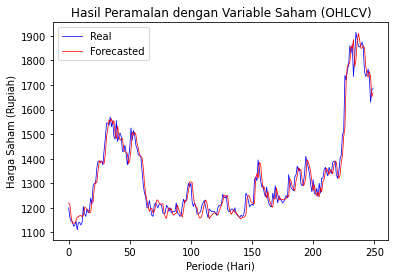

In [ ]:
figPredict = plt.gcf()
plt.plot(y_test, color = 'blue', label = 'Real', linewidth=0.75)
plt.plot(y_pred, color = 'red', label = 'Forecasted', linewidth=0.75)
plt.xlabel('Periode (Hari)')
plt.ylabel('Harga Saham (Rupiah)')
plt.title("Hasil Peramalan dengan Variable Saham (OHLCV)")
plt.legend()
plt.show()

In [ ]:
#menyimpan hasil ramalan di excel
d_test = pd.DataFrame(y_test, columns = ['y_test'])
d_pred = pd.DataFrame(y_pred, columns = ['y_pred'])
d_test.to_excel("data test.xlsx") 
d_pred.to_excel("data hasil pred.xlsx")

### Testing Model Saham & Kurs

In [ ]:
#testing data saham & kurs
modelSK = Sequential()
modelSK.add(Bidirectional(LSTM(units = 128, activation= 'relu', input_shape = (x_ktrain.shape[1], x_ktrain.shape[2]))))
modelSK.add(Dense(units = 1))
modelSK.compile(optimizer = 'adam', loss = 'mean_squared_error')
start = time()
history = modelSK.fit(x = x_ktrain, y = y_ktrain, epochs = 100, batch_size = 64)
print(f'Runtime: {time() - start} seconds')
loss = '%.4f' % history.history['loss'][-1]
print(f'Loss: {loss} ')

Epoch 1/100
16/16 [==============================] - 3s 14ms/step - loss: 0.0601
Epoch 2/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0063
Epoch 3/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0020
Epoch 4/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0014
Epoch 5/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0012
Epoch 6/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0012
Epoch 7/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0012
Epoch 8/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0012
Epoch 9/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0012
Epoch 10/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0011
Epoch 11/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0011
Epoch 12/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0011
Epoch 13/100
16/16 [=====

In [ ]:
pred_k = modelSK.predict(x_ktest)
y_pred_k = scCT.inverse_transform(pred_k)
mape = mean_absolute_percentage_error(y_ktest, y_pred_k)
rmse = mean_squared_error(y_ktest, y_pred_k, squared=False)
print("MAPE:", mape)
print("RMSE:", rmse)

MAPE: 0.02427102054397568
RMSE: 45.17790247723185


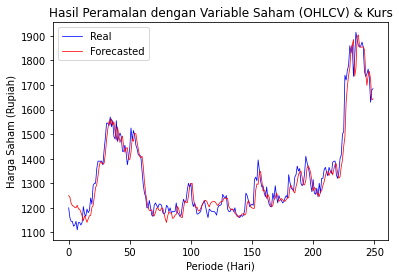

In [ ]:
figPredict = plt.gcf()
plt.plot(y_ktest, color = 'blue', label = 'Real', linewidth=0.75)
plt.plot(y_pred_k, color = 'red', label = 'Forecasted', linewidth=0.75)
plt.xlabel('Periode (Hari)')
plt.ylabel('Harga Saham (Rupiah)')
plt.title("Hasil Peramalan dengan Variable Saham (OHLCV) & Kurs")
plt.legend()
plt.show()

In [ ]:
#menyimpan hasil ramalan di excel
d_testKurs = pd.DataFrame(y_ktest, columns = ['y_ktest'])
d_predKurs = pd.DataFrame(y_pred_k, columns = ['y_pred_k'])
d_testKurs.to_excel("data test_kurs.xlsx") 
d_predKurs.to_excel("data hasil pred_kurs.xlsx")

## Testing Model dengan LSTM

### Testing Model Saham

In [ ]:
model = Sequential()
model.add(LSTM(units = 512, activation= 'relu', input_shape = (x_train.shape[1], x_train.shape[2])))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
start = time()
history = model.fit(x = x_train, y = y_train, epochs = 100, batch_size = 128) 
print(f'Runtime: {time() - start} seconds')
loss = '%.4f' % history.history['loss'][-1]
print(f'Loss: {loss} ')

Epoch 1/100
8/8 [==============================] - 3s 73ms/step - loss: 0.0824
Epoch 2/100
8/8 [==============================] - 1s 71ms/step - loss: 0.0134
Epoch 3/100
8/8 [==============================] - 1s 72ms/step - loss: 0.0074
Epoch 4/100
8/8 [==============================] - 1s 70ms/step - loss: 0.0025
Epoch 5/100
8/8 [==============================] - 1s 72ms/step - loss: 0.0021
Epoch 6/100
8/8 [==============================] - 1s 71ms/step - loss: 0.0017
Epoch 7/100
8/8 [==============================] - 1s 70ms/step - loss: 0.0014
Epoch 8/100
8/8 [==============================] - 1s 69ms/step - loss: 0.0013
Epoch 9/100
8/8 [==============================] - 1s 69ms/step - loss: 0.0012
Epoch 10/100
8/8 [==============================] - 1s 69ms/step - loss: 0.0012
Epoch 11/100
8/8 [==============================] - 1s 69ms/step - loss: 0.0012
Epoch 12/100
8/8 [==============================] - 1s 71ms/step - loss: 0.0012
Epoch 13/100
8/8 [==============================]

In [ ]:
pred = model.predict(x_test)
y_pred = scCT.inverse_transform(pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("MAPE:", mape)
print("RMSE:", rmse)

MAPE: 0.023877157372891773
RMSE: 45.657314840724446


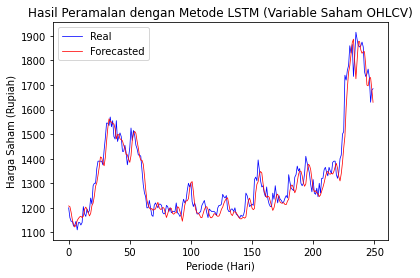

In [ ]:
figPredict = plt.gcf()
plt.plot(y_test, color = 'blue', label = 'Real', linewidth=0.75)
plt.plot(y_pred, color = 'red', label = 'Forecasted', linewidth=0.75)
plt.xlabel('Periode (Hari)')
plt.ylabel('Harga Saham (Rupiah)')
plt.title("Hasil Peramalan dengan Metode LSTM (Variable Saham OHLCV)")
plt.legend()
plt.show()

### Testing Model Saham & Kurs

In [ ]:
model = Sequential()
model.add(LSTM(units = 128, activation= 'relu', input_shape = (x_ktrain.shape[1], x_ktrain.shape[2])))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
start = time()
history = model.fit(x = x_ktrain, y = y_ktrain, epochs = 100, batch_size = 64) #untuk saham& kurs x_ktrain
print(f'Runtime: {time() - start} seconds')
loss = '%.4f' % history.history['loss'][-1]
print(f'Loss: {loss} ')

Epoch 1/100
16/16 [==============================] - 1s 10ms/step - loss: 0.1180
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0089
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0037
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0020
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0014
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0013
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0012
Epoch 8/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0012
Epoch 9/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0012
Epoch 10/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0012
Epoch 11/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0012
Epoch 12/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0012
Epoch 13/100
16/16 [============

In [ ]:
pred = model.predict(x_ktest)
y_pred = scCT.inverse_transform(pred)
mape = mean_absolute_percentage_error(y_ktest, y_pred)
rmse = mean_squared_error(y_ktest, y_pred, squared=False)
print("MAPE:", mape)
print("RMSE:", rmse)

MAPE: 0.02463416765103949
RMSE: 45.72822702382248


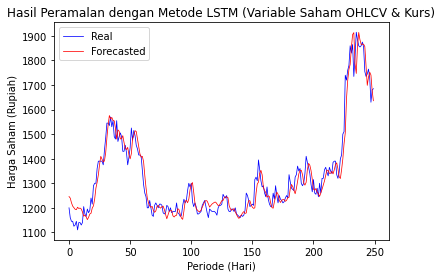

In [ ]:
figPredict = plt.gcf()
plt.plot(y_ktest, color = 'blue', label = 'Real', linewidth=0.75)
plt.plot(y_pred, color = 'red', label = 'Forecasted', linewidth=0.75)
plt.xlabel('Periode (Hari)')
plt.ylabel('Harga Saham (Rupiah)')
plt.title("Hasil Peramalan dengan Metode LSTM (Variable Saham OHLCV & Kurs)")
plt.legend()
plt.show()

## Testing Model (Dataset Lain)

###BBRI 

In [ ]:
#Testing BBRI Saham
model = Sequential()
model.add(Bidirectional(LSTM(units = 512, activation= 'relu', input_shape = (x_btrain.shape[1], x_btrain.shape[2]))))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
start = time()
history = model.fit(x = x_btrain, y = y_btrain, epochs = 100, batch_size = 128)
print(f'Runtime: {time() - start} seconds')
loss = '%.4f' % history.history['loss'][-1]
print(f'Loss: {loss} ')

Epoch 1/100
8/8 [==============================] - 4s 121ms/step - loss: 0.0862
Epoch 2/100
8/8 [==============================] - 1s 121ms/step - loss: 0.0108
Epoch 3/100
8/8 [==============================] - 1s 117ms/step - loss: 0.0071
Epoch 4/100
8/8 [==============================] - 1s 118ms/step - loss: 0.0025
Epoch 5/100
8/8 [==============================] - 1s 115ms/step - loss: 0.0019
Epoch 6/100
8/8 [==============================] - 1s 120ms/step - loss: 0.0018
Epoch 7/100
8/8 [==============================] - 1s 117ms/step - loss: 0.0016
Epoch 8/100
8/8 [==============================] - 1s 118ms/step - loss: 0.0016
Epoch 9/100
8/8 [==============================] - 1s 119ms/step - loss: 0.0016
Epoch 10/100
8/8 [==============================] - 1s 116ms/step - loss: 0.0016
Epoch 11/100
8/8 [==============================] - 1s 118ms/step - loss: 0.0015
Epoch 12/100
8/8 [==============================] - 1s 117ms/step - loss: 0.0015
Epoch 13/100
8/8 [===================

In [ ]:
pred = model.predict(x_btest) # x_btest untuk saham 
y_pred = scCBT.inverse_transform(pred) #penggunaan scaler disesuaikan scCBT untuk BBRI
mape = mean_absolute_percentage_error(y_btest, y_pred)
rmse = mean_squared_error(y_btest, y_pred, squared=False)
print("MAPE:", mape)
print("RMSE:", rmse)

MAPE: 0.017591403580159762
RMSE: 95.78856164813476


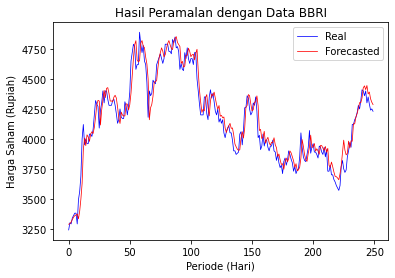

In [ ]:
figPredict = plt.gcf()
plt.plot(y_btest, color = 'blue', label = 'Real', linewidth=0.75)
plt.plot(y_pred, color = 'red', label = 'Forecasted', linewidth=0.75)
plt.xlabel('Periode (Hari)')
plt.ylabel('Harga Saham (Rupiah)')
plt.title("Hasil Peramalan dengan Data BBRI")
plt.legend()
plt.show()

In [ ]:
#Testing BBRI Saham & Kurs
model = Sequential()
model.add(Bidirectional(LSTM(units = 128, activation= 'relu', input_shape = (x_bktrain.shape[1], x_bktrain.shape[2]))))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
start = time()
history = model.fit(x = x_bktrain, y = y_bktrain, epochs = 100, batch_size = 64)
print(f'Runtime: {time() - start} seconds')
loss = '%.4f' % history.history['loss'][-1]
print(f'Loss: {loss} ')

Epoch 1/100
16/16 [==============================] - 3s 14ms/step - loss: 0.1054
Epoch 2/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0106
Epoch 3/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0037
Epoch 4/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0019
Epoch 5/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0018
Epoch 6/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0017
Epoch 7/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0017
Epoch 8/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0016
Epoch 9/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0016
Epoch 10/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0016
Epoch 11/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0015
Epoch 12/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0015
Epoch 13/100
16/16 [=====

In [ ]:
pred = model.predict(x_bktest) # x_bktest untuk saham dan kurs
y_pred = scCBT.inverse_transform(pred) #penggunaan scaler disesuaikan scCBT untuk BBRI
mape = mean_absolute_percentage_error(y_bktest, y_pred)
rmse = mean_squared_error(y_bktest, y_pred, squared=False)
print("MAPE:", mape)
print("RMSE:", rmse)

MAPE: 0.019306490154070908
RMSE: 106.48291711666172


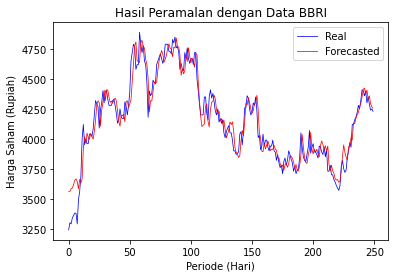

In [ ]:
figPredict = plt.gcf()
plt.plot(y_bktest, color = 'blue', label = 'Real', linewidth=0.75)
plt.plot(y_pred, color = 'red', label = 'Forecasted', linewidth=0.75)
plt.xlabel('Periode (Hari)')
plt.ylabel('Harga Saham (Rupiah)')
plt.title("Hasil Peramalan dengan Data BBRI")
plt.legend()
plt.show()

### EXCL

In [ ]:
# Testing EXCL Saham
model = Sequential()
model.add(Bidirectional(LSTM(units = 512, activation= 'relu', input_shape = (x_etrain.shape[1], x_etrain.shape[2]))))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
start = time()
history = model.fit(x = x_etrain, y = y_etrain, epochs = 100, batch_size = 128)
print(f'Runtime: {time() - start} seconds')
loss = '%.4f' % history.history['loss'][-1]
print(f'Loss: {loss} ')

Epoch 1/100
8/8 [==============================] - 4s 124ms/step - loss: 0.1272
Epoch 2/100
8/8 [==============================] - 1s 121ms/step - loss: 0.0204
Epoch 3/100
8/8 [==============================] - 1s 122ms/step - loss: 0.0105
Epoch 4/100
8/8 [==============================] - 1s 119ms/step - loss: 0.0036
Epoch 5/100
8/8 [==============================] - 1s 118ms/step - loss: 0.0033
Epoch 6/100
8/8 [==============================] - 1s 138ms/step - loss: 0.0024
Epoch 7/100
8/8 [==============================] - 1s 153ms/step - loss: 0.0022
Epoch 8/100
8/8 [==============================] - 1s 140ms/step - loss: 0.0020
Epoch 9/100
8/8 [==============================] - 1s 136ms/step - loss: 0.0019
Epoch 10/100
8/8 [==============================] - 1s 126ms/step - loss: 0.0020
Epoch 11/100
8/8 [==============================] - 1s 125ms/step - loss: 0.0019
Epoch 12/100
8/8 [==============================] - 1s 122ms/step - loss: 0.0019
Epoch 13/100
8/8 [===================

In [ ]:
pred = model.predict(x_etest) #x_etest untuk saham 
y_pred = scCET.inverse_transform(pred) #penggunaan scaler disesuaikan scCET untuk EXCL
mape = mean_absolute_percentage_error(y_etest, y_pred) #y_etest 
rmse = mean_squared_error(y_etest, y_pred, squared=False)
print("MAPE:", mape)
print("RMSE:", rmse)

MAPE: 0.022385019633007146
RMSE: 72.50234410688833


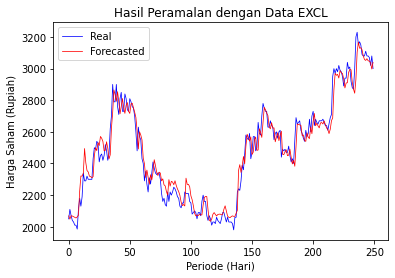

In [ ]:
figPredict = plt.gcf()
plt.plot(y_etest, color = 'blue', label = 'Real', linewidth=0.75)
plt.plot(y_pred, color = 'red', label = 'Forecasted', linewidth=0.75)
plt.xlabel('Periode (Hari)')
plt.ylabel('Harga Saham (Rupiah)')
plt.title("Hasil Peramalan dengan Data EXCL")
plt.legend()
plt.show()

In [ ]:
# Testing EXCL Saham & Kurs
model = Sequential()
model.add(Bidirectional(LSTM(units = 128, activation= 'relu', input_shape = (x_ektrain.shape[1], x_ektrain.shape[2]))))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
start = time()
history = model.fit(x = x_ektrain, y = y_ektrain, epochs = 100, batch_size = 64)
print(f'Runtime: {time() - start} seconds')
loss = '%.4f' % history.history['loss'][-1]
print(f'Loss: {loss} ')

Epoch 1/100
16/16 [==============================] - 3s 14ms/step - loss: 0.0803
Epoch 2/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0090
Epoch 3/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0033
Epoch 4/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0021
Epoch 5/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0020
Epoch 6/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0019
Epoch 7/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0019
Epoch 8/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0019
Epoch 9/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0019
Epoch 10/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0019
Epoch 11/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0018
Epoch 12/100
16/16 [==============================] - 0s 18ms/step - loss: 0.0017
Epoch 13/100
16/16 [=====

In [ ]:
pred = model.predict(x_ektest) #x_ektest untuk saham dan kurs
y_pred = scCET.inverse_transform(pred) #penggunaan scaler disesuaikan scCET untuk EXCL
mape = mean_absolute_percentage_error(y_ektest, y_pred) #y_ektest
rmse = mean_squared_error(y_ektest, y_pred, squared=False)
print("MAPE:", mape)
print("RMSE:", rmse)

MAPE: 0.023866860423774006
RMSE: 75.37013075473209


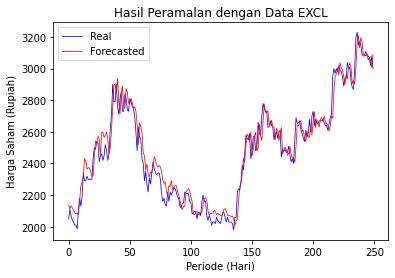

In [ ]:
figPredict = plt.gcf()
plt.plot(y_ektest, color = 'blue', label = 'Real', linewidth=0.75)
plt.plot(y_pred, color = 'red', label = 'Forecasted', linewidth=0.75)
plt.xlabel('Periode (Hari)')
plt.ylabel('Harga Saham (Rupiah)')
plt.title("Hasil Peramalan dengan Data EXCL")
plt.legend()
plt.show()